In [1]:
import os
os.chdir("/home/icb/florin.ratajczak/ppi-core-genes/")
from speos.utils.datahandlers import ResultsHandler
from speos.postprocessing.postprocessor import PostProcessor
from speos.utils.config import Config

import numpy as np
from collections import Counter

import matplotlib as plt
import matplotlib.font_manager as font_manager

font_dirs = ['/home/icb/florin.ratajczak/anaconda3/envs/compat/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# set font
plt.rcParams['font.family'] = 'Helvetica'

full_width = 18
cm = 1/2.54
small_font = 6
medium_font = 8
large_font = 10

In [2]:
os.getcwd()

'/home/icb/florin.ratajczak/ppi-core-genes'

In [54]:
phenotypes = ["Insulin Disorder","Monogenic Diabetes","Bodymass Disorder","Cardiovascular Disease","Immune Dysregulation"]

phenotype = phenotypes[4]

In [55]:
handler_paths = {"Insulin Disorder": "/home/icb/florin.ratajczak/ppi-core-genes/results/insulin_disorder.h5",
                 "Monogenic Diabetes": "/home/icb/florin.ratajczak/ppi-core-genes/results/diabetes.h5",
                 "Bodymass Disorder": "/home/icb/florin.ratajczak/ppi-core-genes/results/bm_disorder3.h5",
                 "Cardiovascular Disease": "/home/icb/florin.ratajczak/ppi-core-genes/results/cardiovascular5.h5",
                 "Immune Dysregulation": "/home/icb/florin.ratajczak/ppi-core-genes/results/immune_dysregulation.h5"}

#handler = ResultsHandler(handler_paths[phenotype], read_only=True)

config_paths = {"Insulin Disorder": "config_insulin_disorder.yaml",
                 "Monogenic Diabetes": "config_diabetes.yaml",
                 "Bodymass Disorder": "config_bm_disorder.yaml",
                 "Cardiovascular Disease": "config_cardiovascular.yaml",
                 "Immune Dysregulation": "config_immune_dysregulation.yaml"}

config = Config()
config.parse_yaml(config_paths[phenotype])

pp = PostProcessor(config)

import json

outer_results_paths = {"Insulin Disorder": "/home/icb/florin.ratajczak/ppi-core-genes/results/insulin_disorderouter_results.json",
                 "Monogenic Diabetes": "/home/icb/florin.ratajczak/ppi-core-genes/results/diabetesouter_results.json",
                 "Bodymass Disorder": "/home/icb/florin.ratajczak/ppi-core-genes/results/bm_disorder3outer_results.json",
                 "Cardiovascular Disease": "/home/icb/florin.ratajczak/ppi-core-genes/results/cardiovascular5outer_results.json",
                 "Immune Dysregulation": "/home/icb/florin.ratajczak/ppi-core-genes/results/immune_dysregulationouter_results.json"}

with open(outer_results_paths[phenotype], "r") as file:
    results = json.load(file)


In [2]:
def find_topn(matrix, n, axis=1, sort_order = "decreasing"):
    """Returns the top n indices per row (default) in the matrix """
    if sort_order == "decreasing":
        results = np.argsort(matrix,axis=axis)[:,-n:]
    elif sort_order == "increasing":
        results = np.argsort(matrix,axis=axis)[:,:n]
    elif sort_order == "symmetric_increasing":
        results = np.argsort(np.absolute(matrix),axis=axis)[:,:n]
    elif sort_order == "symmetric_decreasing":
        results = np.argsort(np.absolute(matrix),axis=axis)[:,-n:]
    else:
        raise ValueError
    return results
"""
def get_topn_explanations(hgnc,n,output_length, argument: str = "pro"):
    explanations = handler.get_explanations_for_gene(hgnc)
    if argument == "pro":
        sort_order = "decreasing"
    elif argument == "contra":
        sort_order = "increasing"
    elif argument == "unimportant":
        sort_order = "symmetric_increasing"
    elif argument == "important":
        sort_order = "symmetric_decreasing"
    top_n = find_topn(explanations, n, sort_order=sort_order)
    index_names = handler.file["explanation_columns"][:].astype(str).squeeze()
    counter = Counter(top_n.flatten())
    global_topn = counter.most_common(output_length)

    named_global_topn = {}
    for index, count in global_topn:
        named_global_topn.update({index_names[index]: count})
    return named_global_topn
"""
def get_mighty_keys(n, results):
    mighty_keys = []
    for key, value in results[0].items():
        if key != "Total" and value > n:
            mighty_keys.append(key)
    return mighty_keys

def get_OR(n, superset, results, setB):
    from scipy.stats import fisher_exact

    array = pp.make_contingency_table(superset,set(get_mighty_keys(n,results)),setB)

    odds_ratio, _ = fisher_exact(array)

    return odds_ratio


In [9]:
# mouse experiments

unknown_genes, all_genes, positive_genes = pp.get_unknown_genes(pp.results_paths[0][0])
mousegenes = set(pp.get_mouse_knockout_genes("~/ppi-core-genes/data/mgi/{}.txt".format(pp.get_doid())))
valid_mousegenes = pp.return_only_valid(mousegenes, unknown_genes)

for i in range(11):
    print("{}: {}".format(i, get_OR(i, unknown_genes, results, valid_mousegenes)))

0: 3.013054645983202
1: 3.107133150635291
2: 3.191702708802572
3: 3.0671447655206356
4: 3.207662671786319
5: 3.135206225112337
6: 3.554995975296154
7: 4.9527665317139
8: 4.809470752089137
9: 5.170607602514218
10: 6.393636699963004


In [57]:
# LoF experiments

unknown_genes, all_genes, positive_genes = pp.get_unknown_genes(pp.results_paths[0][0])
pli_table = pp.get_pli_table()
pli_genes = set(pli_table["gene"])
valid_pli_genes = pp.return_only_valid(pli_genes, unknown_genes)
hgnc2value = {hgnc: value for hgnc, value in zip(pli_table["gene"].tolist(), pli_table["lof_z"].tolist()) if hgnc in all_genes}


mendelian = [hgnc2value[hgnc] for hgnc in positive_genes.intersection(pli_genes)]
not_predicted = [hgnc2value[hgnc] for hgnc in (unknown_genes - set(get_mighty_keys(0,results))).intersection(pli_genes)]
print("Mendelian mean Z value: {}".format(np.mean(mendelian)))
print("CS=0 mean Z value: {}".format(np.mean(not_predicted)))
for i in range(11):
    print("CS>={}: {}".format(i, np.mean([hgnc2value[hgnc] for hgnc in get_mighty_keys(i,results) if hgnc in pli_genes])))

Mendelian mean Z value: 2.8935624394394757
CS=0 mean Z value: 2.17296571027643
CS>=0: 2.5106603216847314
CS>=1: 2.5240484057197925
CS>=2: 2.5418844432823935
CS>=3: 2.485870020116729
CS>=4: 2.4472881283060666
CS>=5: 2.4027629052555075
CS>=6: 2.3884288496189945
CS>=7: 2.367247756210862
CS>=8: 2.3022445396453093
CS>=9: 2.126512825871956
CS>=10: 1.9131117597887706


In [37]:
highest = set(get_mighty_keys(10, results))
len(highest.intersection(pli_genes))
len(highest)

21

In [24]:
get_topn_explanations("ABCB4",10,output_length=20, argument="pro")

{'ZSTAT HDL': 88,
 'P LDL': 78,
 'NSNPS HDL': 74,
 'P TRIG': 71,
 'P RBC': 70,
 'Nerve - Ti': 68,
 'NSNPS CAD': 64,
 'P CAD': 58,
 'ZSTAT CAD': 57,
 'Adrenal Gl': 54,
 'NSNPS RBC': 47,
 'NSNPS LDL': 41,
 'ZSTAT LDL': 41,
 'Colon - Si': 37,
 'Spleen': 26,
 'NSNPS TRIG': 25,
 'ZSTAT RBC': 25,
 'ZSTAT TRIG': 23,
 'P HDL': 19,
 'Heart - At': 17}

In [25]:
get_topn_explanations("ABCB4",10,output_length=20, argument="contra")

{'Liver': 99,
 'ZSTAT TRIG': 83,
 'Heart - Le': 82,
 'ZSTAT RBC': 81,
 'P HDL': 78,
 'NSNPS TRIG': 73,
 'ZSTAT LDL': 69,
 'NSNPS LDL': 57,
 'NSNPS RBC': 55,
 'ZSTAT CAD': 48,
 'P CAD': 48,
 'P RBC': 36,
 'NSNPS CAD': 36,
 'NSNPS HDL': 34,
 'P LDL': 30,
 'P TRIG': 28,
 'Spleen': 26,
 'total PBMC': 25,
 'Heart - At': 21,
 'ZSTAT HDL': 19}

In [26]:
get_topn_explanations("ABCB4",20,output_length=30, argument="important")

{'ZSTAT LDL': 110,
 'P LDL': 109,
 'Liver': 109,
 'ZSTAT HDL': 108,
 'ZSTAT RBC': 107,
 'NSNPS HDL': 107,
 'P CAD': 107,
 'ZSTAT TRIG': 107,
 'P RBC': 105,
 'ZSTAT CAD': 105,
 'NSNPS RBC': 104,
 'Heart - Le': 103,
 'NSNPS CAD': 103,
 'P HDL': 102,
 'NSNPS TRIG': 100,
 'P TRIG': 100,
 'NSNPS LDL': 100,
 'Adrenal Gl': 77,
 'Spleen': 67,
 'Nerve - Ti': 58,
 'Heart - At': 57,
 'total PBMC': 42,
 'Artery - A': 28,
 'Cells - EB': 24,
 'memory CD4': 23,
 'Colon - Si': 21,
 'Muscle - S': 8,
 'Small Inte': 5,
 'Bladder': 1,
 'Vagina': 1}

In [28]:
get_topn_explanations("ACAA2",20,output_length=30, argument="unimportant")

{'NSNPS CAD': 81,
 'NSNPS TRIG': 77,
 'naive B-ce': 75,
 'NSNPS LDL': 74,
 'NSNPS RBC': 73,
 'classical ': 72,
 'NSNPS HDL': 71,
 'Brain - Ce': 50,
 'T-reg': 64,
 'P LDL': 58,
 'P TRIG': 49,
 'NK-cell': 47,
 'non-classi': 46,
 'neutrophil': 43,
 'Prostate': 42,
 'gdT-cell': 42,
 'memory B-c': 42,
 'plasmacyto': 35,
 'naive CD8 ': 34,
 'MAIT T-cel': 31,
 'memory CD4': 31,
 'Cervix - E': 31,
 'Minor Sali': 30,
 'Fallopian ': 28,
 'Esophagus ': 27,
 'Skin - Sun': 26,
 'intermedia': 26,
 'P CAD': 26,
 'Spleen': 26}

In [7]:
os.getcwd()

'/mnt/home/icb/florin.ratajczak/ppi-core-genes/src'

In [133]:


#mousegenes = set(pp.get_mouse_knockout_genes("~/ppi-core-genes/data/mgi/{}_targeted_all.txt".format("diabetes_query")))

In [134]:
pp.get_doid()

'DOID9970'

In [128]:
len(unknown_genes)

16718

In [136]:

len(valid_mousegenes)

1717

In [127]:
print(len(set(results[0].keys())))
print(len(get_mighty_keys(0)))

2087
2087


In [80]:
print(sorted((mousegenes-valid_mousegenes)-positive_genes))

['ABCB1A', 'ABCB1B', 'ACE2', 'ACOT5', 'ADAM26A', 'ADSS', 'AGTR1A', 'AGTR1B', 'AGTR2', 'AKP3', 'AKR1B7', 'APOC4', 'AQP1', 'BC055324', 'BGLAP/BGLAP2', 'C4BP', 'CCL9', 'CCN1', 'CCN3', 'CCNQ', 'CD40LG', 'CD59A', 'CES1G', 'COL4A5', 'D6WSU163E', 'DEL(11MPO-CHAD)18BRD', 'DEL(17ABCG5-ABCG8)1HOBB', 'DEL(17HSPA1B-HSP1A)1DIX', 'DEL(6SLCO1B2-SLCO1A5)1NKI', 'ECRG4', 'G6PC', 'GJB1', 'GLA', 'GLRA4', 'GM648', 'GULO', 'H2-AB1', 'H3F3B', 'HDAC6', 'HJV', 'INS1', 'INS2', 'ITGB1BP2', 'LTB4R1', 'MECP2', 'MIR126A', 'MIR133A-1', 'MIR133A-2', 'MIR214', 'MIR22', 'MIR33', 'MIR378A', 'NTF5', 'OTUD6A', 'PLS3', 'PON3', 'PTCD1', 'SAA1/SAA2', 'SERF1', 'SLCO1B2', 'SNX15', 'TBX22', 'TERC', 'TIMP1', 'TRP53', 'USP11', 'WAS', 'YAE1D1', 'ZFP658', 'ZFP715']


In [88]:
"CCL9" in all_genes

False

In [119]:
#handler_paths = {"Insulin Disorder": "/home/icb/florin.ratajczak/ppi-core-genes/results/insulin_disorder.h5",
#                 "Monogenic Diabetes": "/home/icb/florin.ratajczak/ppi-core-genes/results/diabetes.h5",
#                 "Bodymass Disorder": "/home/icb/florin.ratajczak/ppi-core-genes/results/bm_disorder3.h5",
#                 "Cardiovascular Disease": "/home/icb/florin.ratajczak/ppi-core-genes/results/cardiovascular5.h5",
#                 "Immune Dysregulation": "/home/icb/florin.ratajczak/ppi-core-genes/results/immune_dysregulation.h5"}

#handler = ResultsHandler(handler_paths[phenotype], read_only=True)

phenotypes = ["Bodymass Disorder","Cardiovascular Disease","Monogenic Diabetes","Immune Dysregulation", "Insulin Disorder"]

phenotype = phenotypes[4]


config_paths = {"Insulin Disorder": "config_insulin_disorder_film.yaml",
                 "Monogenic Diabetes": "config_diabetes_film.yaml",
                 "Bodymass Disorder": "config_bm_disorder_film.yaml",
                 "Cardiovascular Disease": "config_cardiovascular_film.yaml",
                 "Immune Dysregulation": "config_immune_dysregulation_film_forreal.yaml"}

config = Config()
config.parse_yaml(config_paths[phenotype])

pp = PostProcessor(config)

import json

#method = "film"
method = "tag"

outer_results_paths = {"Insulin Disorder": "/lustre/groups/epigenereg01/projects/ppi-florin/results/insulin_disorder_{}outer_results.json".format(method),
                 "Monogenic Diabetes": "/lustre/groups/epigenereg01/projects/ppi-florin/results/diabetes_{}outer_results.json".format(method),
                 "Bodymass Disorder": "/lustre/groups/epigenereg01/projects/ppi-florin/results/bm_disorder_{}outer_results.json".format(method),
                 "Cardiovascular Disease": "/lustre/groups/epigenereg01/projects/ppi-florin/results/cardiovascular_{}outer_results.json".format(method),
                 "Immune Dysregulation": "/lustre/groups/epigenereg01/projects/ppi-florin/results/immune_dysregulation_{}outer_results.json".format(method)}

if method == "film" and phenotype == "Immune Dysregulation":
    outer_results_paths[phenotype] = "/lustre/groups/epigenereg01/projects/ppi-florin/results/immune_dysregulation_{}_forrealouter_results.json".format(method)

with open(outer_results_paths[phenotype], "r") as file:
    results = json.load(file)


bm_disorder_film 2022-05-25 13:52:27,972 [INFO] coregenes.postprocessing.postprocessor: Reading translation table from ./data/hgnc_official_list.tsv
bm_disorder_film 2022-05-25 13:52:28,106 [INFO] coregenes.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/DOID2914.txt


bm_disorder_film 2022-05-25 13:52:52,287 [INFO] coregenes.postprocessing.postprocessor: Reading translation table from ./data/hgnc_official_list.tsv
bm_disorder_film 2022-05-25 13:52:52,410 [INFO] coregenes.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/insulin_query.txt


>= 1: 3.013054645983202, p: 1.65e-54, n: 1669
>= 2: 3.107133150635291, p: 5.76e-34, n: 857
>= 3: 3.191702708802572, p: 5.04e-23, n: 510
>= 4: 3.0671447655206356, p: 3.71e-15, n: 346
>= 5: 3.207662671786319, p: 5.77e-12, n: 235
>= 6: 3.135206225112337, p: 1.56e-08, n: 164
>= 7: 3.554995975296154, p: 1.60e-07, n: 108
>= 8: 4.9527665317139, p: 2.21e-07, n: 59
>= 9: 4.809470752089137, p: 1.42e-04, n: 33
>= 10: 5.170607602514218, p: 1.71e-03, n: 20
>= 11: 6.393636699963004, p: 1.05e-02, n: 10
Mendelians: 13.184813723646545, p: 3.72e-41, n: 126


bm_disorder_film 2022-05-25 13:56:18,056 [INFO] coregenes.postprocessing.postprocessor: Reading translation table from ./data/hgnc_official_list.tsv
bm_disorder_film 2022-05-25 13:56:18,174 [INFO] coregenes.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/DOID9970.txt


>= 1: 3.221067566531176, p: 4.91e-09, n: 480
>= 2: 3.0145680406549973, p: 2.07e-06, n: 357
>= 3: 3.0385245901639344, p: 1.48e-05, n: 287
>= 4: 3.550624133148405, p: 4.34e-06, n: 226
>= 5: 4.264453412967151, p: 6.38e-07, n: 182
>= 6: 3.00501002004008, p: 1.95e-03, n: 143
>= 7: 3.5693069306930694, p: 9.41e-04, n: 111
>= 8: 3.8875847959513297, p: 1.80e-03, n: 82
>= 9: 3.978217821782178, p: 1.16e-02, n: 50
>= 10: 2.969488188976378, p: 1.58e-01, n: 26
>= 11: 6.4835361488904795, p: 4.78e-02, n: 13
Mendelians: 8.526863994005245, p: 6.56e-56, n: 584


bm_disorder_film 2022-05-25 13:56:20,465 [INFO] coregenes.postprocessing.postprocessor: Reading translation table from ./data/hgnc_official_list.tsv
bm_disorder_film 2022-05-25 13:56:20,604 [INFO] coregenes.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/cad_query.txt


>= 1: 2.555264440653181, p: 2.99e-06, n: 408
>= 2: 2.5417310514397893, p: 2.26e-05, n: 338
>= 3: 2.656053347849755, p: 1.81e-05, n: 302
>= 4: 2.7118923455014086, p: 2.62e-05, n: 274
>= 5: 2.7077549906425453, p: 5.41e-05, n: 252
>= 6: 2.6350036310820624, p: 2.18e-04, n: 224
>= 7: 2.7129994501466275, p: 1.99e-03, n: 141
>= 8: 4.147192028985507, p: 1.06e-02, n: 37
>= 9: 4.404418828049952, p: 2.29e-01, n: 7
>= 10: 0.0, p: 1.00e+00, n: 4
>= 11: nan, p: 1.00e+00, n: 0
Mendelians: 16.952280377532837, p: 5.18e-51, n: 179


bm_disorder_film 2022-05-25 13:56:23,004 [INFO] coregenes.postprocessing.postprocessor: Reading translation table from ./data/hgnc_official_list.tsv
bm_disorder_film 2022-05-25 13:56:23,128 [INFO] coregenes.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/diabetes_query.txt


>= 1: 9.230164964650433, p: 1.02e-18, n: 1003
>= 2: 11.803246816370176, p: 3.62e-14, n: 401
>= 3: 10.564454027414138, p: 1.58e-10, n: 317
>= 4: 11.347303271441202, p: 2.49e-10, n: 274
>= 5: 10.861028976936725, p: 6.62e-09, n: 240
>= 6: 12.527068437180796, p: 1.46e-09, n: 210
>= 7: 13.325115055884286, p: 3.64e-09, n: 180
>= 8: 7.714046706169397, p: 2.09e-04, n: 157
>= 9: 7.821392276422764, p: 6.52e-04, n: 128
>= 10: 9.730113636363637, p: 2.51e-04, n: 104
>= 11: 15.079752604166666, p: 3.56e-05, n: 69
Mendelians: 21.981971331461505, p: 2.12e-47, n: 525


bm_disorder_film 2022-05-25 13:56:25,369 [INFO] coregenes.postprocessing.postprocessor: Reading translation table from ./data/hgnc_official_list.tsv
bm_disorder_film 2022-05-25 13:56:25,489 [INFO] coregenes.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/DOID2914.txt


>= 1: 2.1868806272282315, p: 9.61e-05, n: 569
>= 2: 2.5049701789264414, p: 1.37e-04, n: 362
>= 3: 2.640274227092256, p: 4.05e-04, n: 257
>= 4: 2.946969364466292, p: 4.10e-04, n: 193
>= 5: 3.5230201803469505, p: 1.17e-04, n: 153
>= 6: 3.850573765086065, p: 8.97e-05, n: 131
>= 7: 4.710985055088906, p: 2.83e-05, n: 101
>= 8: 5.532528936784256, p: 3.82e-05, n: 73
>= 9: 6.812699345308041, p: 2.18e-05, n: 55
>= 10: 11.2034611141754, p: 6.71e-07, n: 37
>= 11: 14.863449410474363, p: 1.38e-05, n: 20
Mendelians: 6.408671062249426, p: 3.10e-39, n: 610


bm_disorder_film 2022-05-25 13:56:27,687 [INFO] coregenes.postprocessing.postprocessor: Reading translation table from ./data/hgnc_official_list.tsv
bm_disorder_film 2022-05-25 13:56:27,817 [INFO] coregenes.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/insulin_query.txt


>= 1: 2.3444504760461204, p: 9.70e-34, n: 1884
>= 2: 2.927062830742395, p: 3.29e-37, n: 1110
>= 3: 3.3476600985221676, p: 7.94e-35, n: 742
>= 4: 3.7314052757793763, p: 7.00e-31, n: 513
>= 5: 4.09466584565404, p: 1.60e-27, n: 376
>= 6: 4.572459893048128, p: 1.15e-24, n: 273
>= 7: 5.086085626911315, p: 4.46e-20, n: 182
>= 8: 5.253357753357753, p: 1.62e-14, n: 120
>= 9: 6.208338732201731, p: 2.20e-10, n: 64
>= 10: 9.596335369239311, p: 1.26e-03, n: 10
>= 11: 0.0, p: 1.00e+00, n: 1
Mendelians: 13.184813723646545, p: 3.72e-41, n: 126


bm_disorder_film 2022-05-25 13:56:30,063 [INFO] coregenes.postprocessing.postprocessor: Reading translation table from ./data/hgnc_official_list.tsv
bm_disorder_film 2022-05-25 13:56:30,195 [INFO] coregenes.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/DOID9970.txt


>= 1: 3.8154761904761907, p: 6.32e-20, n: 897
>= 2: 4.316787913903732, p: 1.63e-20, n: 703
>= 3: 4.202971276017204, p: 3.33e-17, n: 595
>= 4: 4.084722222222222, p: 5.65e-15, n: 531
>= 5: 4.217747087275272, p: 1.98e-14, n: 473
>= 6: 4.581720959684795, p: 9.05e-15, n: 410
>= 7: 4.900110114834042, p: 4.42e-15, n: 368
>= 8: 5.022784810126582, p: 1.71e-13, n: 306
>= 9: 5.406800142813985, p: 2.62e-13, n: 262
>= 10: 5.636541279921837, p: 1.41e-11, n: 205
>= 11: 4.9180999180999185, p: 1.86e-06, n: 126
Mendelians: 8.526863994005245, p: 6.56e-56, n: 584


bm_disorder_film 2022-05-25 13:56:32,458 [INFO] coregenes.postprocessing.postprocessor: Reading translation table from ./data/hgnc_official_list.tsv
bm_disorder_film 2022-05-25 13:56:32,583 [INFO] coregenes.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/cad_query.txt


>= 1: 2.972398248588725, p: 5.08e-22, n: 1423
>= 2: 3.3246051344173693, p: 1.21e-13, n: 567
>= 3: 3.576565283367421, p: 1.09e-09, n: 312
>= 4: 3.4139809738518556, p: 3.03e-06, n: 196
>= 5: 3.527863777089783, p: 7.39e-05, n: 129
>= 6: 3.2840169335836094, p: 2.97e-03, n: 82
>= 7: 3.31966618287373, p: 1.35e-02, n: 54
>= 8: 2.5612996457206787, p: 1.26e-01, n: 34
>= 9: 4.4093314093314095, p: 9.06e-02, n: 14
>= 10: 0.0, p: 1.00e+00, n: 7
>= 11: nan, p: 1.00e+00, n: 0
Mendelians: 16.952280377532837, p: 5.18e-51, n: 179


bm_disorder_film 2022-05-25 13:56:34,829 [INFO] coregenes.postprocessing.postprocessor: Reading translation table from ./data/hgnc_official_list.tsv
bm_disorder_film 2022-05-25 13:56:34,957 [INFO] coregenes.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/diabetes_query.txt


>= 1: 8.090952620967743, p: 3.43e-18, n: 1277
>= 2: 8.387428422696512, p: 3.63e-17, n: 1050
>= 3: 9.789863688845232, p: 1.45e-18, n: 873
>= 4: 9.689807290457395, p: 1.27e-16, n: 736
>= 5: 9.75, p: 9.39e-15, n: 600
>= 6: 10.855780182232346, p: 4.34e-14, n: 460
>= 7: 11.964705882352941, p: 7.43e-12, n: 304
>= 8: 12.400449438202248, p: 1.63e-09, n: 212
>= 9: 13.376086956521739, p: 8.50e-08, n: 144
>= 10: 17.020094562647753, p: 4.83e-07, n: 88
>= 11: 20.55296985815603, p: 8.85e-06, n: 52
Mendelians: 21.981971331461505, p: 2.12e-47, n: 525


bm_disorder_film 2022-05-25 13:56:37,185 [INFO] coregenes.postprocessing.postprocessor: Reading translation table from ./data/hgnc_official_list.tsv
bm_disorder_film 2022-05-25 13:56:37,322 [INFO] coregenes.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/DOID2914.txt


>= 1: 2.281573110004527, p: 1.47e-13, n: 2336
>= 2: 2.4566916379833974, p: 1.12e-11, n: 1434
>= 3: 2.428112747941074, p: 8.77e-09, n: 986
>= 4: 2.5906563141125014, p: 1.53e-07, n: 674
>= 5: 3.1922988171320217, p: 1.46e-08, n: 442
>= 6: 2.5638779527559055, p: 4.01e-04, n: 279
>= 7: 2.3982591228657517, p: 6.85e-03, n: 186
>= 8: 1.5650470219435737, p: 2.64e-01, n: 115
>= 9: 1.056, p: 7.15e-01, n: 67
>= 10: 1.49280872871549, p: 4.98e-01, n: 24
>= 11: 0.0, p: 1.00e+00, n: 9
Mendelians: 6.408671062249426, p: 3.10e-39, n: 610


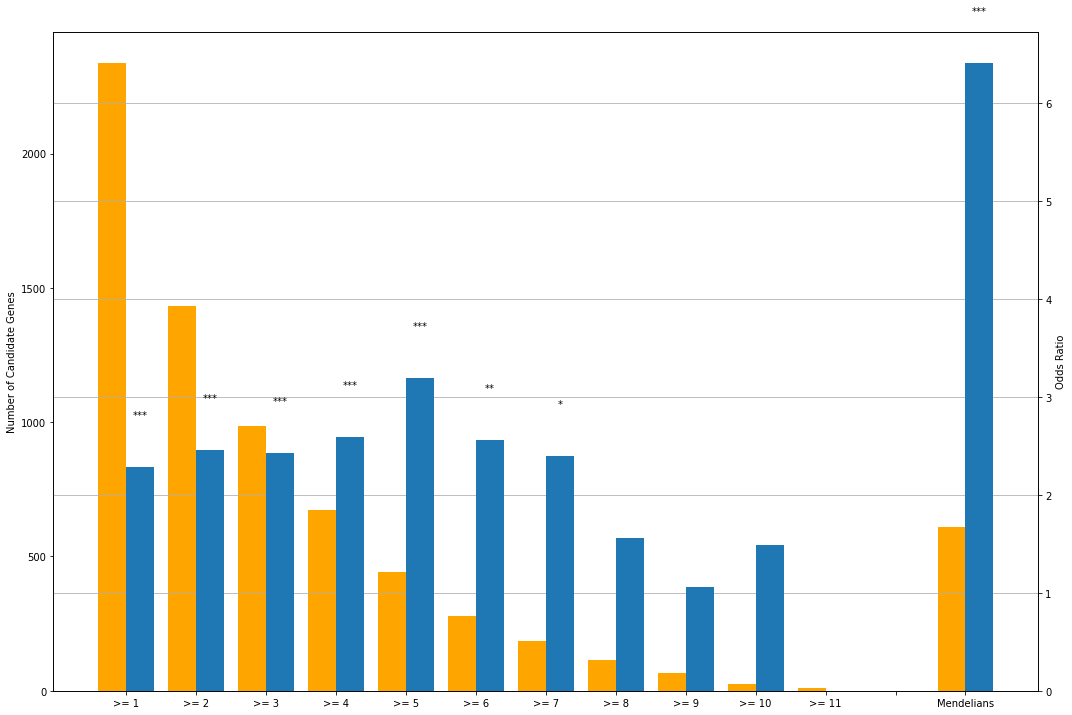

In [122]:
#handler_paths = {"Insulin Disorder": "/home/icb/florin.ratajczak/ppi-core-genes/results/insulin_disorder.h5",
#                 "Monogenic Diabetes": "/home/icb/florin.ratajczak/ppi-core-genes/results/diabetes.h5",
#                 "Bodymass Disorder": "/home/icb/florin.ratajczak/ppi-core-genes/results/bm_disorder3.h5",
#                 "Cardiovascular Disease": "/home/icb/florin.ratajczak/ppi-core-genes/results/cardiovascular5.h5",
#                 "Immune Dysregulation": "/home/icb/florin.ratajczak/ppi-core-genes/results/immune_dysregulation.h5"}

#handler = ResultsHandler(handler_paths[phenotype], read_only=True)

phenotypes = ["Bodymass Disorder","Cardiovascular Disease","Monogenic Diabetes","Immune Dysregulation", "Insulin Disorder"]
methods = ["film", "tag", "gcn", "n2vmlp"]
pretty:methods = ["Breadth", "Depth", "GCN", "N2V\n+MLP"]

for method in methods:
    for phenotype in phenotypes:


        config_paths = {"Insulin Disorder": "config_insulin_disorder_{}.yaml".format(method),
                        "Monogenic Diabetes": "config_diabetes_{}.yaml".format(method),
                        "Bodymass Disorder": "config_bm_disorder_{}.yaml".format(method),
                        "Cardiovascular Disease": "config_cardiovascular_{}.yaml".format(method),
                        "Immune Dysregulation": "config_immune_dysregulation_{}.yaml".format(method)}

        if method == "film" and phenotype == "Immune Dysregulation":
            config_paths[phenotype] = "config_immune_dysregulation_{}_forreal.yaml".format(method)

        config = Config()
        config.parse_yaml(config_paths[phenotype])

        pp = PostProcessor(config)

        import json



        outer_results_paths = {"Insulin Disorder": "/lustre/groups/epigenereg01/projects/ppi-florin/results/insulin_disorder_{}outer_results.json".format(method),
                        "Monogenic Diabetes": "/lustre/groups/epigenereg01/projects/ppi-florin/results/diabetes_{}outer_results.json".format(method),
                        "Bodymass Disorder": "/lustre/groups/epigenereg01/projects/ppi-florin/results/bm_disorder_{}outer_results.json".format(method),
                        "Cardiovascular Disease": "/lustre/groups/epigenereg01/projects/ppi-florin/results/cardiovascular_{}outer_results.json".format(method),
                        "Immune Dysregulation": "/lustre/groups/epigenereg01/projects/ppi-florin/results/immune_dysregulation_{}outer_results.json".format(method)}

        if method == "film" and phenotype == "Immune Dysregulation":
            outer_results_paths[phenotype] = "/lustre/groups/epigenereg01/projects/ppi-florin/results/immune_dysregulation_{}_forrealouter_results.json".format(method)

        with open(outer_results_paths[phenotype], "r") as file:
            results = json.load(file)


        # mouse experiments
        import matplotlib.pyplot as plt
        %matplotlib inline

        unknown_genes, all_genes, positive_genes = pp.get_unknown_genes(pp.results_paths[0][0])
        prev_to_current = pp.get_previous_symbols()
        mousegenes = set(pp.get_mouse_knockout_genes("~/ppi-core-genes/data/mgi/{}.txt".format(pp.get_doid())))
        valid_mousegenes = pp.return_only_valid(mousegenes, unknown_genes)

        groups = []
        ors = []
        pvals = []
        strengths = []

        for i in range(11):
            group = ">= {}".format(i + 1)
            groups.append(group)
            odds_ratio, pval = get_OR(i, unknown_genes, results, valid_mousegenes)
            ors.append(odds_ratio)
            pvals.append(pval)
            strength = len(get_mighty_keys(i, results))
            strengths.append(strength)
            print("{}: {}, p: {:.2e}, n: {}".format(group, odds_ratio, pval, strength))

        groups.append(" ")

        ors.append(0)
        pvals.append(1)
        strengths.append(0)
        group = "Mendelians"
        groups.append(group)
        odds_ratio, pval = get_OR(i, all_genes, set(positive_genes), set(mousegenes))
        ors.append(odds_ratio)
        pvals.append(pval)
        strength = len(positive_genes)
        strengths.append(strength)
        print("{}: {}, p: {:.2e}, n: {}".format(group, odds_ratio, pval, strength))

        xind = np.asarray((range(13)))*2
        width=0.8

        fig, ax1 = plt.subplots(figsize=(15,10))
        ax1.bar(xind-(width/2), strengths, color="orange",zorder=1)
        ax1.set_axisbelow(True)
        ax2 = ax1.twinx()
        ax2.bar(xind+(width/2), ors, zorder=1)
        ax2.set_axisbelow(True)
        ax2.grid(axis="y", zorder=-10)
        ax2.set_xticks(xind)
        ax2.set_xticklabels( groups )
        ax2.set_ylabel("Odds Ratio")
        ax1.set_ylabel("Number of Candidate Genes")


        text_y = np.asarray(ors) + 0.5
        text = []
        for pval in pvals:
            if pval < 1e-4:
                text.append("***")
            elif pval < 1e-3:
                text.append("**")
            elif pval < 5e-2:
                text.append("*")
            else:
                text.append("")

        for x, y, s in zip(xind+(width/2), text_y, text):
            ax2.text(x,y,s, ha="center")

        fig.tight_layout()
        plt.xlabel("Predicted in n Outer CVs")
        fig.savefig("OR_pval_{}.png".format(config.name), dpi=400, transparent=False)

In [3]:
def get_mighty_keys(n, results):
    mighty_keys = []
    for key, value in results[0].items():
        if key != "Total" and value > n:
            mighty_keys.append(key)
    return mighty_keys

def get_OR(n, superset, results, setB):
    from scipy.stats import fisher_exact
    try:
        results = set(get_mighty_keys(n,results))
    except TypeError:
        results = set(results)

    array = pp.make_contingency_table(superset,results,setB)

    odds_ratio, pval = fisher_exact(array)

    return odds_ratio, pval

In [72]:
rng = np.random.default_rng()

num_individuals = 17000
sample_factor = 1.5
pos_fraction= 0.02

size= int(num_individuals*sample_factor)

for i in range(10):
    drawn = set((rng.random((size,)) * 17000 ).astype(np.uint16))
    print(len(drawn) , np.sum(np.array(list(drawn)) < num_individuals*0.02))


13189 267
13213 260
13264 266
13195 270
13180 268
13214 264
13253 263
13262 275
13134 252
13202 248


In [4]:
import matplotlib.pyplot as plt
from speos.scripts.utils import fdr

In [3]:
def get_OR(n, results):
    from scipy.stats import fisher_exact

    predicted_mousegenes = set(get_mighty_keys(n, results)).intersection(valid_mousegenes)
    predicted_nonmousegenes = set(get_mighty_keys(n, results)).intersection(unknown_genes - valid_mousegenes)
    unpredicted_mousegenes = (unknown_genes - set(get_mighty_keys(n, results))).intersection(valid_mousegenes)
    unpredicted_nonmousegenes = (unknown_genes - set(get_mighty_keys(n, results))).intersection(unknown_genes - valid_mousegenes)

    if len(unpredicted_nonmousegenes) > 0 and len(predicted_nonmousegenes) > 0 and (len(unpredicted_mousegenes) / len(unpredicted_nonmousegenes)) > 0:
        odds_ratio = (len(predicted_mousegenes)  / len(predicted_nonmousegenes)) / (len(unpredicted_mousegenes) / len(unpredicted_nonmousegenes))
    else:
        odds_ratio = -1

    return odds_ratio

bm_disorder_film 2022-08-29 14:03:50,945 [INFO] speos.postprocessing.postprocessor: Reading translation table from ./data/hgnc_official_list.tsv
bm_disorder_film 2022-08-29 14:03:51,516 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/DOID9970.txt
bm_disorder_film 2022-08-29 14:03:51,849 [INFO] speos.postprocessing.postprocessor: Reading translation table from ./data/hgnc_official_list.tsv
bm_disorder_film 2022-08-29 14:03:52,029 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/DOID9970.txt
bm_disorder_film 2022-08-29 14:03:52,236 [INFO] speos.postprocessing.postprocessor: Reading translation table from ./data/hgnc_official_list.tsv
bm_disorder_film 2022-08-29 14:03:52,427 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/DOID9970.txt
bm_disorder_film 2022-08-29 14:03:52,645 [INFO] speos.postprocessing.postprocessor: Reading tr

FileNotFoundError: [Errno 2] No such file or directory: 'config_immune_dysregulation_film_forreal.yaml'

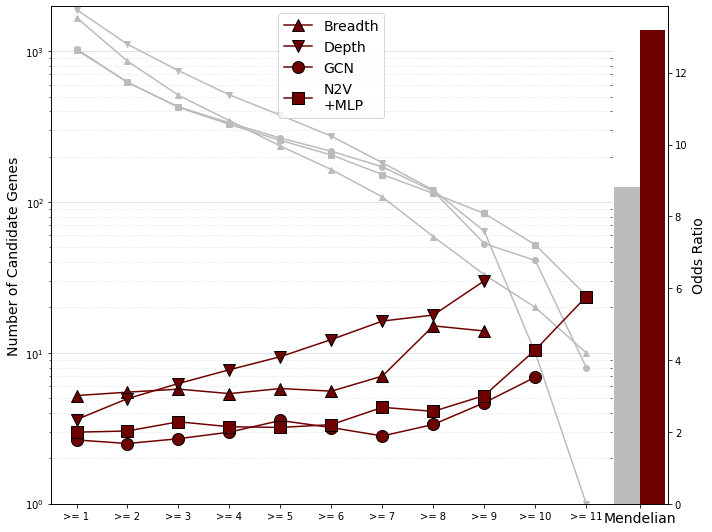

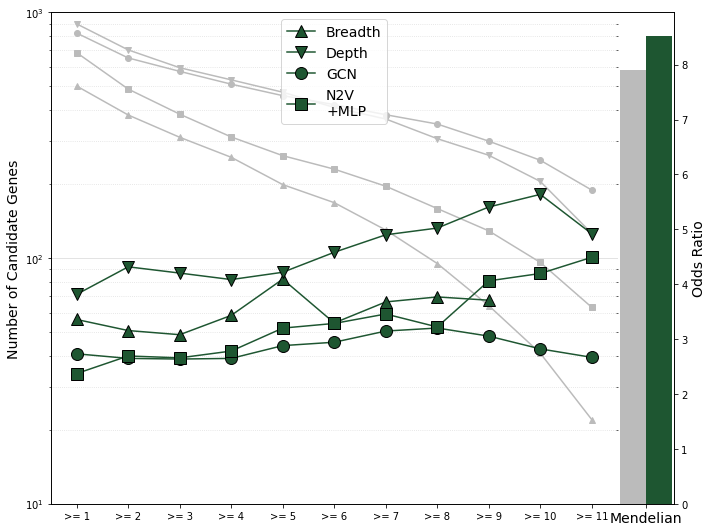

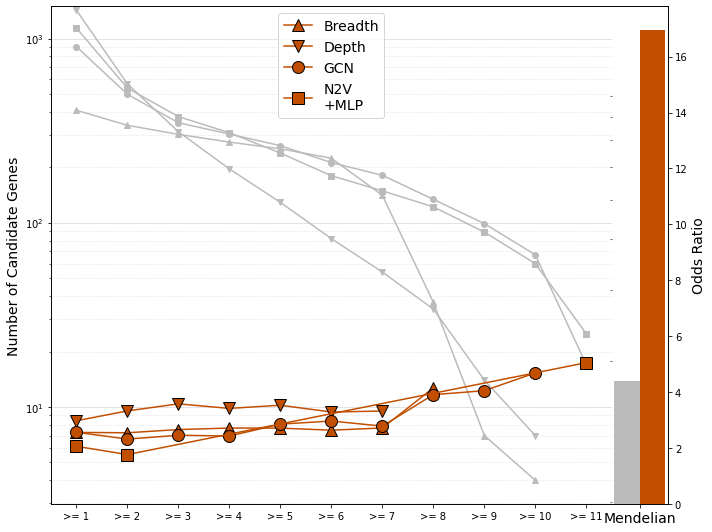

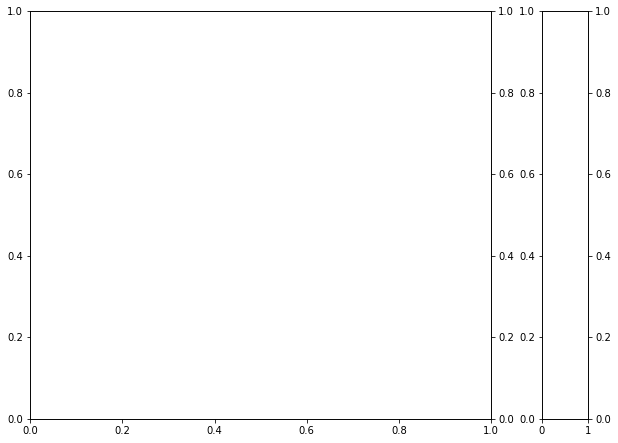

In [5]:
#handler_paths = {"Insulin Disorder": "/home/icb/florin.ratajczak/ppi-core-genes/results/insulin_disorder.h5",
#                 "Monogenic Diabetes": "/home/icb/florin.ratajczak/ppi-core-genes/results/diabetes.h5",
#                 "Bodymass Disorder": "/home/icb/florin.ratajczak/ppi-core-genes/results/bm_disorder3.h5",
#                 "Cardiovascular Disease": "/home/icb/florin.ratajczak/ppi-core-genes/results/cardiovascular5.h5",
#                 "Immune Dysregulation": "/home/icb/florin.ratajczak/ppi-core-genes/results/immune_dysregulation.h5"}

#handler = ResultsHandler(handler_paths[phenotype], read_only=True)

phenotypes = ["Bodymass Disorder","Cardiovascular Disease","Monogenic Diabetes","Immune Dysregulation", "Insulin Disorder"]
methods = ["film", "tag", "gcn", "n2vmlp"]
pretty_methods = ["Breadth", "Depth", "GCN", "N2V\n+MLP"]

tick_size = 12
label_size = 14

crimson = "#6f0000"
navy = "#02055a"
jungle = "#1e5631"
tan = "#c24e00"
petrol = "#005f6a"
grey = "#bbbbbb"
lightgrey = "#dddddd"

for phenotype, color in zip(phenotypes, [crimson, jungle, tan, navy, petrol]):
    fig, (ax1, ax3) = plt.subplots(figsize=(10,7.5), ncols=2, sharey=False, gridspec_kw={'width_ratios': [10, 1]})
    ax2 = ax1.twinx()
    ax4 = ax3.twinx()
    handles = []
    min_strength = 1000
    for method, marker in zip(methods, ["^", "v", "o", "s", "p"]):
    
        config_paths = {"Insulin Disorder": "configs/config_insulin_disorder_{}.yaml".format(method),
                        "Monogenic Diabetes": "configs/config_diabetes_{}.yaml".format(method),
                        "Bodymass Disorder": "configs/config_bm_disorder_{}.yaml".format(method),
                        "Cardiovascular Disease": "configs/config_cardiovascular_{}.yaml".format(method),
                        "Immune Dysregulation": "configs/config_immune_dysregulation_{}.yaml".format(method)}

        if method == "film" and phenotype == "Immune Dysregulation":
            config_paths[phenotype] = "configs/config_immune_dysregulation_{}_forreal.yaml".format(method)

        config = Config()
        config.parse_yaml(config_paths[phenotype])

        pp = PostProcessor(config)

        import json

        outer_results_paths = {"Insulin Disorder": "/lustre/groups/epigenereg01/projects/ppi-florin/results/insulin_disorder_{}outer_results.json".format(method),
                        "Monogenic Diabetes": "/lustre/groups/epigenereg01/projects/ppi-florin/results/diabetes_{}outer_results.json".format(method),
                        "Bodymass Disorder": "/lustre/groups/epigenereg01/projects/ppi-florin/results/bm_disorder_{}outer_results.json".format(method),
                        "Cardiovascular Disease": "/lustre/groups/epigenereg01/projects/ppi-florin/results/cardiovascular_{}outer_results.json".format(method),
                        "Immune Dysregulation": "/lustre/groups/epigenereg01/projects/ppi-florin/results/immune_dysregulation_{}outer_results.json".format(method)}

        if method == "film" and phenotype == "Immune Dysregulation":
            outer_results_paths[phenotype] = "/lustre/groups/epigenereg01/projects/ppi-florin/results/immune_dysregulation_{}_forrealouter_results.json".format(method)

        with open(outer_results_paths[phenotype], "r") as file:
            results = json.load(file)

        unknown_genes, all_genes, positive_genes = pp.get_unknown_genes(pp.results_paths[0][0])
        mousegenes = set(pp.get_mouse_knockout_genes("~/ppi-core-genes/data/mgi/{}.txt".format(pp.get_doid())))
        valid_mousegenes = pp.return_only_valid(mousegenes, unknown_genes)

        groups = []
        ors = []
        pvals = []
        strengths = []

        for i in range(11):
            group = ">= {}".format(i + 1)
            groups.append(group)
            odds_ratio, pval = get_OR(i, unknown_genes, results, valid_mousegenes)
            ors.append(odds_ratio)
            pvals.append(pval)
            strength = len(get_mighty_keys(i, results))
            strengths.append(strength)
            #print("{}: {}, p: {:.2e}, n: {}".format(group, odds_ratio, pval, strength))

        
        min_strength = np.min(strengths) if np.min(strengths) < min_strength else min_strength
        m_odds_ratio, m_pval = get_OR(i, all_genes, set(positive_genes), set(mousegenes))
        m_strength = len(positive_genes)
        #print("{}: {}, p: {:.2e}, n: {}".format(group, odds_ratio, pval, strength))

        xind = np.asarray((range(11)))
        width=0.8

        # plot set strengths
        is_positive = np.asarray(strengths) > 0
        draw_xind = np.asarray(xind)[is_positive]
        draw_strengths = np.asarray(strengths)[is_positive]
        ax1.plot(draw_xind, draw_strengths, color=grey, zorder=1, marker=marker)
        ax1.set_axisbelow(True)
        ax3.bar(1-(width/2), height=m_strength, width=width, color=grey, zorder=1)
        ax3.set_axisbelow(True)
        
        is_significant = np.asarray(fdr(pvals)) < 0.05
        is_enough = np.asarray(strengths) > 20
        use_only = is_significant & is_enough
        draw_xind = np.asarray(xind)[use_only]
        draw_ors = np.asarray(ors)[use_only]
        handle, =ax2.plot(draw_xind, draw_ors, color=color, zorder=1, marker=marker, markeredgecolor="black", ms=12, label=method)
        handles.append(handle)
        ax4.bar(1+(width/2), height=m_odds_ratio, width=width, color=color, zorder=1)
        ax4.set_axisbelow(True)
        ax4.set_axisbelow(True)
        ax2.set_axisbelow(True)
        ax2.set_xticks(xind)
        ax2.set_xticklabels(groups, size=label_size)
        ax3.set_xticks([1])
        ax3.set_xticklabels(["Mendelian"], size=label_size)
        ax4.set_ylabel("Odds Ratio", size=label_size)
        ax1.set_ylabel("Number of Candidate Genes", size=label_size)
        
        """
        all_strengths = strengths[:]
        all_strengths.append(m_strength)
        ax1.set_ylim((0, np.max(all_strengths)))
        #ax3.set_ylim((0, np.max(all_strengths)))
        all_ors = ors[:]
        all_ors.append(m_strength)
        ax2.set_ylim((0, np.max(all_ors)))
        #ax4.set_ylim((0, np.max(all_ors)))
        """
        """
        text_y = np.asarray(ors) + 0.5
        text = []
        for pval in pvals:
            if pval < 1e-4:
                text.append("***")
            elif pval < 1e-3:
                text.append("**")
            elif pval < 5e-2:
                text.append("*")
            else:
                text.append("")

        for x, y, s in zip(xind+(width/2), text_y, text):
            ax2.text(x,y,s, ha="center")
        """

    _, candidate_max_strength = ax1.get_ylim()
    _, mendelian_max_strength = ax3.get_ylim()
    max_strength = np.max((candidate_max_strength, mendelian_max_strength))
    max_strenth = 1000 if max_strength < 1000 else max_strength

    min_strength = 10 if min_strength > 10 else min_strength
    min_strength = 1 if min_strength < 0 else min_strength

    ax1.set_yscale('log')
    ax3.set_yscale('log')
    ax1.set_ylim((min_strength, max_strenth))
    ax3.set_ylim((min_strength, max_strenth))
    
    candidate_max_or = ax2.get_ylim()[1]
    mendelian_max_or = ax4.get_ylim()[1]
    ax2.set_ylim((0, np.max((candidate_max_or, mendelian_max_or))))
    ax4.set_ylim((0, np.max((candidate_max_or, mendelian_max_or))))
    ax1.grid(which="major", axis="y", color=lightgrey)
    ax1.grid(which="minor", axis="y", linestyle=":", color=lightgrey)
    ax3.set_yticks([], which="both")
    ax3.spines['left'].set_visible(False)
    ax4.spines['left'].set_visible(False)
    ax2.set_yticks([])
    ax1.spines['right'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    #or_lines_y = ax4.get_xticks()

    #for y in  or_lines_y:
    #    ax2.plot((-0.5, 13.5), (y, y), color="grey")
    
    fig.tight_layout()
    plt.subplots_adjust(wspace=0)
    ax2.legend(handles, pretty_methods, loc='upper center',prop={'size': label_size})
    #plt.xlabel("Predicted in n Outer CVs")
    #fig.savefig("OR_pval_{}.png".format(config.name), dpi=400, transparent=False)
    plt.savefig("OR_new_{}.png".format(phenotype))


immune_dysregulation_tag 2023-01-24 16:31:57,074 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/background.txt
immune_dysregulation_tag 2023-01-24 16:31:57,502 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/insulin_query.txt
immune_dysregulation_tag 2023-01-24 16:31:57,633 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/insulin_query.txt
immune_dysregulation_tag 2023-01-24 16:34:04,038 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/background.txt
immune_dysregulation_tag 2023-01-24 16:34:04,444 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/cad_query.txt


14680
14680


immune_dysregulation_tag 2023-01-24 16:34:04,620 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/cad_query.txt


14680


immune_dysregulation_tag 2023-01-24 16:34:05,045 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/cad_query.txt


14680


immune_dysregulation_tag 2023-01-24 16:34:05,481 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/cad_query.txt


14680


immune_dysregulation_tag 2023-01-24 16:34:06,024 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/cad_query.txt


14443


immune_dysregulation_tag 2023-01-24 16:34:06,482 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/immune_dysreg_query.txt


14443


immune_dysregulation_tag 2023-01-24 16:34:06,911 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/immune_dysreg_query.txt


14443


immune_dysregulation_tag 2023-01-24 16:34:07,350 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/immune_dysreg_query.txt


14443


immune_dysregulation_tag 2023-01-24 16:34:07,898 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/immune_dysreg_query.txt


14443


immune_dysregulation_tag 2023-01-24 16:34:08,333 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/immune_dysreg_query.txt


14709


immune_dysregulation_tag 2023-01-24 16:34:08,838 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/DOID9970.txt


14709


immune_dysregulation_tag 2023-01-24 16:34:09,302 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/DOID9970.txt


14709


immune_dysregulation_tag 2023-01-24 16:34:09,764 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/DOID9970.txt


14709


immune_dysregulation_tag 2023-01-24 16:34:10,353 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/DOID9970.txt


14709


immune_dysregulation_tag 2023-01-24 16:34:10,811 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/DOID9970.txt


14715


immune_dysregulation_tag 2023-01-24 16:34:11,315 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/diabetes_query.txt


14715


immune_dysregulation_tag 2023-01-24 16:34:11,749 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/diabetes_query.txt


14715


immune_dysregulation_tag 2023-01-24 16:34:12,289 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/diabetes_query.txt


14715


immune_dysregulation_tag 2023-01-24 16:34:12,724 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/diabetes_query.txt


14715


immune_dysregulation_tag 2023-01-24 16:34:13,155 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/diabetes_query.txt


14712


immune_dysregulation_tag 2023-01-24 16:34:13,611 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/insulin_query.txt


14712


immune_dysregulation_tag 2023-01-24 16:34:14,158 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/insulin_query.txt


14712


immune_dysregulation_tag 2023-01-24 16:34:14,610 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/insulin_query.txt


14712


immune_dysregulation_tag 2023-01-24 16:34:15,048 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/insulin_query.txt


14712
56
56
60
60
55
55
39
39
55
55
[451 339 274 213 175 142 114  86  57  36  18 564]
12
[843 665 568 506 451 393 351 290 247 193 117 564]
12
[722 580 504 442 404 376 334 303 270 222 158 564]
12
[629 449 353 290 243 218 183 152 124  96  66 564]
12
[1969 1425 1080  920  812  702  615  527  426  289  163  564]
12
[953 384 305 261 232 201 177 156 131 104  68 508]
12
[1212  997  828  696  570  441  291  206  140   85   49  508]
12
[1565 1045  754  480  344  211  136   97   69   46   22  508]
12
[859 618 507 426 361 302 259 223 176 140  99 508]
12
[2317 1760 1436 1232 1065  936  812  694  563  437  290  508]
12
[1253  675  413  262  171  111   68   39   24   13    4  123]
12
[1752 1046  710  488  358  262  174  116   61   10    1  123]
12
[876 520 372 296 236 193 158  98  49  38   8 123]
12
[972 620 424 313 239 191 140 102  80  49  27 123]
12
[1666 1092  818  686  575  486  410  320  260  181   93  123]
12
[397 331 298 270 248 220 138  37   7   4   0 174]
12
[1335  526  275  187  121   88  

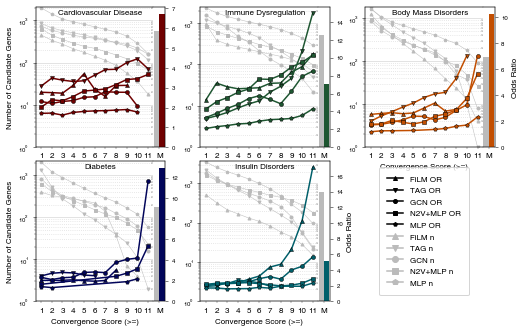

In [31]:
#handler_paths = {"Insulin Disorder": "/home/icb/florin.ratajczak/ppi-core-genes/results/insulin_disorder.h5",
#                 "Monogenic Diabetes": "/home/icb/florin.ratajczak/ppi-core-genes/results/diabetes.h5",
#                 "Bodymass Disorder": "/home/icb/florin.ratajczak/ppi-core-genes/results/bm_disorder3.h5",
#                 "Cardiovascular Disease": "/home/icb/florin.ratajczak/ppi-core-genes/results/cardiovascular5.h5",
#                 "Immune Dysregulation": "/home/icb/florin.ratajczak/ppi-core-genes/results/immune_dysregulation.h5"}

#handler = ResultsHandler(handler_paths[phenotype], read_only=True)
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import pandas as pd
from speos.visualization.settings import *
import matplotlib.pyplot as plt

def get_mighty_keys(n, results):
    mighty_keys = []
    for key, value in results[0].items():
        if key != "Total" and value > n:
            mighty_keys.append(key)
    return mighty_keys

def get_OR(n, superset, results, setB):
    from scipy.stats import fisher_exact
    try:
        results = set(get_mighty_keys(n,results))
    except TypeError:
        results = set(results)

    array = pp.make_contingency_table(superset,results,setB)

    odds_ratio, pval = fisher_exact(array)

    return odds_ratio, pval, array

import numpy as np
from statsmodels.stats.multitest import fdrcorrection as fdr

background = None

phenotypes = ["Cardiovascular Disease", "Immune Dysregulation", "Body Mass Disorders", "Diabetes", "Insulin Disorders"]
methods = ["film", "tag", "gcn", "n2vmlp", "mlp"]
pretty_methods = ["FiLM", "TAG", "GCN", "N2V+MLP", "MLP"]

tick_size = small_font
label_size = medium_font
title_size = medium_font

crimson = "#6f0000"
navy = "#02055a"
jungle = "#1e5631"
tan = "#c24e00"
petrol = "#005f6a"
grey = "#bbbbbb"
lightgrey = "#dddddd"
width_ratios = [10, 1]*2
marker_size = 4


colors_ = [crimson, jungle, tan, navy, petrol]
markers = ["^", "v", "o", "s", "p"]
min_strength = 1000

outer_dfs_list = []
for frame_idx, (phenotype, color) in enumerate(zip(phenotypes, colors_)):
    if frame_idx == 5:
        break
    dfs = []
    for pretty_method, method, marker in zip(pretty_methods, methods, markers):
        _columns= ["Method", "CS/Mendelian", "N Candidate/Mendelian and MKO", "N Candidate/Mendelian not MKO", "N Not Candidate/Mendelian and MKO", "N Not Candidate/Mendelian Not MKO", "OR", "pval unadjusted", "pval adjusted (FDR)"]
        df = pd.DataFrame(data=np.empty((11, len(_columns))), columns=_columns)
        if method in ["gcn", "mlp", "n2vmlp"] and phenotype == "Immune Dysregulation":
            method += "_new"
        
        if method == "film" and phenotype == "Immune Dysregulation":
            method += "_forreal"
    
        config_paths = {"Insulin Disorders": "configs/config_insulin_disorder_{}.yaml".format(method),
                        "Diabetes": "configs/config_diabetes_{}.yaml".format(method),
                        "Body Mass Disorders": "configs/config_bm_disorder_{}.yaml".format(method),
                        "Cardiovascular Disease": "configs/config_cardiovascular_{}.yaml".format(method),
                        "Immune Dysregulation": "configs/config_immune_dysregulation_{}.yaml".format(method)}
        
        #if method == "film" and phenotype == "Immune Dysregulation":
        #    config_paths[phenotype] = "configs/config_immune_dysregulation_{}_forreal.yaml".format(method)

        config = Config()
        config.parse_yaml(config_paths[phenotype])

        pp = PostProcessor(config)

        import json

        
        outer_results_paths = {"Insulin Disorders": "/lustre/groups/epigenereg01/projects/ppi-florin/results/insulin_disorder_{}outer_results.json".format(method),
                        "Diabetes": "/lustre/groups/epigenereg01/projects/ppi-florin/results/diabetes_{}outer_results.json".format(method),
                        "Body Mass Disorders": "/lustre/groups/epigenereg01/projects/ppi-florin/results/bm_disorder_{}outer_results.json".format(method),
                        "Cardiovascular Disease": "/lustre/groups/epigenereg01/projects/ppi-florin/results/cardiovascular_{}outer_results.json".format(method),
                        "Immune Dysregulation": "/lustre/groups/epigenereg01/projects/ppi-florin/results/immune_dysregulation_{}outer_results.json".format(method)}

        
        #outer_results_paths[phenotype] = "/lustre/groups/epigenereg01/projects/ppi-florin/results/immune_dysregulation_{}_forrealouter_results.json".format(method)
        

        with open(outer_results_paths[phenotype], "r") as file:
            results = json.load(file)

        unknown_genes, all_genes, positive_genes = pp.get_unknown_genes(pp.results_paths[0][0])
        if background is None:
            background = set(pp.get_mouse_knockout_background("~/ppi-core-genes/data/mgi/background.txt"))
        valid_background = background.intersection(all_genes)
        print(len(valid_background))
        valid_unlabeled_background = valid_background.intersection(unknown_genes)
                
        mousegenes = set(pp.get_mouse_knockout_genes("~/ppi-core-genes/data/mgi/{}.txt".format(pp.get_doid())))
        valid_mousegenes = pp.return_only_valid(mousegenes, valid_background)
        valid_unlabeled_mousegenes = pp.return_only_valid(mousegenes, valid_unlabeled_background)
        
        #print("{} {}: {} positives".format(phenotype, method, len(positive_genes)))
        groups = []
        ors = []
        pvals = []
        strengths = []
        n_candidates_and_mko = []
        n_candidates_not_mko = []
        n_not_candidates_and_mko = []
        n_not_candidates_not_mko = []

        for i in range(11):
            group = ">= {}".format(i + 1)
            groups.append(group)
            odds_ratio, pval, array = get_OR(i, valid_unlabeled_background, results, valid_unlabeled_mousegenes)
            ors.append(odds_ratio)
            pvals.append(pval)
            strength = len(get_mighty_keys(i, results))
            strengths.append(strength)
            df.loc[i, :] = [pretty_method, "CS "+ group, array[0][0], array[1][0], array[0][1], array[1][1], odds_ratio, pval, None]
            #print("{}: {}, p: {:.2e}, n: {}".format(group, odds_ratio, pval, strength))

        min_strength = np.min(strengths) if np.min(strengths) < min_strength else min_strength
        m_odds_ratio, m_pval, array = get_OR(i, valid_background, set(positive_genes), valid_mousegenes)
        m_strength = len(positive_genes)
        #print("{}: {}, p: {:.2e}, n: {}".format(group, odds_ratio, pval, strength))
        df.loc[11, :] = ["-", "Mendelian", array[0][0], array[1][0], array[0][1], array[1][1], m_odds_ratio, m_pval, None]

        if phenotype == "Cardiovascular Disease" and method == "tag":
            cvd_strengths = strengths
            cvd_ors = ors
            cvd_mendelian_strength = m_strength
            cvd_mendelian_ors = m_odds_ratio

        
        dfs.append(df)
    
    dfs = pd.concat(dfs)
    
    for column in dfs.columns:
        if "OR" in column:
            dfs[column] = dfs[column].round(3)
        if "N " in column:
            dfs[column] = dfs[column].astype(int)
    outer_dfs_list.append(dfs)

pvals = []
for df in outer_dfs_list:
    pvals.extend(df["pval unadjusted"].tolist())


adj_pvals = fdr(pvals)[1]

for df, adj_pval_one_df, phenotype in zip(outer_dfs_list, np.array_split(adj_pvals, len(outer_dfs_list)), phenotypes):
    print((adj_pval_one_df < 0.05).sum())
    df["pval adjusted (FDR)"] = adj_pval_one_df
    print((df["pval adjusted (FDR)"] < 0.05).sum())
    df.to_csv("statistical_dump/{}_ors_mko.tsv".format(phenotype), sep="\t", index=False)

fig, axes = plt.subplots(figsize=(full_width*cm,12*cm), nrows=2, ncols=9, sharey=False, gridspec_kw={'width_ratios': [10, 1, 3, 10, 1, 3, 10, 1, 0.1]})
axes = axes.flatten()

for frame_idx, (phenotype, color, (ax1, ax3, invis_ax), df) in enumerate(zip(phenotypes + ["None"], colors_ + ["None"], np.array_split(axes, 6), outer_dfs_list + ["None"])):
    if frame_idx == 5:
        ax1.axis("off")
        ax3.axis("off")
        invis_ax.axis("off")
        handles = [Line2D([0], [0], color="black", marker=marker, markersize=marker_size, label=label + " OR") for marker, label in zip(markers, pretty_methods)]
        handles.extend([Line2D([0], [0], color=grey, marker=marker, label=label + " n") for marker, label in zip(markers, pretty_methods)])
        #handles.extend([Patch(facecolor=color, edgecolor='black', label=label) for color, label in zip(colors_, phenotypes)])
        #handles.append([Line2D([0], [0], color=color, marker="s", label=label) for label in phenotypes])
        ax1.legend(handles=handles, loc='center', fontsize=label_size, labelspacing=0.5, borderpad=1)
        break
    
    ax2 = ax1.twinx()
    ax4 = ax3.twinx()
    handles = []
    min_strength = 1000
    dfs = []
    
    start = 0
    stride = 12

    for method_idx, (pretty_method, method, marker) in enumerate(zip(pretty_methods, methods, markers)):
        
        method_df = df[start:start + stride]
        start += stride
        assert method_df["Method"][0] == pretty_method

        groups = method_df["CS/Mendelian"][:-1]
        ors = method_df["OR"]
        adj_pvals = method_df["pval adjusted (FDR)"]
        strengths = np.asarray(method_df["N Candidate/Mendelian and MKO"]) + np.asarray(method_df["N Candidate/Mendelian not MKO"])
        print(strengths)
        print(len(strengths))
        n_candidates_and_mko = method_df["N Candidate/Mendelian and MKO"]
        n_candidates_not_mko = method_df["N Candidate/Mendelian not MKO"]
        n_not_candidates_and_mko = method_df["N Not Candidate/Mendelian and MKO"]
        n_not_candidates_not_mko = method_df["N Not Candidate/Mendelian Not MKO"]

        xind = np.asarray((range(11)))
        width = 0.8

        # plot set strengths
        is_positive = np.asarray(strengths[:-1]) > 0
        draw_xind = np.asarray(xind)[is_positive]
        draw_strengths = np.asarray(strengths[:-1])[is_positive]
        ax1.plot(draw_xind, draw_strengths, color=grey, zorder=1, marker=marker, ms=marker_size-1, linewidth=0.5)
        ax1.set_axisbelow(True)
        ax3.bar(1-(width/2), height=strengths[-1], width=width, color=grey, zorder=1)
        ax3.set_axisbelow(True)
        
        is_significant = np.asarray(adj_pvals[:-1]) < 0.05
        is_enough = np.asarray(strengths[:-1]) > 0
        use_only = is_significant & is_enough
        draw_xind = np.asarray(xind)[use_only]
        draw_ors = np.asarray(ors[:-1])[use_only]
        handle, =ax2.plot(draw_xind, draw_ors, color=color, zorder=1, marker=marker, markeredgecolor="black",markeredgewidth=0.5, ms=marker_size, label=method)
        handles.append(handle)
        ax4.bar(1+(width/2), height=ors.tolist()[-1], width=width, color=color, zorder=1)
        ax4.set_axisbelow(True)
        ax4.set_axisbelow(True)
        ax2.set_axisbelow(True)
        ax2.set_xticks(xind)
        ax2.set_xticklabels(xind.astype(np.uint8) + 1, size=small_font)
        ax3.set_xticks([1])
        ax3.set_xticklabels(["M"], size=label_size)
        if frame_idx % 3 == 0:
            ax1.set_ylabel("Number of Candidate Genes", size=label_size)
        elif frame_idx % 3 == 2:
            ax4.set_ylabel("Odds Ratio", size=label_size)
        
        if frame_idx == 4:
            ax4.set_ylabel("Odds Ratio", size=label_size)
            
        if frame_idx >= 2:
            ax1.set_xlabel("Convergence Score (>=)", size=label_size)

        ax1.set_title(phenotype, y=1.05, x=0.55, pad=-14, size=title_size)
        
        
    

    _, candidate_max_strength = ax1.get_ylim()
    _, mendelian_max_strength = ax3.get_ylim()
    max_strength = np.max((candidate_max_strength, mendelian_max_strength))
    max_strenth = 1000 if max_strength < 1000 else max_strength

    min_strength = 1

    ax1.set_yscale('log')
    ax3.set_yscale('log')
    ax1.set_ylim((min_strength, max_strenth))
    ax3.set_ylim((min_strength, max_strenth))
    
    candidate_max_or = ax2.get_ylim()[1]
    mendelian_max_or = ax4.get_ylim()[1]
    ax2.set_ylim((0, np.max((candidate_max_or, mendelian_max_or))))
    ax4.set_ylim((0, np.max((candidate_max_or, mendelian_max_or))))
    ax1.grid(which="major", axis="y", color=lightgrey)
    ax1.grid(which="minor", axis="y", linestyle=":", color=lightgrey)
    ax3.set_yticks([], which="both")
    ax3.spines['left'].set_visible(False)
    ax4.spines['left'].set_visible(False)
    ax2.set_yticks([])
    ax1.spines['right'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax1.tick_params(axis="x", labelsize=label_size)
    invis_ax.set_visible(False)
    #or_lines_y = ax4.get_xticks()

    #for y in  or_lines_y:
    #    ax2.plot((-0.5, 13.5), (y, y), color="grey")

fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0.1)
#ax2.legend(handles, pretty_methods, loc='upper center',prop={'size': label_size})
#plt.xlabel("Predicted in n Outer CVs")
#plt.savefig("OR_all.png".format(config.name), dpi=400, transparent=False,facecolor="white", bbox_inches='tight')
plt.savefig("OR_all.svg", bbox_inches='tight')


In [32]:
method_df

,Method,CS/Mendelian,N Candidate/Mendelian and MKO,N Candidate/Mendelian not MKO,N Not Candidate/Mendelian and MKO,N Not Candidate/Mendelian Not MKO,OR,pval unadjusted,pval adjusted (FDR)
0,MLP,CS >= 1,190,3316,345,10272,1.706,2.226295e-08,5.474495e-08
1,MLP,CS >= 2,143,2412,392,11176,1.690,5.425802e-07,1.233137e-06
2,MLP,CS >= 3,109,1883,426,11705,1.591,4.804118e-05,8.282962e-05
3,MLP,CS >= 4,91,1535,444,12053,1.609,1.346750e-04,2.148826e-04
4,MLP,CS >= 5,74,1224,461,12364,1.621,3.199305e-04,4.847432e-04
5,MLP,CS >= 6,62,933,473,12655,1.778,9.495578e-05,1.556652e-04
6,MLP,CS >= 7,44,688,491,12900,1.680,2.649284e-03,3.485900e-03
7,MLP,CS >= 8,33,448,502,13140,1.928,9.273680e-04,1.300049e-03
8,MLP,CS >= 9,17,275,518,13313,1.589,8.514975e-02,9.357115e-02
9,MLP,CS >= 10,13,174,522,13414,1.920,3.170248e-02,3.616252e-02


cardiovascular_film 2023-01-04 12:36:37,583 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/insulin_query.txt


14680


cardiovascular_film 2023-01-04 12:42:29,774 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/cad_query.txt


14680


cardiovascular_film 2023-01-04 12:42:30,544 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/cad_query.txt


14680


cardiovascular_film 2023-01-04 12:42:31,146 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/cad_query.txt


14680


cardiovascular_film 2023-01-04 12:42:31,581 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/cad_query.txt


14680


cardiovascular_film 2023-01-04 12:42:32,026 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/cad_query.txt


14680


cardiovascular_film 2023-01-04 12:42:32,478 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/cad_query.txt


14443


cardiovascular_film 2023-01-04 12:42:33,047 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/immune_dysreg_query.txt


14443


cardiovascular_film 2023-01-04 12:42:33,624 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/immune_dysreg_query.txt


14443


cardiovascular_film 2023-01-04 12:42:34,165 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/immune_dysreg_query.txt


14443


cardiovascular_film 2023-01-04 12:42:34,706 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/immune_dysreg_query.txt


14443


cardiovascular_film 2023-01-04 12:42:35,395 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/immune_dysreg_query.txt


14443


cardiovascular_film 2023-01-04 12:42:35,884 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/immune_dysreg_query.txt


14709


cardiovascular_film 2023-01-04 12:42:36,430 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/DOID9970.txt


14709


cardiovascular_film 2023-01-04 12:42:37,052 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/DOID9970.txt


14709


cardiovascular_film 2023-01-04 12:42:37,565 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/DOID9970.txt


14709


cardiovascular_film 2023-01-04 12:42:38,189 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/DOID9970.txt


14709


cardiovascular_film 2023-01-04 12:42:38,668 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/DOID9970.txt


14709


cardiovascular_film 2023-01-04 12:42:39,169 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/DOID9970.txt


14715


cardiovascular_film 2023-01-04 12:42:39,736 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/diabetes_query.txt


14715


cardiovascular_film 2023-01-04 12:42:40,444 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/diabetes_query.txt


14715


cardiovascular_film 2023-01-04 12:42:40,904 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/diabetes_query.txt


14715


cardiovascular_film 2023-01-04 12:42:41,360 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/diabetes_query.txt


14715


cardiovascular_film 2023-01-04 12:42:41,822 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/diabetes_query.txt


14715


cardiovascular_film 2023-01-04 12:42:42,277 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/diabetes_query.txt


14712


cardiovascular_film 2023-01-04 12:42:42,876 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/insulin_query.txt


14712


cardiovascular_film 2023-01-04 12:42:43,465 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/insulin_query.txt


14712


cardiovascular_film 2023-01-04 12:42:43,915 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/insulin_query.txt


14712


cardiovascular_film 2023-01-04 12:42:44,382 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/insulin_query.txt


14712


cardiovascular_film 2023-01-04 12:42:44,953 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/insulin_query.txt


14712
66
66
72
72
67
67
47
47
65
65


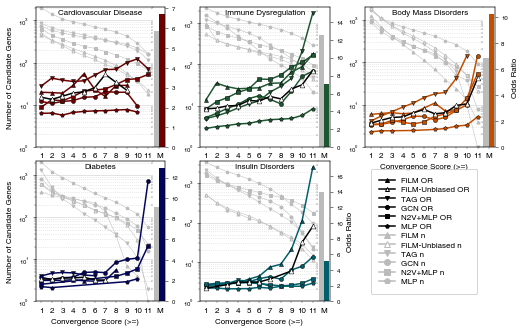

In [3]:
#handler_paths = {"Insulin Disorder": "/home/icb/florin.ratajczak/ppi-core-genes/results/insulin_disorder.h5",
#                 "Monogenic Diabetes": "/home/icb/florin.ratajczak/ppi-core-genes/results/diabetes.h5",
#                 "Bodymass Disorder": "/home/icb/florin.ratajczak/ppi-core-genes/results/bm_disorder3.h5",
#                 "Cardiovascular Disease": "/home/icb/florin.ratajczak/ppi-core-genes/results/cardiovascular5.h5",
#                 "Immune Dysregulation": "/home/icb/florin.ratajczak/ppi-core-genes/results/immune_dysregulation.h5"}

#handler = ResultsHandler(handler_paths[phenotype], read_only=True)
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import pandas as pd

def get_mighty_keys(n, results):
    mighty_keys = []
    for key, value in results[0].items():
        if key != "Total" and value > n:
            mighty_keys.append(key)
    return mighty_keys

def get_OR(n, superset, results, setB):
    from scipy.stats import fisher_exact
    try:
        results = set(get_mighty_keys(n,results))
    except TypeError:
        results = set(results)

    array = pp.make_contingency_table(superset,results,setB)

    odds_ratio, pval = fisher_exact(array)

    return odds_ratio, pval, array

import numpy as np
from statsmodels.stats.multitest import fdrcorrection as fdr

phenotypes = ["Cardiovascular Disease", "Immune Dysregulation", "Body Mass Disorders", "Diabetes", "Insulin Disorders"]
methods = ["film", "film_unbiased", "tag", "gcn", "n2vmlp", "mlp"]
pretty_methods = ["FiLM","FiLM-Unbiased", "TAG", "GCN", "N2V+MLP", "MLP"]

tick_size = small_font
label_size = medium_font
title_size = medium_font

crimson = "#6f0000"
navy = "#02055a"
jungle = "#1e5631"
tan = "#c24e00"
petrol = "#005f6a"
grey = "#bbbbbb"
lightgrey = "#dddddd"
width_ratios = [10, 1]*2
marker_size = 4


outer_dfs_list = []
for frame_idx, phenotype in enumerate(phenotypes):
    if frame_idx == 5:
        break
    dfs = []
    for pretty_method, method in zip(pretty_methods, methods):
        _columns= ["Method", "CS/Mendelian", "N Candidate/Mendelian and MKO", "N Candidate/Mendelian not MKO", "N Not Candidate/Mendelian and MKO", "N Not Candidate/Mendelian Not MKO", "OR", "pval unadjusted", "pval adjusted (FDR)"]
        df = pd.DataFrame(data=np.empty((11, len(_columns))), columns=_columns)

        if method in ["gcn", "mlp", "n2vmlp"] and phenotype == "Immune Dysregulation":
            method += "_new"

        if method == "film" and phenotype == "Immune Dysregulation":
            method += "_forreal"
    
        config_paths = {"Insulin Disorders": "configs/config_insulin_disorder_{}.yaml".format(method),
                        "Diabetes": "configs/config_diabetes_{}.yaml".format(method),
                        "Body Mass Disorders": "configs/config_bm_disorder_{}.yaml".format(method),
                        "Cardiovascular Disease": "configs/config_cardiovascular_{}.yaml".format(method),
                        "Immune Dysregulation": "configs/config_immune_dysregulation_{}.yaml".format(method)}
        
        #if method == "film" and phenotype == "Immune Dysregulation":
        #    config_paths[phenotype] = "configs/config_immune_dysregulation_{}_forreal.yaml".format(method)

        config = Config()
        config.parse_yaml(config_paths[phenotype])

        pp = PostProcessor(config)

        import json

        outer_results_paths = {"Insulin Disorders": "/lustre/groups/epigenereg01/projects/ppi-florin/results/insulin_disorder_{}outer_results.json".format(method),
                        "Diabetes": "/lustre/groups/epigenereg01/projects/ppi-florin/results/diabetes_{}outer_results.json".format(method),
                        "Body Mass Disorders": "/lustre/groups/epigenereg01/projects/ppi-florin/results/bm_disorder_{}outer_results.json".format(method),
                        "Cardiovascular Disease": "/lustre/groups/epigenereg01/projects/ppi-florin/results/cardiovascular_{}outer_results.json".format(method),
                        "Immune Dysregulation": "/lustre/groups/epigenereg01/projects/ppi-florin/results/immune_dysregulation_{}outer_results.json".format(method)}

        with open(outer_results_paths[phenotype], "r") as file:
            results = json.load(file)

        unknown_genes, all_genes, positive_genes = pp.get_unknown_genes(pp.results_paths[0][0])
        if background is None:
            background = set(pp.get_mouse_knockout_background("~/ppi-core-genes/data/mgi/background.txt"))
        valid_background = background.intersection(all_genes)
        print(len(valid_background))
        valid_unlabeled_background = valid_background.intersection(unknown_genes)
                
        mousegenes = set(pp.get_mouse_knockout_genes("~/ppi-core-genes/data/mgi/{}.txt".format(pp.get_doid())))
        valid_mousegenes = pp.return_only_valid(mousegenes, valid_background)
        valid_unlabeled_mousegenes = pp.return_only_valid(mousegenes, valid_unlabeled_background)
        
        #print("{} {}: {} positives".format(phenotype, method, len(positive_genes)))
        groups = []
        ors = []
        pvals = []
        strengths = []
        n_candidates_and_mko = []
        n_candidates_not_mko = []
        n_not_candidates_and_mko = []
        n_not_candidates_not_mko = []

        for i in range(11):
            group = ">= {}".format(i + 1)
            groups.append(group)
            odds_ratio, pval, array = get_OR(i, valid_unlabeled_background, results, valid_unlabeled_mousegenes)
            ors.append(odds_ratio)
            pvals.append(pval)
            strength = len(get_mighty_keys(i, results))
            strengths.append(strength)
            df.loc[i, :] = [pretty_method, "CS "+ group, array[0][0], array[1][0], array[0][1], array[1][1], odds_ratio, pval, None]
            #print("{}: {}, p: {:.2e}, n: {}".format(group, odds_ratio, pval, strength))

        min_strength = np.min(strengths) if np.min(strengths) < min_strength else min_strength
        m_odds_ratio, m_pval, array = get_OR(i, valid_background, set(positive_genes), valid_mousegenes)
        m_strength = len(positive_genes)
        #print("{}: {}, p: {:.2e}, n: {}".format(group, odds_ratio, pval, strength))
        df.loc[11, :] = ["-", "Mendelian", array[0][0], array[1][0], array[0][1], array[1][1], m_odds_ratio, m_pval, None]

        if phenotype == "Cardiovascular Disease" and method == "tag":
            cvd_strengths = strengths
            cvd_ors = ors
            cvd_mendelian_strength = m_strength
            cvd_mendelian_ors = m_odds_ratio

        
        dfs.append(df)
    
    dfs = pd.concat(dfs)
    
    for column in dfs.columns:
        if "OR" in column:
            dfs[column] = dfs[column].round(3)
        if "N " in column:
            dfs[column] = dfs[column].astype(int)
    outer_dfs_list.append(dfs)

pvals = []
for df in outer_dfs_list:
    pvals.extend(df["pval unadjusted"].tolist())


adj_pvals = fdr(pvals)[1]

for df, adj_pval_one_df, phenotype in zip(outer_dfs_list, np.array_split(adj_pvals, len(outer_dfs_list)), phenotypes):
    print((adj_pval_one_df < 0.05).sum())
    df["pval adjusted (FDR)"] = adj_pval_one_df
    print((df["pval adjusted (FDR)"] < 0.05).sum())
    df.to_csv("statistical_dump/{}_ors_mko_unbiased.tsv".format(phenotype), sep="\t", index=False)

fig, axes = plt.subplots(figsize=(full_width*cm,12*cm), nrows=2, ncols=9, sharey=False, gridspec_kw={'width_ratios': [10, 1, 3, 10, 1, 3, 10, 1, 0.1]})
axes = axes.flatten()
colors_ = [crimson, jungle, tan, navy, petrol]
markers = ["^", "^", "v", "o", "s", "p"]


for frame_idx, (phenotype, color, (ax1, ax3, invis_ax), df) in enumerate(zip(phenotypes + ["None"], colors_ + ["None"], np.array_split(axes, 6), outer_dfs_list + ["None"])):
    if frame_idx == 5:
        ax1.axis("off")
        ax3.axis("off")
        invis_ax.axis("off")
        handles = [Line2D([0], [0], color="black", marker=marker, markeredgecolor="black", markerfacecolor="black" if label != "FiLM-Unbiased" else "white", markersize=marker_size, label=label + " OR") for marker, label in zip(markers, pretty_methods)]
        handles.extend([Line2D([0], [0], color=grey, marker=marker, markeredgecolor=grey, markerfacecolor=grey if label != "FiLM-Unbiased" else "white", label=label + " n") for marker, label in zip(markers, pretty_methods)])
        #handles.extend([Patch(facecolor=color, edgecolor='black', label=label) for color, label in zip(colors_, phenotypes)])
        #handles.append([Line2D([0], [0], color=color, marker="s", label=label) for label in phenotypes])
        ax1.legend(handles=handles, loc='center', fontsize=label_size, labelspacing=0.2, borderpad=1)
        break
    
    ax2 = ax1.twinx()
    ax4 = ax3.twinx()
    handles = []
    min_strength = 1000
    dfs = []
    
    start = 0
    stride = 12

    for method_idx, (pretty_method, method, marker) in enumerate(zip(pretty_methods, methods, markers)):
        
        method_df = df[start:start + stride]
        start += stride
        assert method_df["Method"][0] == pretty_method

        groups = method_df["CS/Mendelian"][:-1]
        ors = method_df["OR"]
        adj_pvals = method_df["pval adjusted (FDR)"]
        strengths = np.asarray(method_df["N Candidate/Mendelian and MKO"]) + np.asarray(method_df["N Candidate/Mendelian not MKO"])
        n_candidates_and_mko = method_df["N Candidate/Mendelian and MKO"]
        n_candidates_not_mko = method_df["N Candidate/Mendelian not MKO"]
        n_not_candidates_and_mko = method_df["N Not Candidate/Mendelian and MKO"]
        n_not_candidates_not_mko = method_df["N Not Candidate/Mendelian Not MKO"]
       
        min_strength = np.min(strengths) if np.min(strengths) < min_strength else min_strength

        xind = np.asarray((range(11)))
        width=0.8

        # plot set strengths
        is_positive = np.asarray(strengths[:-1]) > 0
        draw_xind = np.asarray(xind)[is_positive]
        draw_strengths = np.asarray(strengths[:-1])[is_positive]
        ax1.plot(draw_xind, draw_strengths, 
                color=grey,
                zorder=1 if method != "film_unbiased" else 2,
                markeredgecolor=grey, 
                markerfacecolor=grey if method != "film_unbiased" else "white",
                marker=marker,
                linewidth=0.5,
                ms = marker_size-1)
        ax1.set_axisbelow(True)
        ax3.bar(1-(width/2), height=strengths[-1], width=width, color=grey, zorder=1)
        ax3.set_axisbelow(True)
    
        is_significant = np.asarray(adj_pvals[:-1]) < 0.05
        is_enough = np.asarray(strengths[:-1]) > 0
        use_only = is_significant & is_enough
        draw_xind = np.asarray(xind)[use_only]
        draw_ors = np.asarray(ors[:-1])[use_only]
        handle, = ax2.plot(draw_xind, draw_ors, 
                           color=color if method != "film_unbiased" else "black", 
                           zorder=4 if method != "film_unbiased" else 5, 
                           marker=marker, 
                           markeredgecolor="black", 
                           markeredgewidth=0.5,
                           markerfacecolor=color if method != "film_unbiased" else "white",
                           ms=marker_size  if method != "film_unbiased" else 1.2*marker_size, 
                           label=method)
        handles.append(handle)
        ax4.bar(1+(width/2), height=ors.tolist()[-1], width=width, color=color, zorder=1)
        ax4.set_axisbelow(True)
        ax4.set_axisbelow(True)
        ax2.set_axisbelow(True)
        ax2.set_xticks(xind)
        ax2.set_xticklabels(xind.astype(np.uint8) + 1, size=small_font)
        ax3.set_xticks([1])
        ax3.set_xticklabels(["M"], size=label_size)
        if frame_idx % 3 == 0:
            ax1.set_ylabel("Number of Candidate Genes", size=label_size)
        elif frame_idx % 3 == 2:
            ax4.set_ylabel("Odds Ratio", size=label_size)
        
        if frame_idx == 4:
            ax4.set_ylabel("Odds Ratio", size=label_size)
            
        if frame_idx >= 2:
            ax1.set_xlabel("Convergence Score (>=)", size=label_size)

        ax1.set_title(phenotype, y=1.05, x=0.55, pad=-14, size=title_size)


    _, candidate_max_strength = ax1.get_ylim()
    _, mendelian_max_strength = ax3.get_ylim()
    max_strength = np.max((candidate_max_strength, mendelian_max_strength))
    max_strenth = 1000 if max_strength < 1000 else max_strength

    min_strength = 10 if min_strength > 10 else min_strength
    min_strength = 1
    
    ax1.set_yscale('log')
    ax3.set_yscale('log')
    ax1.set_ylim((min_strength, max_strenth))
    ax3.set_ylim((min_strength, max_strenth))
    
    candidate_max_or = ax2.get_ylim()[1]
    mendelian_max_or = ax4.get_ylim()[1]
    ax2.set_ylim((0, np.max((candidate_max_or, mendelian_max_or))))
    ax4.set_ylim((0, np.max((candidate_max_or, mendelian_max_or))))
    ax1.grid(which="major", axis="y", color=lightgrey)
    ax1.grid(which="minor", axis="y", linestyle=":", color=lightgrey)
    ax3.set_yticks([], which="both")
    ax3.spines['left'].set_visible(False)
    ax4.spines['left'].set_visible(False)
    ax2.set_yticks([])
    ax1.spines['right'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax1.tick_params(axis="x", labelsize=label_size)
    invis_ax.set_visible(False)

fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0.1)
plt.savefig("OR_all_unbiased.svg".format(phenotype), dpi=300, bbox_inches='tight')

In [ ]:
import pandas as pd

table =  pd.read_csv("./data/mgi/HOM_MouseHumanSequence.rpt", sep="\t", header=0)

human = table[table["Common Organism Name"] == "human"]
mouse = table[table["Common Organism Name"] == "mouse, laboratory"]
human.index = human["DB Class Key"]
mouse.index = mouse["DB Class Key"]
joined = human.join(mouse, how="inner", lsuffix=" human", rsuffix=" mouse")
print(joined.tail())
mouse2human = {}
doubles = {}
for human, mouse in zip(joined["Symbol human"], joined["Symbol mouse"]):
    if mouse in mouse2human.keys():
        mouse2human[mouse].append(human)
        doubles[mouse] = mouse2human[mouse]
    else:
        mouse2human[mouse] = [human]

print(len(mouse2human))
print(doubles)



In [37]:
mouse_symbols = [entry.split("<")[0] for entry in pd.read_csv("~/ppi-core-genes/data/mgi/background.txt", sep="\t", header=0)["Allele Symbol"].tolist()]

In [40]:
human_background_symbols = set()
for mouse_symbol in mouse_symbols:
    try:
        human_background_symbols.update(mouse2human[mouse_symbol])
    except KeyError:
        continue

print(len(human_background_symbols))

16370


cardiovascular_film 2023-01-03 10:51:31,770 [INFO] speos.postprocessing.postprocessor: Total of 3230 genes with significant LoF Intolerance, 2869 of them match with our translation table.
cardiovascular_film 2023-01-03 10:51:31,770 [INFO] speos.postprocessing.postprocessor: Found 129 LoF Intolerance genes among the 610 known positive genes (p: 2.21e-03, OR: 1.375), leaving 2740 in 16791 Unknowns
cardiovascular_film 2023-01-03 10:51:31,776 [INFO] speos.postprocessing.postprocessor: Fishers Exact Test for genes with significant LoF Intolerance among Predicted Genes. p: 6.93e-01, OR: 0.98
cardiovascular_film 2023-01-03 10:51:31,776 [INFO] speos.postprocessing.postprocessor: LoF Intolerance Confusion Matrix:
[[  634  2106]
 [ 3303 10748]]
cardiovascular_film 2023-01-03 10:51:31,785 [INFO] speos.postprocessing.postprocessor: ANOVA for LoF Z Value in Predicted Genes vs Non-Predicted Genes (Unknowns). p: 1.79e-12, F: 27.094
cardiovascular_film 2023-01-03 10:51:32,115 [INFO] speos.postprocessi

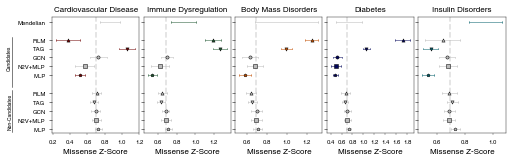

In [17]:
import pandas as pd
from speos.visualization.settings import *
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.lines import Line2D

phenotypes = ["Cardiovascular Disease", "Immune Dysregulation", "Body Mass Disorders", "Diabetes", "Insulin Disorders"]
methods = ["film", "tag", "gcn", "n2vmlp", "mlp"]
pretty_methods = ["FiLM", "TAG", "GCN", "N2V+MLP", "MLP"]
groups = ["Noncandidate Gene", "Candidate Gene", "Mendelian"]
tick_size = small_font
label_size = medium_font

lof_or_missense = 1

crimson = "#6f0000"
navy = "#02055a"
jungle = "#1e5631"
tan = "#c24e00"
petrol = "#005f6a"
grey = "#bbbbbb"
lightgrey = "#dddddd"
width_ratios= [10, 1]*2
marker_size=10
whiskers_length=0.1

fig, axes = plt.subplots(figsize=(full_width*cm,6*cm), ncols=5, sharey=True)
#axes = axes.flatten()
colors_ = [crimson, jungle, tan, navy, petrol]
markers = ["^", "v", "o", "s", "p"]

for phenotype, color_, ax in zip(phenotypes, colors_, axes):
    plot_df_means = pd.DataFrame(columns=pretty_methods, index=groups)
    plot_df_ci = pd.DataFrame(columns=pretty_methods, index=groups)
    dfs = []
    for method, pretty_method in zip(methods, pretty_methods):
        if method in ["gcn", "mlp", "n2vmlp"] and phenotype == "Immune Dysregulation":
            method += "_new"
    
        config_paths = {"Insulin Disorders": "configs/config_insulin_disorder_{}.yaml".format(method),
                        "Diabetes": "configs/config_diabetes_{}.yaml".format(method),
                        "Body Mass Disorders": "configs/config_bm_disorder_{}.yaml".format(method),
                        "Cardiovascular Disease": "configs/config_cardiovascular_{}.yaml".format(method),
                        "Immune Dysregulation": "configs/config_immune_dysregulation_{}.yaml".format(method)}

        if method == "film" and phenotype == "Immune Dysregulation":
            config_paths[phenotype] = "configs/config_immune_dysregulation_{}_forreal.yaml".format(method)

        config = Config()
        config.parse_yaml(config_paths[phenotype])

        pp = PostProcessor(config)

        import json

        outer_results_paths = {"Insulin Disorders": "/lustre/groups/epigenereg01/projects/ppi-florin/results/insulin_disorder_{}outer_results.json".format(method),
                        "Diabetes": "/lustre/groups/epigenereg01/projects/ppi-florin/results/diabetes_{}outer_results.json".format(method),
                        "Body Mass Disorders": "/lustre/groups/epigenereg01/projects/ppi-florin/results/bm_disorder_{}outer_results.json".format(method),
                        "Cardiovascular Disease": "/lustre/groups/epigenereg01/projects/ppi-florin/results/cardiovascular_{}outer_results.json".format(method),
                        "Immune Dysregulation": "/lustre/groups/epigenereg01/projects/ppi-florin/results/immune_dysregulation_{}outer_results.json".format(method)}

                        

        #if method == "film" and phenotype == "Immune Dysregulation":
        #    outer_results_paths[phenotype] = "/lustre/groups/epigenereg01/projects/ppi-florin/results/immune_dysregulation_{}_forrealouter_results.json".format(method)

        results_files = {"Insulin Disorders": "/lustre/groups/epigenereg01/projects/ppi-florin/results/insulin_disorder_{}_outer_0_fold_1.tsv".format(method),
                        "Diabetes": "/lustre/groups/epigenereg01/projects/ppi-florin/results/diabetes_{}_outer_0_fold_1.tsv".format(method),
                        "Body Mass Disorders": "/lustre/groups/epigenereg01/projects/ppi-florin/results/bm_disorder_{}_outer_0_fold_1.tsv".format(method),
                        "Cardiovascular Disease": "/lustre/groups/epigenereg01/projects/ppi-florin/results/cardiovascular_{}_outer_0_fold_1.tsv".format(method),
                        "Immune Dysregulation": "/lustre/groups/epigenereg01/projects/ppi-florin/results/immune_dysregulation_{}_outer_0_fold_1.tsv".format(method)}

        #if method == "film" and phenotype == "Immune Dysregulation":
        #    results_files[phenotype] = "/lustre/groups/epigenereg01/projects/ppi-florin/results/immune_dysregulation_{}_forreal_outer_0_fold_1.tsv".format(method)

        with open(outer_results_paths[phenotype], "r") as file:
            results = json.load(file)
        pp.outer_result = results
        pp.init_pp_table()
        lof, tukey = pp.lof_intolerance(results_files[phenotype], plot=False)
        df = pd.read_html(tukey[lof_or_missense].summary().as_html(), header=0, index_col=0)[0]
        df["p-adj"] = tukey[lof_or_missense].pvalues
        if getattr(tukey[lof_or_missense], 'halfwidths', None) is None:
            tukey[lof_or_missense]._simultaneous_ci()
        

        group_names = tukey[lof_or_missense].groupsunique
        means = tukey[lof_or_missense]._multicomp.groupstats.groupmean
        cis = tukey[lof_or_missense].halfwidths

        for group, mean, ci in zip(group_names, means, cis):
            plot_df_means.loc[group, pretty_method] = mean
            plot_df_ci.loc[group, pretty_method] = ci

        df.reset_index(inplace=True)
        df["Group Name"] = group_names
        df["Group N"] = [(np.asarray(tukey[lof_or_missense].groups) == group).sum() for group in group_names]
        df["Group Mean"] = means
        df["Lower 95% CI"] = np.asarray(means) - np.asarray(ci)
        df["Upper 95% CI"] = np.asarray(means) + np.asarray(ci)
        df[" "] = [" "] * len(df.index)
        df_columns = df.columns[-6:].tolist() + df.columns[:-6].tolist()
        df = df[df_columns]
        dfs.append(df)
    
    dfs_joined = pd.concat(dfs, keys=pretty_methods)
    dfs_joined.reset_index(inplace=True)
    dfs_joined.columns =  ["Method"] + dfs_joined.columns[1:].tolist()
    dfs_joined.drop("level_1", axis="columns", inplace=True)
    dfs_joined.to_csv("statistical_dump/{}_tukey_{}.tsv".format(phenotype, "lof" if lof_or_missense == 0 else "missense"), sep="\t", index=False)    

    max_comparisons = ((len(groups) - 1) * len(methods)) + 1 + 2

    ax.vlines(x=np.mean(tukey[lof_or_missense].data), ymin=0.5, ymax = max_comparisons + 0.5, linestyles=["--"], color=lightgrey, zorder=-10)
    ax.set_ylim((0.5, max_comparisons + 0.5))
    
    for group in groups[::-1]:
        for method, marker, df in zip(pretty_methods, markers, dfs):

            if group == "Noncandidate Gene":
                color = grey
            else:
                """
                nc_mean = plot_df_means.loc["Noncandidate Gene", method]
                nc_ci = plot_df_ci.loc["Noncandidate Gene", method]
                group_mean = plot_df_means.loc[group, method]
                group_ci = plot_df_ci.loc[group, method]
                big_enough = (nc_mean + nc_ci) < (group_mean - group_ci)
                small_enough = (nc_mean - nc_ci) > (group_mean + group_ci)
                
                if big_enough or small_enough:
                    color = color_

                """
                if df.loc[(df["group1"] == group) & (df["group2"] == "Noncandidate Gene"), "p-adj"].item() < 0.05:
                    color = color_
                else:
                    color = grey

            
            # draw Confidence Interval
            ax.plot((plot_df_means.loc[group, method] - plot_df_ci.loc[group, method], plot_df_means.loc[group, method] + plot_df_ci.loc[group, method]),
                    (max_comparisons, max_comparisons),
                     color=color,
                     linewidth=0.5)
            
            
            # draw Whiskers
            ax.plot((plot_df_means.loc[group, method] - plot_df_ci.loc[group, method], plot_df_means.loc[group, method] - plot_df_ci.loc[group, method]),
                    (max_comparisons + whiskers_length, max_comparisons - whiskers_length),
                     color=color,
                     linewidth=0.5)
            ax.plot((plot_df_means.loc[group, method] + plot_df_ci.loc[group, method], plot_df_means.loc[group, method] + plot_df_ci.loc[group, method]),
                    (max_comparisons + whiskers_length, max_comparisons - whiskers_length),
                     color=color,
                     linewidth=0.5)

            if group != "Mendelian":
                ax.scatter(plot_df_means.loc[group, method], max_comparisons, color=color, marker=marker, s=marker_size, linewidth=0.5, edgecolors='black', zorder=5)
            max_comparisons -= 1

            if group == "Mendelian":
                break

        max_comparisons -= 1
    
    label = ["LoF Z-Score", "Missense Z-Score"][lof_or_missense]

    ax.set_xlabel(label, size=label_size)
    ax.set_title(phenotype, size=label_size)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))

ticks = [1,2,3,4,5,  7,8,9,10,11, 13]
names = (pretty_methods[::-1] * 2) + ["Mendelian"]

axes[0].set_yticks(ticks)
axes[0].set_yticklabels(names, size=label_size-2)

ticks = [9, 3]
names = ["Candidates", "Non-Candidates"]

if lof_or_missense == 1:
    x = -0.28
    offset = 0.05
else:
    x = 1.26
    offset = 0.1

axes[0].text(x=x-offset,y=ticks[0], s=names[0], rotation=90, va="center", size=small_font-1)
axes[0].text(x=x-offset,y=ticks[1], s=names[1], rotation=90, va="center", size=small_font-1)

line = Line2D((x, x), (0.7,5.3), color="black", linewidth=0.5)
line.set_clip_on(False)
axes[0].add_line(line)
line = Line2D((x, x), (5.7,11.3), color="black", linewidth=0.5)
line.set_clip_on(False)
axes[0].add_line(line)
plt.tight_layout()
plt.subplots_adjust(wspace=0.05)
if lof_or_missense == 0:
    plt.savefig("lof_all.svg")
else:
    plt.savefig("missense_all.svg")

                

In [9]:
tukey[0].summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Candidate Gene,Mendelian,0.2289,0.0194,0.0297,0.4281,True
Candidate Gene,Noncandidate Gene,-0.2037,0.0,-0.289,-0.1185,True
Mendelian,Noncandidate Gene,-0.4326,0.0,-0.6222,-0.2431,True


In [7]:
tukey[0].pvalues

array([1.94186450e-02, 6.39911070e-08, 2.66249798e-07])

In [2]:
import matplotlib.pyplot as plt
from speos.scripts.utils import fdr

# Drug Target Analysis

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
#os.chdir("~/ppi-core-genes/")
phenotypes = ["Cardiovascular Disease", "Immune Dysregulation", "Body Mass Disorders", "Diabetes", "Insulin Disorders"]
methods = ["film", "tag", "gcn", "n2vmlp", "mlp"]
pretty_methods = ["FiLM", "TAG", "GCN", "N2V+MLP", "MLP"]
groups = ["Noncandidate Gene", "Candidate Gene", "Mendelian"]
categories = ["DT", "#DC", "Dr", "Dr-"]
tick_size = 12
label_size = 14
#from speos.scripts.utils import fdr
from statsmodels.stats.multitest import fdrcorrection as fdr
crimson = "#6f0000"
navy = "#02055a"
jungle = "#1e5631"
tan = "#c24e00"
petrol = "#005f6a"
grey = "#bbbbbb"
lightgrey = "#dddddd"
width_ratios= [10, 1]*2
marker_size=10

#fig, axes = plt.subplots(figsize=(15,6), ncols=5, sharey=True)
#axes = axes.flatten()
colors_ = [crimson, jungle, tan, navy, petrol]

results_dict_values = {}
results_dict_pvals = {}
outer_dfs =  []
for phenotype in phenotypes:
    plot_df_values = pd.DataFrame(columns=categories, index=["Mendelians"] + pretty_methods)
    plot_df_pvals = pd.DataFrame(columns=categories, index=["Mendelians"] + pretty_methods)
    need_to_set_mendelians = True
    dfs = []
    for method, pretty_method in zip(methods, pretty_methods):

        if method in ["gcn", "mlp", "n2vmlp"] and phenotype == "Immune Dysregulation":
            method += "_new"
    
        config_paths = {"Insulin Disorders": "configs/config_insulin_disorder_{}.yaml".format(method),
                        "Diabetes": "configs/config_diabetes_{}.yaml".format(method),
                        "Body Mass Disorders": "configs/config_bm_disorder_{}.yaml".format(method),
                        "Cardiovascular Disease": "configs/config_cardiovascular_{}.yaml".format(method),
                        "Immune Dysregulation": "configs/config_immune_dysregulation_{}.yaml".format(method)}

        if method == "film" and phenotype == "Immune Dysregulation":
            config_paths[phenotype] = "configs/config_immune_dysregulation_{}_forreal.yaml".format(method)

        config = Config()
        config.parse_yaml(config_paths[phenotype])

        pp = PostProcessor(config)

        import json

        outer_results_paths = {"Insulin Disorders": "/lustre/groups/epigenereg01/projects/ppi-florin/results/insulin_disorder_{}outer_results.json".format(method),
                        "Diabetes": "/lustre/groups/epigenereg01/projects/ppi-florin/results/diabetes_{}outer_results.json".format(method),
                        "Body Mass Disorders": "/lustre/groups/epigenereg01/projects/ppi-florin/results/bm_disorder_{}outer_results.json".format(method),
                        "Cardiovascular Disease": "/lustre/groups/epigenereg01/projects/ppi-florin/results/cardiovascular_{}outer_results.json".format(method),
                        "Immune Dysregulation": "/lustre/groups/epigenereg01/projects/ppi-florin/results/immune_dysregulation_{}outer_results.json".format(method)}

                        

        if method == "film" and phenotype == "Immune Dysregulation":
            outer_results_paths[phenotype] = "/lustre/groups/epigenereg01/projects/ppi-florin/results/immune_dysregulation_{}_forrealouter_results.json".format(method)

        results_files = {"Insulin Disorders": "/lustre/groups/epigenereg01/projects/ppi-florin/results/insulin_disorder_{}_outer_0_fold_1.tsv".format(method),
                        "Diabetes": "/lustre/groups/epigenereg01/projects/ppi-florin/results/diabetes_{}_outer_0_fold_1.tsv".format(method),
                        "Body Mass Disorders": "/lustre/groups/epigenereg01/projects/ppi-florin/results/bm_disorder_{}_outer_0_fold_1.tsv".format(method),
                        "Cardiovascular Disease": "/lustre/groups/epigenereg01/projects/ppi-florin/results/cardiovascular_{}_outer_0_fold_1.tsv".format(method),
                        "Immune Dysregulation": "/lustre/groups/epigenereg01/projects/ppi-florin/results/immune_dysregulation_{}_outer_0_fold_1.tsv".format(method)}

        if method == "film" and phenotype == "Immune Dysregulation":
            results_files[phenotype] = "/lustre/groups/epigenereg01/projects/ppi-florin/results/immune_dysregulation_{}_forreal_outer_0_fold_1.tsv".format(method)

        with open(outer_results_paths[phenotype], "r") as file:
            results = json.load(file)
        pp.outer_result = results
        pp.init_pp_table()
        drug_target_results, pvals, (not_predicted_degrees, predicted_degrees, positive_degrees), df = pp.drugtarget(results_files[phenotype], plot=False)
        
        total_druggable, leftover_druggable, df2 = pp.druggable(results_files[phenotype])
        df2.columns = [cname + " " if cname in ["Group Name", "Group N"] else cname for cname in df2.columns]
        df["  "] = [" "] * 3
        df = pd.concat([df, df2], axis=1, join="inner", )
        dfs.append(df)

        if need_to_set_mendelians:
            plot_df_values.loc["Mendelians", "DT"] = drug_target_results[0][0]
            plot_df_pvals.loc["Mendelians", "DT"] = drug_target_results[0][1]
            plot_df_values.loc["Mendelians", "Dr"] = total_druggable[0][0]
            plot_df_pvals.loc["Mendelians", "Dr"] = total_druggable[0][1]
            plot_df_values.loc["Mendelians", "Dr-"] = leftover_druggable[0][0]
            plot_df_pvals.loc["Mendelians", "Dr-"] = leftover_druggable[0][1]
            plot_df_values.loc["Mendelians", "#DC"] = np.median(positive_degrees) / np.median(not_predicted_degrees)
            plot_df_pvals.loc["Mendelians", "#DC"] = pvals[1]
            need_to_set_mendelians = False

        plot_df_values.loc[pretty_method, "DT"] = drug_target_results[1][0]
        plot_df_pvals.loc[pretty_method, "DT"] = drug_target_results[1][1]
        plot_df_values.loc[pretty_method, "Dr"] = total_druggable[1][0]
        plot_df_pvals.loc[pretty_method, "Dr"] = total_druggable[1][1]
        plot_df_values.loc[pretty_method, "Dr-"] = leftover_druggable[1][0]
        plot_df_pvals.loc[pretty_method, "Dr-"] = leftover_druggable[1][1]
        plot_df_values.loc[pretty_method, "#DC"] = np.median(predicted_degrees) / np.median(not_predicted_degrees)
        plot_df_pvals.loc[pretty_method, "#DC"] = pvals[0]

    dfs = pd.concat(dfs, keys = pretty_methods)
    dfs.reset_index(inplace=True)
    dfs.drop("level_1", inplace=True, axis="columns")
    dfs.columns = ["Method"] + dfs.columns[1:].tolist()

    for column in dfs.columns:
        if "OR" in column:
            dfs[column] = dfs[column].round(3)
        if "N " in column:
            dfs[column] = dfs[column].astype(int)
    outer_dfs.append(dfs)
    results_dict_values.update({phenotype: plot_df_values})
    results_dict_pvals.update({phenotype: plot_df_pvals})
    #dfs.loc[~np.isnan(dfs["pval DT unadjusted"]), "pval DT adjusted (FDR)"] = fdr(dfs["pval DT unadjusted"][~np.isnan(dfs["pval DT unadjusted"])])[1]
    #dfs.loc["pval xDC adjusted (FDR)"] = pd.Series(fdr(dfs["pval xDC unadjusted"])[1])
    #dfs.loc[~np.isnan(dfs["pval Dr unadjusted"]), "pval Dr adjusted (FDR)"] = fdr(dfs["pval Dr unadjusted"][~np.isnan(dfs["pval Dr unadjusted"])])[1]
    #dfs.loc[~np.isnan(dfs["pval Dr- unadjusted"]), "pval Dr- adjusted (FDR)"] = fdr(dfs["pval Dr- unadjusted"][~np.isnan(dfs["pval Dr- unadjusted"])])[1]
    #dfs.to_csv("statistical_dump/{}_drugtarget.tsv".format(phenotype), sep="\t", index=False)

dt_pvals = []
xdc_pvals = []
dr_pvals = []
drminus_pvals = []

for df in outer_dfs:
    dt_pvals.extend(df["pval DT unadjusted"][~np.isnan(df["pval DT unadjusted"])].tolist())
    xdc_pvals.extend(df["pval xDC unadjusted"].tolist())
    dr_pvals.extend(df["pval Dr unadjusted"][~np.isnan(df["pval Dr unadjusted"])].tolist())
    drminus_pvals.extend(df["pval Dr- unadjusted"][~np.isnan(df["pval Dr- unadjusted"])].tolist())

dt_pvals_adjusted = fdr(dt_pvals)[1]
xdc_pvals_adjusted = fdr(xdc_pvals)[1]
dr_pvals_adjusted = fdr(dr_pvals)[1]
drminus_pvals_adjusted = fdr(drminus_pvals)[1]

n_dfs = len(outer_dfs)

for df, df_dt_pvals_adj, df_xdc_pvals_adj, df_dr_pvals_adj, drminus_pvals_adj, phenotype in \
    zip(outer_dfs,  np.array_split(dt_pvals_adjusted, n_dfs), np.array_split(xdc_pvals_adjusted, n_dfs), \
    np.array_split(dr_pvals_adjusted, n_dfs), np.array_split(drminus_pvals_adjusted, n_dfs), phenotypes):

    df.loc[~np.isnan(df["pval DT unadjusted"]), "pval DT adjusted (FDR)"] = df_dt_pvals_adj
    df["pval xDC adjusted (FDR)"] = df_xdc_pvals_adj
    df.loc[~np.isnan(df["pval Dr unadjusted"]), "pval Dr adjusted (FDR)"] = df_dr_pvals_adj
    df.loc[~np.isnan(df["pval Dr- unadjusted"]), "pval Dr- adjusted (FDR)"] = drminus_pvals_adj
    df.to_csv("statistical_dump/{}_drugtarget.tsv".format(phenotype), sep="\t", index=False)
    plot_df_pvals = results_dict_pvals[phenotype].copy()
    need_to_set_mendelians = True
    for method in pretty_methods:
        if need_to_set_mendelians:
            plot_df_pvals.loc["Mendelians", "DT"] = df.loc[(df["Method"] == method) & (df["Group Name"] == "Mendelian"), ["pval DT adjusted (FDR)"]].values
            plot_df_pvals.loc["Mendelians", "#DC"] = df.loc[(df["Method"] == method) & (df["Group Name"] == "Mendelian"), ["pval xDC adjusted (FDR)"]].values
            plot_df_pvals.loc["Mendelians", "Dr"] = df.loc[(df["Method"] == method) & (df["Group Name"] == "Mendelian"), ["pval Dr adjusted (FDR)"]].values
            plot_df_pvals.loc["Mendelians", "Dr-"] = df.loc[(df["Method"] == method) & (df["Group Name"] == "Mendelian"), ["pval Dr- adjusted (FDR)"]].values
            need_to_set_mendelians = False

        plot_df_pvals.loc[method, "DT"] = df.loc[(df["Method"] == method) & (df["Group Name"] == "Candidate Gene"), ["pval DT adjusted (FDR)"]].values
        plot_df_pvals.loc[method, "#DC"] = df.loc[(df["Method"] == method) & (df["Group Name"] == "Candidate Gene"), ["pval xDC adjusted (FDR)"]].values
        plot_df_pvals.loc[method, "Dr"] = df.loc[(df["Method"] == method) & (df["Group Name"] == "Candidate Gene"), ["pval Dr adjusted (FDR)"]].values
        plot_df_pvals.loc[method, "Dr-"] = df.loc[(df["Method"] == method) & (df["Group Name"] == "Candidate Gene"), ["pval Dr- adjusted (FDR)"]].values
    
    results_dict_pvals.update({phenotype: plot_df_pvals})

print(results_dict_values['Cardiovascular Disease'])

cardiovascular_film 2023-01-04 14:24:04,599 [INFO] speos.postprocessing.postprocessor: Reading compound drug interaction graph from ~/ppi-core-genes/data/drkg/cgi.tsv
cardiovascular_film 2023-01-04 14:24:05,629 [INFO] speos.postprocessing.postprocessor: Reading translation table from ./data/hgnc_official_list.tsv
cardiovascular_film 2023-01-04 14:24:06,132 [INFO] speos.postprocessing.postprocessor: Total of 8888 drug targets, 8401 of them match with our translation table.
cardiovascular_film 2023-01-04 14:24:06,132 [INFO] speos.postprocessing.postprocessor: Found 510 drug targets genes among the 610 known positive genes (p: 4.69e-76, OR: 5.752), leaving 7891 in 16791 Unknowns
cardiovascular_film 2023-01-04 14:24:06,249 [INFO] speos.postprocessing.postprocessor: Fishers Exact Test for Drug Targets among Predicted Genes. p: 6.81e-63, OR: 1.848
cardiovascular_film 2023-01-04 14:24:06,249 [INFO] speos.postprocessing.postprocessor: Drug Targets Confusion Matrix:
[[2309 5582]
 [1628 7272]]
c

                  DT   #DC        Dr       Dr-
Mendelians  4.650824   2.5  2.028791  0.821587
FiLM        3.549776   2.0  2.094156  1.096855
TAG         5.933568  2.25  2.415599  1.616936
GCN         4.352344   1.5  1.841789  1.229857
N2V+MLP       2.7486   2.0  1.856836  1.306803
MLP         1.855089  1.25   1.27508  0.846812


In [29]:
results_dict_pvals['Immune Dysregulation']

,DT,#DC,Dr,Dr-
Mendelians,[[1.8958735600736387e-61]],[[0.006550013759189438]],[[4.8051151102302566e-35]],[[0.8191483766547755]]
FiLM,[[4.261969201409352e-60]],[[2.043131720969128e-33]],[[1.4426570587579445e-13]],[[0.2457125159481471]]
TAG,[[8.105064698949636e-139]],[[9.84440758940445e-36]],[[4.749909695406286e-41]],[[0.014354890757769842]]
GCN,[[1.1737431264575511e-51]],[[2.5930623832861265e-32]],[[8.21011504549936e-32]],[[0.24615184047973818]]
N2V+MLP,[[2.0066753555158476e-36]],[[2.2584794728343943e-31]],[[2.879476510683238e-48]],[[4.429367407580261e-06]]
MLP,[[6.150289396847723e-13]],[[3.5300218520274668e-31]],[[3.354495165458333e-21]],[[0.04649913137923159]]


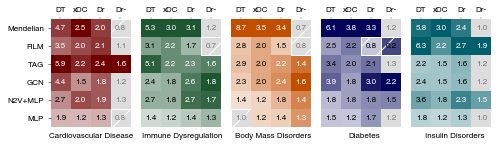

In [19]:
def colorFader(c1="#000000", c2="#ffffff", mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    import matplotlib as mpl
    import numpy as np
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

def plot_results(ors, pvals = None, need_transpose = True, pval_cutoff=0.05, adjust = False, extra_height = 2, rotate_xlabels=True):
    """ ors and pvals are dicts which contain one df per disease. dfs have n_methods rows and n_disease_subtypes columns """
    import numpy as np
    #from speos.scripts.utils import fdr
    from statsmodels.stats.multitest import fdrcorrection as fdr
    border_size = 0.01
    regular_height = 1
    break_height = 0.5
    break_width = 0.5
    regular_width = 1 - border_size
    value_font_size = medium_font
    label_font_size = medium_font
    
    crimson = "#6f0000"
    navy = "#02055a"
    jungle = "#1e5631"
    tan = "#c24e00"
    petrol = "#005f6a"
    purple = "#3c1361"
    grey = "#bbbbbb"

    color_gradients = []
    for colors in [crimson, jungle, tan, navy, petrol]:
        color_gradients.append({x: colorFader(c1 = colors, mix = ((100-x)/100) * 0.85 ) for x in range(101)})

    grey_gradient = {x: colorFader(c1 = grey, mix = ((100-x)/100) * 0.85 ) for x in range(101)}

    outer_labels = list(ors.keys())
    diseases = []
    one_large_df = None
    dfs = []
    main_diseases = []

    for i, (disease, df) in enumerate(ors.items()):
        if need_transpose:
            df = df.transpose()
        for subtype in df.columns:
            main_diseases.append((i, disease))
        diseases.extend(list(df.columns) + ["break"])
        methods = df.index.tolist()[::-1]
        dfs.append(df)

    pval_dfs = []
    for i, (disease, df) in enumerate(pvals.items()):
        if need_transpose:
            df = df.transpose()
        pval_dfs.append(df)

    one_large_df = pd.concat(dfs, axis=1)
    pval_df = pd.concat(pval_dfs, axis=1)

    # remove last break
    diseases = diseases[:-1]
    
    #fig, ax = plt.subplots(figsize=(0.7*len(diseases), (0.7*len(methods)) + extra_height))
    fig, ax = plt.subplots(figsize=(full_width*cm, (full_width*cm / 3.3)))
    
    diseases_without_breaks = [label for label in diseases if label != "break"]

    values = one_large_df.values
    pvals = pval_df.values
    if adjust:
        pvals_shape = pvals.shape
        pvals = fdr(pvals.flatten())[1].reshape(pvals_shape)
    
    all_main_diseases = main_diseases[:]
    for i, index in enumerate(methods):
        main_diseases = all_main_diseases[:]
        running_index = 0
        for c, column in enumerate(diseases):
                
            
            height = break_height if index == "break" else regular_height
            width = break_width if column == "break" else regular_width

            #minmax_means = (df[:,k] - np.min(df[:,k])) / (np.max(df[:,k]) - np.min(df[:,k]))
            kwargs = {}
            if "break" in [index, column]:
                color = "w"
            else:
                main_disease = main_diseases[0]
                main_diseases.remove(main_disease)

                value_disease_index = running_index
                minmax_means = (values[:, value_disease_index] - 1) / (np.max(values[:, value_disease_index]) - 1)
                if pvals[methods[::-1].index(index), value_disease_index] > pval_cutoff:
                    #colors = grey_gradient
                    color = "#dddddd"
                    significant = False
                else:
                    colors = color_gradients[main_disease[0]]
                    color = colors[abs(int(100 * minmax_means[methods[::-1].index(index)]))]
                    significant = True

                
                if values[methods[::-1].index(index), value_disease_index] < 1:
                    kwargs.update({"edgecolor": 'white', "hatch": "/"})
                

            bottom = np.sum([break_height if _method == "break" else regular_height for _method in methods[:i]])

            x_position = np.sum([break_width if _disease == "break" else regular_width for _disease in diseases[:c]])

            ax.bar(x_position, height=height - border_size, bottom=bottom,
                                color=color, width=width, **kwargs)
                
            
            if not "break" in [index, column]:
                if significant:
                    color = "w" if minmax_means[methods[::-1].index(index)] > 0.5 else "black"
                else: 
                    color = "#777777"
                text = str(round(values[methods[::-1].index(index), value_disease_index], 1))
                            
                ax.text(x_position, bottom + (0.5*height), text, ha='center',va='center',
                                    size=value_font_size, color=color)
                #weight='bold'
            if column != "break":
                running_index += 1

    yticks = []
    for index in range(len(methods)):
        yticks.append(np.sum([break_height if label == "break" else regular_height for label in methods[:index + 1]]) - 0.5)

    xticks = []
    for index in range(len(diseases)):
        xticks.append(np.sum([break_width if label == "break" else regular_width for label in diseases[:index + 1]]) - 1)

    #ax.set_title(" ".join([word.capitalize() if word not in abbreviations.keys() else abbreviations[word] for word in df.columns[j].split("_")]))
    ax.set_yticks(np.asarray(yticks)[np.asarray([label != "break" for label in methods], dtype = np.bool8)])
    methods = ["Mendelian" if label == "Mendelians" else label for label in methods]
    ax.set_yticklabels([label for label in methods if label != "break"], size=label_font_size)
    ax2 = ax.twiny()
    diseases = ["xDC" if disease == "#DC" else disease for disease in diseases]
    ax.set_xticks(np.asarray(xticks)[np.asarray([label != "break" for label in diseases], dtype = np.bool8)])
    ax.set_xticklabels([label for label in diseases if label != "break"], ha="center", rotation=90 if rotate_xlabels else 0, size=label_font_size)


    ax2.set_xticks([1.5, 6, 10.5, 15, 19.5])
    ax2.set_xticklabels(outer_labels, size=label_font_size)

    #for location, text in zip([2.5, 8.5, 13.5, 17, 21], outer_labels):
    #    ax.text(location, 9, text, ha='center', va="center", size=14)

    ax.xaxis.set_ticks_position('top')
    ax2.xaxis.set_ticks_position('bottom')

    for axe in [ax, ax2]:
        axe.spines['top'].set_visible(False)
        axe.spines['right'].set_visible(False)
        axe.spines['bottom'].set_visible(False)
        axe.spines['left'].set_visible(False)
    ax.set_ylim((0, np.sum([break_height if _method == "break" else regular_height for _method in methods]) - border_size))
    ax.set_xlim((- width/2, len(diseases) - ((width/2) ) - 2*width))
    ax2.set_xlim((- width/2, len(diseases) - ((width/2) ) - 2*width))
    
    plt.tick_params(bottom = False)
    plt.tight_layout()
    return fig, ax

plot_results(results_dict_values, results_dict_pvals, need_transpose=False, extra_height=0, rotate_xlabels=False)

plt.savefig("drug_all.svg", bbox_inches="tight", transparent=False)

# Now Unbiased

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
#os.chdir("~/ppi-core-genes/")
phenotypes = ["Cardiovascular Disease", "Immune Dysregulation", "Body Mass Disorders", "Diabetes", "Insulin Disorders"]
methods = ["film", "film_unbiased", "tag", "gcn", "n2vmlp", "mlp"]
pretty_methods = ["FiLM", "FiLM-Unbiased", "TAG", "GCN", "N2V+MLP", "MLP"]
groups = ["Noncandidate Gene", "Candidate Gene", "Mendelian"]
categories = ["DT", "xDC", "Dr", "Dr-"]
tick_size = 12
label_size = 14

crimson = "#6f0000"
navy = "#02055a"
jungle = "#1e5631"
tan = "#c24e00"
petrol = "#005f6a"
grey = "#bbbbbb"
lightgrey = "#dddddd"
width_ratios= [10, 1]*2
marker_size=10

#fig, axes = plt.subplots(figsize=(15,6), ncols=5, sharey=True)
#axes = axes.flatten()
colors_ = [crimson, jungle, tan, navy, petrol]

results_dict_values = {}
results_dict_pvals = {}
outer_dfs = []
for phenotype in phenotypes:
    plot_df_values = pd.DataFrame(columns=categories, index=["Mendelians"] + pretty_methods)
    plot_df_pvals = pd.DataFrame(columns=categories, index=["Mendelians"] + pretty_methods)
    need_to_set_mendelians = True
    dfs = []
    for method, pretty_method in zip(methods, pretty_methods):
        if method in ["gcn", "mlp", "n2vmlp"] and phenotype == "Immune Dysregulation":
            method += "_new"
    
        config_paths = {"Insulin Disorders": "configs/config_insulin_disorder_{}.yaml".format(method),
                        "Diabetes": "configs/config_diabetes_{}.yaml".format(method),
                        "Body Mass Disorders": "configs/config_bm_disorder_{}.yaml".format(method),
                        "Cardiovascular Disease": "configs/config_cardiovascular_{}.yaml".format(method),
                        "Immune Dysregulation": "configs/config_immune_dysregulation_{}.yaml".format(method)}

        if method == "film" and phenotype == "Immune Dysregulation":
            config_paths[phenotype] = "configs/config_immune_dysregulation_{}_forreal.yaml".format(method)

        config = Config()
        config.parse_yaml(config_paths[phenotype])

        pp = PostProcessor(config)

        import json

        outer_results_paths = {"Insulin Disorders": "/lustre/groups/epigenereg01/projects/ppi-florin/results/insulin_disorder_{}outer_results.json".format(method),
                        "Diabetes": "/lustre/groups/epigenereg01/projects/ppi-florin/results/diabetes_{}outer_results.json".format(method),
                        "Body Mass Disorders": "/lustre/groups/epigenereg01/projects/ppi-florin/results/bm_disorder_{}outer_results.json".format(method),
                        "Cardiovascular Disease": "/lustre/groups/epigenereg01/projects/ppi-florin/results/cardiovascular_{}outer_results.json".format(method),
                        "Immune Dysregulation": "/lustre/groups/epigenereg01/projects/ppi-florin/results/immune_dysregulation_{}outer_results.json".format(method)}

                        

        if method == "film" and phenotype == "Immune Dysregulation":
            outer_results_paths[phenotype] = "/lustre/groups/epigenereg01/projects/ppi-florin/results/immune_dysregulation_{}_forrealouter_results.json".format(method)

        results_files = {"Insulin Disorders": "/lustre/groups/epigenereg01/projects/ppi-florin/results/insulin_disorder_{}_outer_0_fold_1.tsv".format(method),
                        "Diabetes": "/lustre/groups/epigenereg01/projects/ppi-florin/results/diabetes_{}_outer_0_fold_1.tsv".format(method),
                        "Body Mass Disorders": "/lustre/groups/epigenereg01/projects/ppi-florin/results/bm_disorder_{}_outer_0_fold_1.tsv".format(method),
                        "Cardiovascular Disease": "/lustre/groups/epigenereg01/projects/ppi-florin/results/cardiovascular_{}_outer_0_fold_1.tsv".format(method),
                        "Immune Dysregulation": "/lustre/groups/epigenereg01/projects/ppi-florin/results/immune_dysregulation_{}_outer_0_fold_1.tsv".format(method)}

        if method == "film" and phenotype == "Immune Dysregulation":
            results_files[phenotype] = "/lustre/groups/epigenereg01/projects/ppi-florin/results/immune_dysregulation_{}_forreal_outer_0_fold_1.tsv".format(method)

        with open(outer_results_paths[phenotype], "r") as file:
            results = json.load(file)
        pp.outer_result = results
        pp.init_pp_table()
        drug_target_results, pvals, (not_predicted_degrees, predicted_degrees, positive_degrees), df = pp.drugtarget(results_files[phenotype], plot=False)

        total_druggable, leftover_druggable, df2 = pp.druggable(results_files[phenotype])
        df2.columns = [cname + " " if cname in ["Group Name", "Group N"] else cname for cname in df2.columns]
        df["  "] = [" "] * 3
        df = pd.concat([df, df2], axis=1, join="inner")
        dfs.append(df)

        if need_to_set_mendelians:
            plot_df_values.loc["Mendelians", "DT"] = drug_target_results[0][0]
            plot_df_pvals.loc["Mendelians", "DT"] = drug_target_results[0][1]
            plot_df_values.loc["Mendelians", "Dr"] = total_druggable[0][0]
            plot_df_pvals.loc["Mendelians", "Dr"] = total_druggable[0][1]
            plot_df_values.loc["Mendelians", "Dr-"] = leftover_druggable[0][0]
            plot_df_pvals.loc["Mendelians", "Dr-"] = leftover_druggable[0][1]
            plot_df_values.loc["Mendelians", "xDC"] = np.median(positive_degrees) / np.median(not_predicted_degrees)
            plot_df_pvals.loc["Mendelians", "xDC"] = pvals[1]
            need_to_set_mendelians = False

        plot_df_values.loc[pretty_method, "DT"] = drug_target_results[1][0]
        plot_df_pvals.loc[pretty_method, "DT"] = drug_target_results[1][1]
        plot_df_values.loc[pretty_method, "Dr"] = total_druggable[1][0]
        plot_df_pvals.loc[pretty_method, "Dr"] = total_druggable[1][1]
        plot_df_values.loc[pretty_method, "Dr-"] = leftover_druggable[1][0]
        plot_df_pvals.loc[pretty_method, "Dr-"] = leftover_druggable[1][1]
        plot_df_values.loc[pretty_method, "xDC"] = np.median(predicted_degrees) / np.median(not_predicted_degrees)
        plot_df_pvals.loc[pretty_method, "xDC"] = pvals[0]
    

    dfs = pd.concat(dfs, keys = pretty_methods)
    dfs.reset_index(inplace=True)
    dfs.drop("level_1", inplace=True, axis="columns")
    dfs.columns = ["Method"] + dfs.columns[1:].tolist()
    for column in dfs.columns:
        if "OR" in column:
            dfs[column] = dfs[column].round(3)
        if "N " in column:
            dfs[column] = dfs[column].astype(int)
    #dfs.loc[~np.isnan(dfs["pval DT unadjusted"]), "pval DT adjusted (FDR)"] = fdr(dfs["pval DT unadjusted"][~np.isnan(dfs["pval DT unadjusted"])])[1]
    #dfs.loc["pval xDC adjusted (FDR)"] = pd.Series(fdr(dfs["pval xDC unadjusted"])[1])
    #dfs.loc[~np.isnan(dfs["pval Dr unadjusted"]), "pval Dr adjusted (FDR)"] = fdr(dfs["pval Dr unadjusted"][~np.isnan(dfs["pval Dr unadjusted"])])[1]
    #dfs.loc[~np.isnan(dfs["pval Dr- unadjusted"]), "pval Dr- adjusted (FDR)"] = fdr(dfs["pval Dr- unadjusted"][~np.isnan(dfs["pval Dr- unadjusted"])])[1]
    #dfs.to_csv("statistical_dump/{}_drugtarget_unbiased.tsv".format(phenotype), sep="\t", index=False)
    outer_dfs.append(dfs)
    results_dict_values.update({phenotype: plot_df_values})
    results_dict_pvals.update({phenotype: plot_df_pvals})


dt_pvals = []
xdc_pvals = []
dr_pvals = []
drminus_pvals = []



for df in outer_dfs:
    dt_pvals.extend(df["pval DT unadjusted"][~np.isnan(df["pval DT unadjusted"])].tolist())
    xdc_pvals.extend(df["pval xDC unadjusted"].tolist())
    dr_pvals.extend(df["pval Dr unadjusted"][~np.isnan(df["pval Dr unadjusted"])].tolist())
    drminus_pvals.extend(df["pval Dr- unadjusted"][~np.isnan(df["pval Dr- unadjusted"])].tolist())

dt_pvals_adjusted = fdr(dt_pvals)[1]
xdc_pvals_adjusted = fdr(xdc_pvals)[1]
dr_pvals_adjusted = fdr(dr_pvals)[1]
drminus_pvals_adjusted = fdr(drminus_pvals)[1]

n_dfs = len(outer_dfs)

for df, df_dt_pvals_adj, df_xdc_pvals_adj, df_dr_pvals_adj, drminus_pvals_adj, phenotype in \
    zip(outer_dfs,  np.array_split(dt_pvals_adjusted, n_dfs), np.array_split(xdc_pvals_adjusted, n_dfs), \
    np.array_split(dr_pvals_adjusted, n_dfs), np.array_split(drminus_pvals_adjusted, n_dfs), phenotypes):

    df.loc[~np.isnan(df["pval DT unadjusted"]), "pval DT adjusted (FDR)"] = df_dt_pvals_adj
    df["pval xDC adjusted (FDR)"] = df_xdc_pvals_adj
    df.loc[~np.isnan(df["pval Dr unadjusted"]), "pval Dr adjusted (FDR)"] = df_dr_pvals_adj
    df.loc[~np.isnan(df["pval Dr- unadjusted"]), "pval Dr- adjusted (FDR)"] = drminus_pvals_adj
    df.to_csv("statistical_dump/{}_drugtarget_unbiased.tsv".format(phenotype), sep="\t", index=False)
    plot_df_pvals = results_dict_pvals[phenotype].copy()
    need_to_set_mendelians = True
    for method in pretty_methods:
        if need_to_set_mendelians:
            plot_df_pvals.loc["Mendelians", "DT"] = df.loc[(df["Method"] == method) & (df["Group Name"] == "Mendelian"), ["pval DT adjusted (FDR)"]].values[0]
            plot_df_pvals.loc["Mendelians", "xDC"] = df.loc[(df["Method"] == method) & (df["Group Name"] == "Mendelian"), ["pval xDC adjusted (FDR)"]].values[0]
            plot_df_pvals.loc["Mendelians", "Dr"] = df.loc[(df["Method"] == method) & (df["Group Name"] == "Mendelian"), ["pval Dr adjusted (FDR)"]].values[0]
            plot_df_pvals.loc["Mendelians", "Dr-"] = df.loc[(df["Method"] == method) & (df["Group Name"] == "Mendelian"), ["pval Dr- adjusted (FDR)"]].values[0]
            need_to_set_mendelians = False

        plot_df_pvals.loc[method, "DT"] = df.loc[(df["Method"] == method) & (df["Group Name"] == "Candidate Gene"), ["pval DT adjusted (FDR)"]].values[0]
        plot_df_pvals.loc[method, "xDC"] = df.loc[(df["Method"] == method) & (df["Group Name"] == "Candidate Gene"), ["pval xDC adjusted (FDR)"]].values[0]
        plot_df_pvals.loc[method, "Dr"] = df.loc[(df["Method"] == method) & (df["Group Name"] == "Candidate Gene"), ["pval Dr adjusted (FDR)"]].values[0]
        plot_df_pvals.loc[method, "Dr-"] = df.loc[(df["Method"] == method) & (df["Group Name"] == "Candidate Gene"), ["pval Dr- adjusted (FDR)"]].values[0]
    
    results_dict_pvals.update({phenotype: plot_df_pvals})

print(results_dict_values['Cardiovascular Disease'])

cardiovascular_film 2023-01-04 14:29:38,084 [INFO] speos.postprocessing.postprocessor: Reading compound drug interaction graph from ~/ppi-core-genes/data/drkg/cgi.tsv
cardiovascular_film 2023-01-04 14:29:39,267 [INFO] speos.postprocessing.postprocessor: Reading translation table from ./data/hgnc_official_list.tsv
cardiovascular_film 2023-01-04 14:29:39,775 [INFO] speos.postprocessing.postprocessor: Total of 8888 drug targets, 8401 of them match with our translation table.
cardiovascular_film 2023-01-04 14:29:39,775 [INFO] speos.postprocessing.postprocessor: Found 510 drug targets genes among the 610 known positive genes (p: 4.69e-76, OR: 5.752), leaving 7891 in 16791 Unknowns
cardiovascular_film 2023-01-04 14:29:39,893 [INFO] speos.postprocessing.postprocessor: Fishers Exact Test for Drug Targets among Predicted Genes. p: 6.81e-63, OR: 1.848
cardiovascular_film 2023-01-04 14:29:39,893 [INFO] speos.postprocessing.postprocessor: Drug Targets Confusion Matrix:
[[2309 5582]
 [1628 7272]]
c

                     DT   xDC        Dr       Dr-
Mendelians     4.650824   2.5  2.028791  0.821587
FiLM           3.549776   2.0  2.094156  1.096855
FiLM-Unbiased  3.925289   2.0  2.296275   1.26927
TAG            5.933568  2.25  2.415599  1.616936
GCN            4.352344   1.5  1.841789  1.229857
N2V+MLP          2.7486   2.0  1.856836  1.306803
MLP            1.855089  1.25   1.27508  0.846812


In [21]:

print(results_dict_pvals['Cardiovascular Disease'])

                                     DT                       xDC  \
Mendelians      [1.207665454855042e-59]    [0.035654192035930274]   
FiLM           [2.0878899779603905e-37]   [9.810473055264579e-32]   
FiLM-Unbiased   [3.335436006401346e-47]  [4.0615185985058514e-32]   
TAG            [1.156794572616715e-113]   [4.869115215255308e-34]   
GCN              [6.57710322747919e-75]  [2.4595738831046207e-31]   
N2V+MLP         [2.489258261311133e-35]  [4.6041026354510207e-32]   
MLP             [3.342589646970654e-40]  [3.7636616337925826e-31]   

                                     Dr                     Dr-  
Mendelians      [6.038611410170666e-16]    [0.8120253472925599]  
FiLM            [9.596499979583315e-15]     [0.922296828047804]  
FiLM-Unbiased  [2.8047754210292443e-20]    [0.6343598177262467]  
TAG             [2.551669587199159e-35]  [0.042669791148000756]  
GCN             [1.550204143871358e-15]    [0.6053000724485711]  
N2V+MLP         [2.556914957713391e-14]    [0.28218

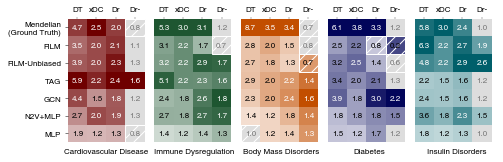

In [22]:
def colorFader(c1="#000000", c2="#ffffff", mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    import matplotlib as mpl
    import numpy as np
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

def plot_results(ors, pvals = None, need_transpose = True, pval_cutoff=0.05, adjust = False, extra_height = 2, rotate_xlabels=True):
    """ ors and pvals are dicts which contain one df per disease. dfs have n_methods rows and n_disease_subtypes columns """
    import numpy as np
    #from speos.scripts.utils import fdr
    from statsmodels.stats.multitest import fdrcorrection as fdr
    border_size = 0.01
    regular_height = 1
    break_height = 0.5
    break_width = 0.5
    regular_width = 1 - border_size
    value_font_size = medium_font
    label_font_size = medium_font
    
    crimson = "#6f0000"
    navy = "#02055a"
    jungle = "#1e5631"
    tan = "#c24e00"
    petrol = "#005f6a"
    purple = "#3c1361"
    grey = "#bbbbbb"

    color_gradients = []
    for colors in [crimson, jungle, tan, navy, petrol]:
        color_gradients.append({x: colorFader(c1 = colors, mix = ((100-x)/100) * 0.85 ) for x in range(101)})

    grey_gradient = {x: colorFader(c1 = grey, mix = ((100-x)/100) * 0.85 ) for x in range(101)}

    outer_labels = list(ors.keys())
    diseases = []
    one_large_df = None
    dfs = []
    main_diseases = []

    for i, (disease, df) in enumerate(ors.items()):
        if need_transpose:
            df = df.transpose()
        for subtype in df.columns:
            main_diseases.append((i, disease))
        diseases.extend(list(df.columns) + ["break"])
        methods = df.index.tolist()[::-1]
        dfs.append(df)

    pval_dfs = []
    for i, (disease, df) in enumerate(pvals.items()):
        if need_transpose:
            df = df.transpose()
        pval_dfs.append(df)

    one_large_df = pd.concat(dfs, axis=1)
    pval_df = pd.concat(pval_dfs, axis=1)

    # remove last break
    diseases = diseases[:-1]
    
    #fig, ax = plt.subplots(figsize=(0.7*len(diseases), (0.7*len(methods)) + extra_height))
    fig, ax = plt.subplots(figsize=(full_width*cm, (full_width*cm / 3)))
    
    diseases_without_breaks = [label for label in diseases if label != "break"]

    values = one_large_df.values
    pvals = pval_df.values
    if adjust:
        pvals_shape = pvals.shape
        pvals = fdr(pvals.flatten())[1].reshape(pvals_shape)
    
    all_main_diseases = main_diseases[:]
    for i, index in enumerate(methods):
        main_diseases = all_main_diseases[:]
        running_index = 0
        for c, column in enumerate(diseases):
                
            
            height = break_height if index == "break" else regular_height
            width = break_width if column == "break" else regular_width

            #minmax_means = (df[:,k] - np.min(df[:,k])) / (np.max(df[:,k]) - np.min(df[:,k]))
            kwargs = {}
            if "break" in [index, column]:
                color = "w"
            else:
                main_disease = main_diseases[0]
                main_diseases.remove(main_disease)

                value_disease_index = running_index
                minmax_means = (values[:, value_disease_index] - 1) / (np.max(values[:, value_disease_index]) - 1)
                if pvals[methods[::-1].index(index), value_disease_index] > pval_cutoff:
                    #colors = grey_gradient
                    color = "#dddddd"
                    significant = False
                else:
                    colors = color_gradients[main_disease[0]]
                    color = colors[abs(int(100 * minmax_means[methods[::-1].index(index)]))]
                    significant = True

                
                if values[methods[::-1].index(index), value_disease_index] < 1:
                    kwargs.update({"edgecolor": 'white', "hatch": "//"})
                

            bottom = np.sum([break_height if _method == "break" else regular_height for _method in methods[:i]])

            x_position = np.sum([break_width if _disease == "break" else regular_width for _disease in diseases[:c]])

            ax.bar(x_position, height=height - border_size, bottom=bottom,
                                color=color, width=width, **kwargs)
                
            
            if not "break" in [index, column]:
                if significant:
                    color = "w" if minmax_means[methods[::-1].index(index)] > 0.5 else "black"
                else: 
                    color = "#777777"
                text = str(round(values[methods[::-1].index(index), value_disease_index], 1))
                            
                ax.text(x_position, bottom + (0.5*height), text, ha='center',va='center',
                                    size=value_font_size, color=color)
                #weight='bold'
            if column != "break":
                running_index += 1

    yticks = []
    for index in range(len(methods)):
        yticks.append(np.sum([break_height if label == "break" else regular_height for label in methods[:index + 1]]) - 0.5)

    xticks = []
    for index in range(len(diseases)):
        xticks.append(np.sum([break_width if label == "break" else regular_width for label in diseases[:index + 1]]) - 1)

    #ax.set_title(" ".join([word.capitalize() if word not in abbreviations.keys() else abbreviations[word] for word in df.columns[j].split("_")]))
    ax.set_yticks(np.asarray(yticks)[np.asarray([label != "break" for label in methods], dtype = np.bool8)])
    methods = ["Mendelian\n(Ground Truth)" if label == "Mendelians" else label for label in methods]
    ax.set_yticklabels([label for label in methods if label != "break"], size=label_font_size)
    ax2 = ax.twiny()
    diseases = ["xDC" if disease == "#DC" else disease for disease in diseases]
    ax.set_xticks(np.asarray(xticks)[np.asarray([label != "break" for label in diseases], dtype = np.bool8)])
    ax.set_xticklabels([label for label in diseases if label != "break"], ha="center", rotation=90 if rotate_xlabels else 0, size=label_font_size)


    ax2.set_xticks([1.5, 6, 10.5, 15, 19.5])
    ax2.set_xticklabels(outer_labels, size=label_font_size)

    #for location, text in zip([2.5, 8.5, 13.5, 17, 21], outer_labels):
    #    ax.text(location, 9, text, ha='center', va="center", size=14)

    ax.xaxis.set_ticks_position('top')
    ax2.xaxis.set_ticks_position('bottom')

    for axe in [ax, ax2]:
        axe.spines['top'].set_visible(False)
        axe.spines['right'].set_visible(False)
        axe.spines['bottom'].set_visible(False)
        axe.spines['left'].set_visible(False)
    ax.set_ylim((0, np.sum([break_height if _method == "break" else regular_height for _method in methods]) - border_size))
    ax.set_xlim((- width/2, len(diseases) - ((width/2) ) - 2*width))
    ax2.set_xlim((- width/2, len(diseases) - ((width/2) ) - 2*width))
    
    plt.tick_params(bottom = False)
    plt.tight_layout()
    return fig, ax

plot_results(results_dict_values, results_dict_pvals, need_transpose=False, extra_height=0.1, rotate_xlabels=False)

plt.savefig("drug_all_unbiased.svg",bbox_inches="tight", transparent=False)

# Differentielly Expressed Genes

In [26]:
import os
os.chdir("/home/icb/florin.ratajczak/ppi-core-genes")

from speos.utils.config import Config
from speos.postprocessing.postprocessor import PostProcessor
import json
import pandas as pd
import matplotlib.pyplot as plt
#from speos.scripts.utils import fdr
from statsmodels.stats.multitest import fdrcorrection as fdr

def colorFader(c1="#000000", c2="#ffffff", mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    import matplotlib as mpl
    import numpy as np
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

convergence_score = 1

diseases = ["cardiovascular", "immune_dysregulation", "bm_disorder", "diabetes", "insulin_disorder"]
pretty_diseases = ["Cardiovascular Disease", "Immune Dysregulation", "Body Mass Disorders", "Diabetes", "Insulin Disorders"]
methods = ["film", "tag", "gcn", "n2vmlp", "mlp"]
pretty_methods = ["FiLM", "TAG", "GCN", "N2V\n+MLP", "MLP"]

disease_ors = {disease: None for disease in pretty_diseases}
disease_pvals = {disease: None for disease in pretty_diseases}
disease_n_dge = {disease: None for disease in pretty_diseases}

outer_dfs_list = []
for disease, pretty_disease in zip(diseases, pretty_diseases):
    all_results = []
    for method, pretty_method in zip(methods, pretty_methods):
        if disease == "immune_dysregulation" and method == "film":
            method = "film_forreal"
            
        if method in ["gcn", "mlp", "n2vmlp"] and disease == "immune_dysregulation":
            method += "_new"

        config = Config()
        config.parse_yaml("/home/icb/florin.ratajczak/ppi-core-genes/configs/config_{}_{}.yaml".format(disease, method))
        
        pp = PostProcessor(config)

        outer_results = "/lustre/groups/epigenereg01/projects/ppi-florin/results/{}_{}outer_results.json".format(disease, method)
        results_file = "/lustre/groups/epigenereg01/projects/ppi-florin/results/{}_{}_outer_0_fold_1.tsv".format(disease, method)

        with open(outer_results, "r") as file:
            outer_results = json.load(file)

        pp.outer_result = outer_results
        pp.init_pp_table()
        results = pp.dge(results_file, convergence_score = convergence_score)
        results = results.drop("Union", axis=0)
       
        if disease_ors[pretty_disease] is None:
            disease_ors[pretty_disease] = pd.DataFrame(data=results["Mendelian ORs"].values, index=results.index, columns=["Mendelian"])
            disease_pvals[pretty_disease] = pd.DataFrame(data=results["Mendelian pvals"].values, index=results.index, columns=["Mendelian"])
        disease_ors[pretty_disease][pretty_method] = results["Candidate ORs"].values
        disease_pvals[pretty_disease][pretty_method] = np.zeros_like(results["Candidate pvals"].values)
        disease_n_dge[pretty_disease] = results["N DEG"].values

        #results["Method"] = ["".join(pretty_method.split("\n"))] * len(results)
        #cols = list(results.columns.values)
        #new_cols = [cols[-1]] + cols[:-1]
        #results = results[new_cols]

        #results.loc["Mendelian adjusted pvals (FDR)"] = pd.Series(fdr(results["Mendelian pvals"].values)[1])
        all_results.append(results)
    
    all_results = pd.concat(all_results, keys=["".join(method.split("\n")) for method in pretty_methods])
    #print(dfs.head())
    #dfs.reset_index(inplace=True)
    for column in all_results.columns:
        if "OR" in column:
            all_results[column] = all_results[column].round(3)

    outer_dfs_list.append(all_results)
    #all_results.loc["Candidate adjusted pvals (FDR)"] = pd.Series(fdr(all_results["Candidate pvals"].values)[1])
    #all_results.to_csv("statistical_dump/{}_ors_dge_cs{}.tsv".format(disease,convergence_score), sep="\t")

    #disease_ors[pretty_disease].transpose().to_csv("results/{}_ors_{}.tsv".format(disease,convergence_score), sep="\t")
    #disease_pvals[pretty_disease].transpose().to_csv("results/{}_pvals{}.tsv".format(disease, convergence_score), sep="\t")

pvals = []
n_candidate = 0
lengths = []
for df in outer_dfs_list:
    new_pvals = df["Candidate pvals"].tolist()
    pvals.extend(new_pvals)
    n_candidate += len(new_pvals)
    lengths.append(len(new_pvals))

print(lengths)

n_mendelian = 0
for df in outer_dfs_list:
    new_pvals = df["Mendelian pvals"].tolist()
    pvals.extend(new_pvals)
    n_mendelian += len(new_pvals)
    
adj_pvals = fdr(pvals)[1]
candidate_pvals = adj_pvals[:n_candidate]
mendelian_pvals = adj_pvals[n_candidate:]
assert len(mendelian_pvals) == n_mendelian
previous_length = 0
for i, (df, disease) in enumerate(zip(outer_dfs_list, pretty_diseases)):
    if i > 0:
        candidates = candidate_pvals[previous_length:lengths[i]+previous_length]
        mendelians = mendelian_pvals[previous_length:lengths[i]+previous_length]
    else:
        candidates = candidate_pvals[:lengths[i]]
        mendelians = mendelian_pvals[:lengths[i]]
    previous_length += lengths[i]

    print((candidates < 0.05).sum())
    df["Candidate adjusted pvals (FDR)"] = candidates
    print((df["Candidate adjusted pvals (FDR)"] < 0.05).sum())
    df["Mendelian adjusted pvals (FDR)"] = mendelians
    columns = df.columns
    df = df[columns[4:-2].tolist() + columns[:4].tolist() + columns[-2:].tolist()]
    df.to_csv("statistical_dump/{}_ors_dge_cs{}.tsv".format(disease, convergence_score), sep="\t")

for df, pretty_disease in zip(outer_dfs_list, pretty_diseases):
    for pretty_method in pretty_methods:
        subset_df = df.loc["".join(pretty_method.split("\n"))]
        disease_pvals[pretty_disease]["Mendelian"] = subset_df["Mendelian adjusted pvals (FDR)"].tolist()
        disease_pvals[pretty_disease][pretty_method] = subset_df["Candidate adjusted pvals (FDR)"].tolist()

print(disease_pvals["Cardiovascular Disease"].transpose())
print(disease_ors["Cardiovascular Disease"].transpose())

cardiovascular_film 2023-01-03 11:00:02,474 [INFO] speos.postprocessing.postprocessor: Starting Differential Gene Expression Enrichment Analysis.
cardiovascular_film 2023-01-03 11:00:02,480 [INFO] speos.postprocessing.postprocessor: Found 5 subtypes for phenotype insulin_disorder: ['Obesity', 'Decreased Body Weight', 'Increased Body Weight', 'Atherosclerosis', 'Coronary Artery Disease'].
cardiovascular_film 2023-01-03 11:00:02,552 [INFO] speos.postprocessing.postprocessor: Total of 651 Obesity DE genes, 619 of them match with our translation table.
cardiovascular_film 2023-01-03 11:00:02,552 [INFO] speos.postprocessing.postprocessor: Found 96 Obesity DE genes among the 610 known positive genes (p: 5.41e-36, OR: 5.81), leaving 523 in 16791 Unknowns
cardiovascular_film 2023-01-03 11:00:02,565 [INFO] speos.postprocessing.postprocessor: Fishers Exact Test for Obesity DE genes among Predicted Genes. p: 3.87e-03, OR: 1.338
cardiovascular_film 2023-01-03 11:00:02,565 [INFO] speos.postprocessi

[30, 25, 20, 10, 25]
24
24
25
25
11
11
9
9
20
20
           Coronary Artery Disease  Atrial Fibrillation  Aortic Aneurysm  \
Mendelian             1.751596e-48         2.403306e-14     3.643371e-12   
FiLM                  2.278645e-18         2.333193e-03     4.263908e-02   
TAG                   2.322967e-44         2.302052e-04     4.407164e-04   
GCN                   2.131057e-20         1.868098e-01     7.546802e-03   
N2V\n+MLP             6.214071e-15         4.106618e-02     3.003771e-01   
MLP                   5.837596e-15         6.097838e-01     7.782889e-01   

               Ischemia  Hypertension  Atherosclerosis  
Mendelian  4.340923e-13  3.321815e-37     4.573932e-29  
FiLM       1.021553e-05  2.049931e-09     7.098620e-06  
TAG        7.096317e-15  9.880102e-18     1.831046e-13  
GCN        8.474900e-04  2.003398e-05     9.575649e-06  
N2V\n+MLP  6.622575e-05  8.212526e-05     7.424627e-04  
MLP        1.548504e-01  1.651500e-05     1.986432e-01  
           Coronary

In [52]:
print(disease_pvals["Diabetes"].transpose())

           Diabetes Mellitus  Hyperglycemia
Mendelian       5.321141e-64   1.104117e-16
FiLM            2.605652e-10   2.121072e-04
TAG             2.184565e-38   6.621567e-10
GCN             6.828488e-39   1.553244e-06
N2V\n+MLP       7.310299e-09   6.017055e-02
MLP             1.091136e-28   1.235663e-04


[473, 49, 41, 110, 361, 124, 'break', 89, 101, 124, 364, 192, 'break', 619, 34, 84, 26, 'break', 475, 49, 'break', 619, 34, 84, 126, 476, 'break']


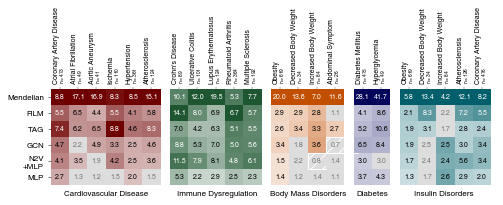

In [27]:
def plot_results(ors, disease_n, pvals = None,  need_transpose = True, pval_cutoff=0.05, adjust = False, drop_union=False):
    """ ors and pvals are dicts which contain one df per disease. dfs have n_methods rows and n_disease_subtypes columns """
    import numpy as np
    #from speos.scripts.utils import fdr
    from statsmodels.stats.multitest import fdrcorrection as fdr
    border_size = 0.01
    regular_height = 1
    break_height = 0.5
    break_width = 0.5
    regular_width = 1 - border_size
    value_font_size = medium_font-1
    label_font_size = medium_font
    
    crimson = "#6f0000"
    navy = "#02055a"
    jungle = "#1e5631"
    tan = "#c24e00"
    petrol = "#005f6a"
    purple = "#3c1361"
    grey = "#bbbbbb"

    color_gradients = []
    for colors in [crimson, jungle, tan, navy, petrol]:
        color_gradients.append({x: colorFader(c1 = colors, mix = ((100-x)/100) * 0.85 ) for x in range(101)})

    grey_gradient = {x: colorFader(c1 = grey, mix = ((100-x)/100) * 0.85 ) for x in range(101)}

    outer_labels = list(ors.keys())
    diseases = []
    one_large_df = None
    dfs = []
    main_diseases = []

    for i, (disease, df) in enumerate(ors.items()):
        if need_transpose:
            df = df.transpose()
        if drop_union:
            df = df.drop("Union", axis=1)
        for subtype in df.columns:
            main_diseases.append((i, disease))
        diseases.extend(list(df.columns) + ["break"])
        methods = df.index.tolist()[::-1]
        dfs.append(df)

    pval_dfs = []
    for i, (disease, df) in enumerate(pvals.items()):
        if need_transpose:
            df = df.transpose()
        if drop_union:
            df = df.drop("Union", axis=1)
        pval_dfs.append(df)

    one_large_df = pd.concat(dfs, axis=1)
    pval_df = pd.concat(pval_dfs, axis=1)
    # remove last break
    diseases = diseases[:-1]
    disease_n = [value for values in disease_n.values() for value in values.tolist() + ["break"]]
    fig, ax = plt.subplots(figsize=(full_width*cm, ((1*len(methods))+1.5)*cm))
    
    diseases_without_breaks = [label for label in diseases if label != "break"]

    values = one_large_df.values
    pvals = pval_df.values
    if adjust:
        pvals_shape = pvals.shape
        pvals = fdr(pvals.flatten())[1].reshape(pvals_shape)
    
    all_main_diseases = main_diseases[:]
    for i, index in enumerate(methods):
        main_diseases = all_main_diseases[:]
        running_index = 0
        for c, column in enumerate(diseases):
                
            
            height = break_height if index == "break" else regular_height
            width = break_width if column == "break" else regular_width

            #minmax_means = (df[:,k] - np.min(df[:,k])) / (np.max(df[:,k]) - np.min(df[:,k]))
                
            if "break" in [index, column]:
                color = "w"
            else:
                main_disease = main_diseases[0]
                main_diseases.remove(main_disease)
                """
                    try:
                    if drop_union:
                        n_dge = disease_n[main_disease[1]][:-1]
                    else: 
                        n_dge = disease_n[main_disease[1]]
                    disease_dge.extend(n_dge)

                    del disease_n[main_disease[1]]
                except KeyError:
                    pass
                """
                value_disease_index = running_index
                minmax_means = (values[:, value_disease_index] - 1) / (np.max(values[:, value_disease_index]) - 1)
                if pvals[methods[::-1].index(index), value_disease_index] > pval_cutoff:
                    #colors = grey_gradient
                    color = "#dddddd"
                    significant = False
                else:
                    colors = color_gradients[main_disease[0]]
                    color = colors[abs(int(100 * minmax_means[methods[::-1].index(index)]))]
                    significant = True

            kwargs = {}
            
            if values[methods[::-1].index(index), value_disease_index] < 1:
                    kwargs.update({"edgecolor": 'white', "hatch": "//"})

            bottom = np.sum([break_height if _method == "break" else regular_height for _method in methods[:i]])

            x_position = np.sum([break_width if _disease == "break" else regular_width for _disease in diseases[:c]])

            ax.bar(x_position, height=height - border_size, bottom=bottom,
                                color=color, width=width, **kwargs)
                
            
            if not "break" in [index, column]:
                if significant:
                    color = "w" if minmax_means[methods[::-1].index(index)] > 0.5 else "black"
                else: 
                    color = "#777777"
                text = str(round(values[methods[::-1].index(index), value_disease_index], 1))
                            
                ax.text(x_position, bottom + (0.5*height), text, ha='center',va='center',
                                    size=value_font_size, color=color)
                #weight='bold'
            if column != "break":
                running_index += 1

    yticks = []
    for index in range(len(methods)):
        yticks.append(np.sum([break_height if label == "break" else regular_height for label in methods[:index + 1]]) - 0.5)

    xticks = []
    for index in range(len(diseases)):
        xticks.append(np.sum([break_width if label == "break" else regular_width for label in diseases[:index + 1]]) - 1)

    #ax.set_title(" ".join([word.capitalize() if word not in abbreviations.keys() else abbreviations[word] for word in df.columns[j].split("_")]))
    ax.set_yticks(np.asarray(yticks)[np.asarray([label != "break" for label in methods], dtype = np.bool8)])
    ax.set_yticklabels([label for label in methods if label != "break"], size=label_font_size)
    ax2 = ax.twiny()
    print(disease_n)
    ax.set_xticks(np.asarray(xticks)[np.asarray([label != "break" for label in diseases], dtype = np.bool8)])
    ax.set_xticklabels([label + "\n$\\regular_{n=%s}$" % number for label, number in zip(diseases, disease_n) if label != "break"], rotation=90, size=label_font_size-1, ma="left", linespacing=0.5)


    ax2.set_xticks([2.5, 8.5, 13.4, 16.85, 20.7])
    ax2.set_xticklabels(outer_labels, size=label_font_size)

    #for location, text in zip([2.5, 8.5, 13.5, 17, 21], outer_labels):
    #    ax.text(location, 9, text, ha='center', va="center", size=14)

    ax.xaxis.set_ticks_position('top')
    ax2.xaxis.set_ticks_position('bottom')

    for axe in [ax, ax2]:
        axe.spines['top'].set_visible(False)
        axe.spines['right'].set_visible(False)
        axe.spines['bottom'].set_visible(False)
        axe.spines['left'].set_visible(False)
    ax.set_ylim((0, np.sum([break_height if _method == "break" else regular_height for _method in methods]) - border_size))
    ax.set_xlim((- width/2, len(diseases) - ((width/2) ) - 2*width))
    ax2.set_xlim((- width/2, len(diseases) - ((width/2) ) - 2*width))
    
    plt.tick_params(bottom = False)
    plt.tight_layout()
    return fig, ax

plot_results(disease_ors,disease_n_dge, disease_pvals)

#plt.savefig("dge_new_cs{}.png".format(convergence_score), dpi =450, transparent=False)
plt.savefig("dge_new_cs{}.svg".format(convergence_score), transparent=False)

# Now Unbiased

In [28]:
import os
os.chdir("/home/icb/florin.ratajczak/ppi-core-genes")

from speos.utils.config import Config
from speos.postprocessing.postprocessor import PostProcessor

import json
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import fdrcorrection as fdr

def colorFader(c1="#000000", c2="#ffffff", mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    import matplotlib as mpl
    import numpy as np
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

convergence_score = 1

diseases = ["cardiovascular", "immune_dysregulation", "bm_disorder", "diabetes", "insulin_disorder"]
pretty_diseases = ["Cardiovascular Disease", "Immune Dysregulation", "Body Mass Disorders", "Diabetes", "Insulin Disorders"]
methods = ["film", "film_unbiased", "tag", "gcn", "n2vmlp", "mlp"]
pretty_methods = ["FiLM", "FiLM-Unbiased", "TAG", "GCN", "N2V\n+MLP", "MLP"]

disease_ors = {disease: None for disease in pretty_diseases}
disease_pvals = {disease: None for disease in pretty_diseases}
disease_n_dge = {disease: None for disease in pretty_diseases}

outer_dfs_list = []

for disease, pretty_disease in zip(diseases, pretty_diseases):
    all_results = []
    for method, pretty_method in zip(methods, pretty_methods):
        if disease == "immune_dysregulation" and method == "film":
            method = "film_forreal"
        if method in ["gcn", "mlp", "n2vmlp"] and disease == "immune_dysregulation":
            method += "_new"

        config = Config()
        config.parse_yaml("/home/icb/florin.ratajczak/ppi-core-genes/configs/config_{}_{}.yaml".format(disease, method))
        
        pp = PostProcessor(config)

        outer_results = "/lustre/groups/epigenereg01/projects/ppi-florin/results/{}_{}outer_results.json".format(disease, method)
        results_file = "/lustre/groups/epigenereg01/projects/ppi-florin/results/{}_{}_outer_0_fold_1.tsv".format(disease, method)

        with open(outer_results, "r") as file:
            outer_results = json.load(file)

        pp.outer_result = outer_results
        pp.init_pp_table()
        results = pp.dge(results_file, convergence_score = convergence_score)

        results = results.drop("Union", axis=0)
        
        if disease_ors[pretty_disease] is None:
            disease_ors[pretty_disease] = pd.DataFrame(data=results["Mendelian ORs"].values, index=results.index, columns=["Mendelian\n(Ground Truth)"])
            disease_pvals[pretty_disease] = pd.DataFrame(data=results["Mendelian pvals"].values, index=results.index, columns=["Mendelian\n(Ground Truth)"])
        disease_ors[pretty_disease][pretty_method] = results["Candidate ORs"].values
        disease_pvals[pretty_disease][pretty_method] = np.zeros_like(results["Candidate pvals"].values)
        disease_n_dge[pretty_disease] = results["N DEG"].values

        #results.loc["Mendelian adjusted pvals (FDR)"] = pd.Series(fdr(results["Mendelian pvals"].values)[1])
        all_results.append(results)
    
    all_results = pd.concat(all_results, keys=["".join(method.split("\n")) for method in pretty_methods])
    for column in all_results.columns:
        if "OR" in column:
            all_results[column] = all_results[column].round(3)
        if column.startswith("N ") :
            all_results[column] = all_results[column].astype(int)
    outer_dfs_list.append(all_results)
    #all_results.loc["Candidate adjusted pvals (FDR)"] = pd.Series(fdr(all_results["Candidate pvals"].values)[1])
    #all_results.to_csv("statistical_dump/{}_ors_dge_cs{}_unbiased.tsv".format(disease,convergence_score), sep="\t")

    #disease_ors[pretty_disease].transpose().to_csv("results/{}_ors_{}.tsv".format(disease,convergence_score), sep="\t")
    #disease_pvals[pretty_disease].transpose().to_csv("results/{}_pvals{}.tsv".format(disease, convergence_score), sep="\t")


pvals = []
n_candidate = 0
lengths = []
for df in outer_dfs_list:
    new_pvals = df["Candidate pvals"].tolist()
    pvals.extend(new_pvals)
    n_candidate += len(new_pvals)
    lengths.append(len(new_pvals))

print(lengths)

n_mendelian = 0
for df in outer_dfs_list:
    new_pvals = df["Mendelian pvals"].tolist()
    pvals.extend(new_pvals)
    n_mendelian += len(new_pvals)
    
adj_pvals = fdr(pvals)[1]
candidate_pvals = adj_pvals[:n_candidate]
mendelian_pvals = adj_pvals[n_candidate:]
assert len(mendelian_pvals) == n_mendelian
previous_length = 0

for i, (df, disease) in enumerate(zip(outer_dfs_list, pretty_diseases)):
    if i > 0:
        candidates = candidate_pvals[previous_length:lengths[i]+previous_length]
        mendelians = mendelian_pvals[previous_length:lengths[i]+previous_length]
    else:
        candidates = candidate_pvals[:lengths[i]]
        mendelians = mendelian_pvals[:lengths[i]]
    previous_length += lengths[i]

    print((candidates < 0.05).sum())
    df["Candidate adjusted pvals (FDR)"] = candidates
    print((df["Candidate adjusted pvals (FDR)"] < 0.05).sum())
    df["Mendelian adjusted pvals (FDR)"] = mendelians
    columns = df.columns
    df = df[columns[4:-2].tolist() + columns[:4].tolist() + columns[-2:].tolist()]
    df.to_csv("statistical_dump/{}_ors_dge_cs{}_unbiased.tsv".format(disease, convergence_score), sep="\t")

for df, pretty_disease in zip(outer_dfs_list, pretty_diseases):
    for pretty_method in pretty_methods:
        subset_df = df.loc["".join(pretty_method.split("\n"))]
        disease_pvals[pretty_disease]["Mendelian"] = subset_df["Mendelian adjusted pvals (FDR)"].tolist()
        disease_pvals[pretty_disease][pretty_method] = subset_df["Candidate adjusted pvals (FDR)"].tolist()

print(disease_pvals["Cardiovascular Disease"].transpose())
print(disease_ors["Cardiovascular Disease"].transpose())

cardiovascular_film 2023-01-03 11:01:40,107 [INFO] speos.postprocessing.postprocessor: Starting Differential Gene Expression Enrichment Analysis.
cardiovascular_film 2023-01-03 11:01:40,112 [INFO] speos.postprocessing.postprocessor: Found 5 subtypes for phenotype insulin_disorder: ['Obesity', 'Decreased Body Weight', 'Increased Body Weight', 'Atherosclerosis', 'Coronary Artery Disease'].
cardiovascular_film 2023-01-03 11:01:40,177 [INFO] speos.postprocessing.postprocessor: Total of 651 Obesity DE genes, 619 of them match with our translation table.
cardiovascular_film 2023-01-03 11:01:40,177 [INFO] speos.postprocessing.postprocessor: Found 96 Obesity DE genes among the 610 known positive genes (p: 5.41e-36, OR: 5.81), leaving 523 in 16791 Unknowns
cardiovascular_film 2023-01-03 11:01:40,190 [INFO] speos.postprocessing.postprocessor: Fishers Exact Test for Obesity DE genes among Predicted Genes. p: 3.87e-03, OR: 1.338
cardiovascular_film 2023-01-03 11:01:40,190 [INFO] speos.postprocessi

[36, 30, 24, 12, 30]
28
28
30
30
13
13
11
11
24
24
                           Coronary Artery Disease  Atrial Fibrillation  \
Mendelian\n(Ground Truth)             7.961798e-50         1.070563e-14   
FiLM                                  2.223958e-18         2.337723e-03   
FiLM-Unbiased                         6.347986e-20         2.801621e-01   
TAG                                   2.347419e-44         2.302052e-04   
GCN                                   2.082348e-20         1.878686e-01   
N2V\n+MLP                             6.168878e-15         4.131083e-02   
MLP                                   5.784040e-15         6.112186e-01   
Mendelian                             1.751596e-48         2.395159e-14   

                           Aortic Aneurysm      Ischemia  Hypertension  \
Mendelian\n(Ground Truth)     1.954172e-12  2.052073e-13  4.227765e-38   
FiLM                          4.292816e-02  1.014508e-05  2.047286e-09   
FiLM-Unbiased                 5.588580e-02  6.08257

In [34]:
pvals

[6.318061587212438e-19,
 0.0018241323630734446,
 0.03837517224913115,
 6.686528580606888e-06,
 1.202004800534023e-09,
 4.581836573297923e-06,
 8.752644660711209e-24,
 1.755314253905717e-20,
 0.2663662525461575,
 0.050805273251877975,
 0.0004608008507497341,
 5.973625182905077e-08,
 1.4316381743049382e-05,
 1.1842557289248118e-24,
 1.689430672413316e-45,
 0.0001726539176740291,
 0.00033254052502469113,
 2.9675506972208574e-15,
 3.502945379207382e-18,
 8.239705401457912e-14,
 6.590592943808977e-59,
 5.521376026843678e-21,
 0.17577103235146585,
 0.006449085145141098,
 0.0006471741739063283,
 1.3477405471969377e-05,
 6.224172012945757e-06,
 1.6569778455600918e-24,
 2.570365927281313e-15,
 0.03677289921449278,
 0.2894542647834677,
 4.605699631038149e-05,
 5.748768215523063e-05,
 0.0005635967004570325,
 2.0507861713466543e-20,
 2.3881074775675984e-15,
 0.5903815902125121,
 0.7676758901418526,
 0.14499628171308543,
 1.103502254330441e-05,
 0.18780814237347565,
 3.9452992331299947e-13,
 2.4454

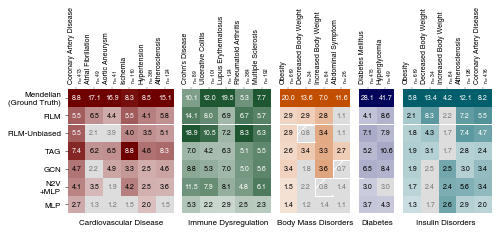

In [29]:
def plot_results(ors, disease_n, pvals = None,  need_transpose = True, pval_cutoff=0.05, adjust = False, drop_union=False):
    """ ors and pvals are dicts which contain one df per disease. dfs have n_methods rows and n_disease_subtypes columns """
    import numpy as np
    #from speos.scripts.utils import fdr
    from statsmodels.stats.multitest import fdrcorrection as fdr
    border_size = 0.01
    regular_height = 1
    break_height = 0.5
    break_width = 0.5
    regular_width = 1 - border_size
    value_font_size = medium_font - 1
    label_font_size = medium_font
    
    crimson = "#6f0000"
    navy = "#02055a"
    jungle = "#1e5631"
    tan = "#c24e00"
    petrol = "#005f6a"
    purple = "#3c1361"
    grey = "#bbbbbb"

    color_gradients = []
    for colors in [crimson, jungle, tan, navy, petrol]:
        color_gradients.append({x: colorFader(c1 = colors, mix = ((100-x)/100) * 0.85 ) for x in range(101)})

    grey_gradient = {x: colorFader(c1 = grey, mix = ((100-x)/100) * 0.85 ) for x in range(101)}

    outer_labels = list(ors.keys())
    diseases = []
    one_large_df = None
    dfs = []
    main_diseases = []

    for i, (disease, df) in enumerate(ors.items()):
        if need_transpose:
            df = df.transpose()
        if drop_union:
            df = df.drop("Union", axis=1)
        for subtype in df.columns:
            main_diseases.append((i, disease))
        diseases.extend(list(df.columns) + ["break"])
        methods = df.index.tolist()[::-1]
        dfs.append(df)

    pval_dfs = []
    for i, (disease, df) in enumerate(pvals.items()):
        if need_transpose:
            df = df.transpose()
        if drop_union:
            df = df.drop("Union", axis=1)
        pval_dfs.append(df)

    one_large_df = pd.concat(dfs, axis=1)
    pval_df = pd.concat(pval_dfs, axis=1)

    # remove last break
    diseases = diseases[:-1]
    disease_n = [value for values in disease_n.values() for value in values.tolist() + ["break"]]
    fig, ax = plt.subplots(figsize=(full_width*cm, ((1*len(methods))+1.5)*cm))
    
    diseases_without_breaks = [label for label in diseases if label != "break"]

    values = one_large_df.values
    pvals = pval_df.values
    if adjust:
        pvals_shape = pvals.shape
        pvals = fdr(pvals.flatten())[1].reshape(pvals_shape)
    
    all_main_diseases = main_diseases[:]
    for i, index in enumerate(methods):
        main_diseases = all_main_diseases[:]
        running_index = 0
        for c, column in enumerate(diseases):
                
            
            height = break_height if index == "break" else regular_height
            width = break_width if column == "break" else regular_width

            #minmax_means = (df[:,k] - np.min(df[:,k])) / (np.max(df[:,k]) - np.min(df[:,k]))
                
            if "break" in [index, column]:
                color = "w"
            else:
                main_disease = main_diseases[0]
                main_diseases.remove(main_disease)
                """
                    try:
                    if drop_union:
                        n_dge = disease_n[main_disease[1]][:-1]
                    else: 
                        n_dge = disease_n[main_disease[1]]
                    disease_dge.extend(n_dge)

                    del disease_n[main_disease[1]]
                except KeyError:
                    pass
                """
                value_disease_index = running_index
                minmax_means = (values[:, value_disease_index] - 1) / (np.max(values[:, value_disease_index]) - 1)
                if pvals[methods[::-1].index(index), value_disease_index] > pval_cutoff:
                    #colors = grey_gradient
                    color = "#dddddd"
                    significant = False
                else:
                    colors = color_gradients[main_disease[0]]
                    color = colors[abs(int(100 * minmax_means[methods[::-1].index(index)]))]
                    significant = True

            kwargs = {}
            
            if values[methods[::-1].index(index), value_disease_index] < 1:
                    kwargs.update({"edgecolor": 'white', "hatch": "/"})

            bottom = np.sum([break_height if _method == "break" else regular_height for _method in methods[:i]])

            x_position = np.sum([break_width if _disease == "break" else regular_width for _disease in diseases[:c]])

            ax.bar(x_position, height=height - border_size, bottom=bottom,
                                color=color, width=width, **kwargs)
                
            
            if not "break" in [index, column]:
                if significant:
                    color = "w" if minmax_means[methods[::-1].index(index)] > 0.5 else "black"
                else: 
                    color = "#777777"
                text = str(round(values[methods[::-1].index(index), value_disease_index], 1))
                            
                ax.text(x_position, bottom + (0.5*height), text, ha='center',va='center',
                                    size=value_font_size, color=color)
                #weight='bold'
            if column != "break":
                running_index += 1

    yticks = []
    for index in range(len(methods)):
        yticks.append(np.sum([break_height if label == "break" else regular_height for label in methods[:index + 1]]) - 0.5)

    xticks = []
    for index in range(len(diseases)):
        xticks.append(np.sum([break_width if label == "break" else regular_width for label in diseases[:index + 1]]) - 1)

    #ax.set_title(" ".join([word.capitalize() if word not in abbreviations.keys() else abbreviations[word] for word in df.columns[j].split("_")]))
    ax.set_yticks(np.asarray(yticks)[np.asarray([label != "break" for label in methods], dtype = np.bool8)])
    ax.set_yticklabels([label for label in methods if label != "break"], size=label_font_size)
    ax2 = ax.twiny()

    ax.set_xticks(np.asarray(xticks)[np.asarray([label != "break" for label in diseases], dtype = np.bool8)])
    ax.set_xticklabels([label + "\n$\\regular_{n=%s}$" % number for label, number in zip(diseases, disease_n) if label != "break"], rotation=90, size=label_font_size-1,ma="left")


    ax2.set_xticks([2.5, 8.5, 13.4, 16.85, 20.7])
    ax2.set_xticklabels(outer_labels, size=label_font_size)

    #for location, text in zip([2.5, 8.5, 13.5, 17, 21], outer_labels):
    #    ax.text(location, 9, text, ha='center', va="center", size=14)

    ax.xaxis.set_ticks_position('top')
    ax2.xaxis.set_ticks_position('bottom')

    for axe in [ax, ax2]:
        axe.spines['top'].set_visible(False)
        axe.spines['right'].set_visible(False)
        axe.spines['bottom'].set_visible(False)
        axe.spines['left'].set_visible(False)
    ax.set_ylim((0, np.sum([break_height if _method == "break" else regular_height for _method in methods]) - border_size))
    ax.set_xlim((- width/2, len(diseases) - ((width/2) ) - 2*width))
    ax2.set_xlim((- width/2, len(diseases) - ((width/2) ) - 2*width))
    
    plt.tick_params(bottom = False)
    plt.tight_layout()
    return fig, ax

plot_results(disease_ors,disease_n_dge, disease_pvals)

#plt.savefig("dge_new_cs{}.png".format(convergence_score), dpi =450, transparent=False)
plt.savefig("dge_new_unbiased_cs{}.svg".format(convergence_score), transparent=False)

# BORDER


In [3]:
import os
os.chdir("/home/icb/florin.ratajczak/ppi-core-genes/")
from speos.preprocessing.preprocessor import PreProcessor
from speos.preprocessing.mappers import *
from speos.utils.config import Config
from speos.datasets import DatasetBootstrapper

config = Config()
#config.parse_yaml("configs/config_immune_dysregulation_film_forreal.yaml")
config.parse_yaml("configs/config_cardiovascular_film.yaml")

In [4]:
pre_mappings = GWASMapper().get_mappings(config.input.tag, fields=config.input.field)

mappings = []

for mapping in pre_mappings:
    if not "AMD" in mapping["name"]:
        mappings.append(mapping)

adjacencies = AdjacencyMapper(config.input.adjacency_mappings, blacklist=config.input.adjacency_blacklist).get_mappings(config.input.adjacency, fields=config.input.adjacency_field)

dataset = DatasetBootstrapper(mappings, adjacencies, holdout_size=config.input.holdout_size, name="test_immu", config=config).get_dataset()

cardiovascular_film 2022-12-21 14:31:31,420 [INFO] speos.preprocessing.preprocessor: Using Adjacency matrices: ['IntActDirect']
cardiovascular_film 2022-12-21 14:31:31,420 [INFO] speos.preprocessing.preprocessor: Using 8 mappings with ground truth data/mendelian_gene_sets/Cardiovascular_Disease_genes.bed 
Processing...


KeyboardInterrupt: 

In [61]:
dataset.preprocessor.build_graph(features=True)

In [62]:
G = dataset.preprocessor.G

In [78]:
gene = "ITGA7"

dataset.preprocessor.hgnc2id[gene]

7097

In [79]:
G.in_degree[dataset.preprocessor.hgnc2id[gene]]

312

In [80]:
id2hgnc = {value: key for key, value in dataset.preprocessor.hgnc2id.items()}

6749

In [81]:
from speos.utils.nn_utils import typed_edges_to_sparse_tensor
edge_index, encoder = typed_edges_to_sparse_tensor(dataset.data.x, dataset.data.edge_index_dict)

In [11]:
encoder.inverse_transform([32])

array(['hetionetcovaries'], dtype='<U19')

In [12]:
def get_names_labels(start, end, edgetype, values, dataset, id2symbol, encoder):
        return ((id2symbol[key1], 
                 dataset.data.y[key1].item(), 
                 id2symbol[key2],  
                 dataset.data.y[key2].item(), 
                 encoder.inverse_transform([int(edge)])[0], value) for key1, key2, edge, value in zip(start,  end, edgetype, values))


In [71]:
[(id2hgnc[key], dataset.data.y[key].item(), value) for key, value in zip([6749,  6162,  5338, 12577, 16177, 11423,   192,   501,  9568,   190], [1.0000, 0.0627, 0.0501, 0.0347, 0.0321, 0.0268, 0.0186, 0.0155, 0.0138,
        0.0134])]

[('IL18RAP', 0.0, 1.0),
 ('HBB', 1.0, 0.0627),
 ('FTL', 0.0, 0.0501),
 ('S100A9', 0.0, 0.0347),
 ('WFS1', 1.0, 0.0321),
 ('PRSS1', 0.0, 0.0268),
 ('ACTB', 0.0, 0.0186),
 ('ALB', 0.0, 0.0155),
 ('NPPA', 0.0, 0.0138),
 ('ACTA1', 0.0, 0.0134)]

## TNFSF15

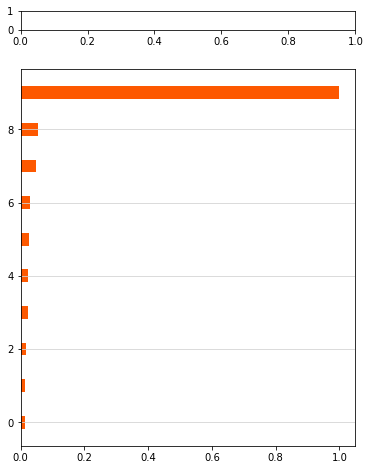

In [74]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from matplotlib import cm
from numpy import linspace
import os


orange = '#fd5800'
gray = "#71797E"

labels = []
mendelians = []
values = []
colors = 

for label, mendelian, value in tnfsf15_other[::-1]:
    labels.append(labels)
    mendelians.append(mendelian)
    values.append(value)

x = range(len(values))
fig, (ax2, ax) = plt.subplots(2,1, figsize=(6,8), gridspec_kw=gs_kw)
ax.grid(axis="y", color="lightgray")
rects2 = ax.barh(x, values, width, color=orange, label='Importance')

# Input Features (IL18RAP)

## loading the freshest

In [82]:
import torch

#gene = "IL18RAP" # "OBSCN" # "ITGA7" #  # "IL18RAP"
num_outer = 11
num_inner = 10
ig_attr_self_all = None
ig_attr_self_abs_all = None
num_processed = 0
for outer_fold in range(0, num_outer):
    for inner_fold in range(0, num_inner + 1):
        if inner_fold == outer_fold:
            continue
        try:
            #ig_attr_node = torch.load("/lustre/groups/epigenereg01/projects/ppi-florin/explanations/ig_attr_node_outer{}_inner{}_{}.pt".format(outer_fold, inner_fold, args.gene))
            #ig_attr_edge = torch.load("/lustre/groups/epigenereg01/projects/ppi-florin/explanations/ig_attr_edge_outer{}_inner{}_{}.pt".format(outer_fold, inner_fold, args.gene))
            if gene in ["OBSCN", "ITGA7"]:
                ig_attr_self = torch.load("/lustre/groups/epigenereg01/projects/ppi-florin/explanations/new_ig_attr_self_outer{}_inner{}_{}.pt".format(outer_fold, inner_fold, gene))
                ig_attr_self_abs = torch.load("/lustre/groups/epigenereg01/projects/ppi-florin/explanations/new_ig_attr_self_abs_outer{}_inner{}_{}.pt".format(outer_fold, inner_fold, gene))
            else:
                ig_attr_self = torch.load("/lustre/groups/epigenereg01/projects/ppi-florin/explanations/ig_attr_self_outer{}_inner{}_{}.pt".format(outer_fold, inner_fold, gene))
                ig_attr_self_abs = torch.load("/lustre/groups/epigenereg01/projects/ppi-florin/explanations/ig_attr_self_abs_outer{}_inner{}_{}.pt".format(outer_fold, inner_fold, gene))
            print("Loaded attributes for outer {} inner {}".format(outer_fold, inner_fold))
            #ig_attr_node.requires_grad = False
            #ig_attr_edge.requires_grad = False
            ig_attr_self.requires_grad = False
            ig_attr_self_abs.requires_grad = False
        except FileNotFoundError:
            print("Attributes for outer {} inner {} not yet calculated.".format(outer_fold, inner_fold))
            continue 

        num_processed += 1


        if ig_attr_self_abs_all is None:
            ig_attr_self_abs_all = ig_attr_self_abs
        else:
            ig_attr_self_abs_all += ig_attr_self_abs

        if ig_attr_self_all is None:
            ig_attr_self_all = ig_attr_self
        else:
            ig_attr_self_all += ig_attr_self

ig_attr_self_all /= num_processed
ig_attr_self_abs_all /= num_processed

input_attributions = ig_attr_self_all.numpy().tolist()

Loaded attributes for outer 0 inner 1
Loaded attributes for outer 0 inner 2
Loaded attributes for outer 0 inner 3
Loaded attributes for outer 0 inner 4
Loaded attributes for outer 0 inner 5
Loaded attributes for outer 0 inner 6
Loaded attributes for outer 0 inner 7
Loaded attributes for outer 0 inner 8
Loaded attributes for outer 0 inner 9
Loaded attributes for outer 0 inner 10
Loaded attributes for outer 1 inner 0
Loaded attributes for outer 1 inner 2
Loaded attributes for outer 1 inner 3
Loaded attributes for outer 1 inner 4
Loaded attributes for outer 1 inner 5
Loaded attributes for outer 1 inner 6
Loaded attributes for outer 1 inner 7
Loaded attributes for outer 1 inner 8
Loaded attributes for outer 1 inner 9
Loaded attributes for outer 1 inner 10
Loaded attributes for outer 2 inner 0
Loaded attributes for outer 2 inner 1
Loaded attributes for outer 2 inner 3
Loaded attributes for outer 2 inner 4
Loaded attributes for outer 2 inner 5
Loaded attributes for outer 2 inner 6
Loaded att

In [83]:
features = dataset.preprocessor.get_feature_names()

## normalizing each feature by its absolute 99% quantile

In [18]:
normalized_data = dataset.data.x / dataset.data.x.abs().topk(dim=0, k =int(dataset.data.x.shape[0]/100), sorted=True).values[-1,:]

## normalizing positive and negative seperately

In [84]:
normalized_data = torch.empty(dataset.data.x.shape, dtype=torch.double)
normalized_data_positives = dataset.data.x / dataset.data.x.topk(dim=0, k =int(dataset.data.x.shape[0]/100), sorted=True).values[-1,:]
normalized_data_negatives = (dataset.data.x / dataset.data.x.topk(dim=0, k=int(dataset.data.x.shape[0]/100), sorted=True, largest=False).values[-1,:]) * -1

In [85]:
normalized_data[dataset.data.x >= 0] = normalized_data_positives[dataset.data.x >= 0]
normalized_data[dataset.data.x < 0] = normalized_data_negatives[dataset.data.x < 0]

In [86]:
q001 = normalized_data.quantile(0.01, dim=0)
q01 = normalized_data.quantile(0.1, dim=0)
q25 = normalized_data.quantile(0.25, dim=0)
q50 = normalized_data.quantile(0.5, dim=0)
q75 = normalized_data.quantile(0.75, dim=0)
q90 = normalized_data.quantile(0.9, dim=0)
q99 = normalized_data.quantile(0.99, dim=0)

In [ ]:
#input_values = dataset.data.x[6749].tolist()

In [87]:
input_values = normalized_data[dataset.preprocessor.hgnc2id[gene]].tolist()

In [88]:
list1, list2, list3,  q001_ordered, q01_ordered, q25_ordered, q50_ordered, q75_ordered, q90_ordered, q99_ordered= zip(*sorted(zip(input_attributions, features, input_values, q001, q01, q25, q50, q75, q90, q99)))

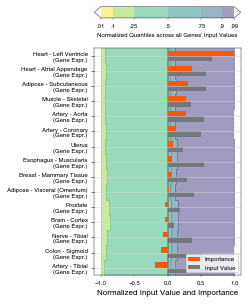

In [89]:
from speos.visualization.settings import *
cen = cm
import matplotlib.pyplot as plt

import matplotlib as mpl
import numpy as np
from matplotlib import cm
from numpy import linspace
import os

orange = '#fd5800'
gray = "#71797E"

get_top_n = 10
get_last_n = 5

labels = list2[:get_last_n] + list2[-get_top_n:]
attributions = list1[:get_last_n] + list1[-get_top_n:]
values = list3[:get_last_n] + list3[-get_top_n:]

start = 0.0
stop = 1.0

number_of_lines = 7
alpha = 0.5
cm_subsection = linspace(stop, start, number_of_lines)
colors = [cm.viridis(x) for x in cm_subsection]
colors = [color[:3] + (alpha,) for color in colors]

q001_, q01_, q25_, q50_, q75_, q90_, q99_ =  [liste[:get_last_n] + liste[-get_top_n:] for liste in [q001_ordered, q01_ordered, q25_ordered, q50_ordered, q75_ordered, q90_ordered, q99_ordered]]

labels = [" ".join([word[0].upper() + word[1:] for word in label.split(" ")]) for label in labels]
labels = ["-".join([word[0].upper() + word[1:] for word in label.split("-")]) for label in labels]
labels = ["Z-Score " + label[6:]if label.startswith("ZSTAT") else label for label in labels]
labels = ["P-Value " + label[2:] if label.startswith("P ") else label for label in labels]
labels = ["n SNPs " + label[6:] if label.startswith("NSNPS") else label for label in labels]
labels = [label + "\n(GWAS)" if label.startswith(("Z-Score", "P-Value", "n SNPs")) else label + "\n(Gene Expr.)" for label in labels]
labels = [label[8:] if label.startswith("Cells") else label for label in labels]

attributions /= np.max(np.abs(attributions))

x = np.arange(len(labels))  # the label locations

width = 0.35  # the width of the bars

gs_kw = dict(height_ratios=[1, 20])

fig, (ax2, ax) = plt.subplots(2,1, figsize=((full_width/2)*cen, 11*cen), gridspec_kw=gs_kw)
ax.grid(axis="y", color="lightgray", linewidth=0.5)
rects2 = ax.barh(x + width/2, attributions, width, color=orange, label='Importance')
rects1 = ax.barh(x - width/2, values, width, color=gray, label='Input Value')


# Add some text for labels, title and custom x-axis tick labels, etc.
#ax.set_ylabel('Scores')
#ax.set_title('Scores by group and gender')
ax.set_yticks(x, labels)
ax.legend(fontsize=small_font)
ax.axvline(x=1, ymin=0, ymax=len(labels)-2, linestyle=":", color ="lightgray", zorder = -1)
ax.axvline(x=0, ymin=0, ymax=len(labels)-2, color ="gray", zorder = 0)
#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)
steps = []
steps.append(ax.step(x=q001_, y =x + 0.5, where = "post", c="lightgray",zorder=-1, linewidth=0.5)[0])
steps.append(ax.step(x=q01_, y =x + 0.5, where = "post", c="lightgray", zorder=-1, linewidth=0.5)[0])
steps.append(ax.step(x=q25_, y =x +0.5, where = "post", c="lightgray", zorder=-1, linewidth=0.5)[0])
steps.append(ax.step(x=q50_, y =x +0.5, where = "post", c="lightgray", zorder=-1, linewidth=0.5)[0])
steps.append(ax.step(x=q75_, y =x +0.5, where = "post", c="lightgray", zorder=-1, linewidth=0.5)[0])
steps.append(ax.step(x=q90_, y =x +0.5, where = "post", c="lightgray", zorder=-1, linewidth=0.5)[0])
steps.append(ax.step(x=q99_, y =x +0.5, where = "post", c="lightgray", zorder=-1, linewidth=0.5)[0])

for i in range(1, len(steps)):
    ax.fill_betweenx(y=[value-0.5 if index %2 == 0 else value+0.5 for index, value in enumerate(np.repeat(x,2))], 
                     x1=np.repeat(steps[i-1].get_xdata(), 2), 
                     x2=np.repeat(steps[i].get_xdata(), 2), zorder=-1,
                     color =colors[i-1],
                     linewidth=0.5)

ax.set_ylim((-0.5, len(labels) -0.5))         
ax.set_xlabel("Normalized Input Value and Importance", size=medium_font)
cmap = (mpl.colors.ListedColormap(colors[:len(steps)-1]).with_extremes(over='white', under='white'))


bounds = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cbar = fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=ax2,
    extend='both',
    ticks=bounds,
    spacing='proportional',
    orientation='horizontal',
    label="Normalized Quantiles across all Genes' Input Values"
)

cbar.ax.set_xticklabels([".01", ".1", ".25", ".5", ".75", ".9",".99"], size=small_font) 
cbar.ax.set_xlabel("Normalized Quantiles across all Genes' Input Values", size=small_font) 

fig.tight_layout()
plt.savefig("Input_explanation_{}.svg".format(gene), bbox_inches="tight")
plt.show()

# Dump Values

In [90]:
import pandas as pd
df = pd.DataFrame(columns=["Label", "Input Value", "Importance", "Q.01", "Q.1", "Q.25", "Q.5", "Q.75", "Q.9","Q.99"])

labels = [" ".join([word[0].upper() + word[1:] for word in label.split(" ")]) for label in list2]
labels = ["-".join([word[0].upper() + word[1:] for word in label.split("-")]) for label in labels]
labels = ["Z-Score " + label[6:]if label.startswith("ZSTAT") else label for label in labels]
labels = ["P-Value " + label[2:] if label.startswith("P ") else label for label in labels]
labels = ["n SNPs " + label[6:] if label.startswith("NSNPS") else label for label in labels]
labels = [label + "\n(GWAS)" if label.startswith(("Z-Score", "P-Value", "n SNPs")) else label + "\n(Gene Expr.)" for label in labels]
labels = [label[8:] if label.startswith("Cells") else label for label in labels]

df["Label"] = ["".join(label.split("\n")) for label in labels]
df["Input Value"] = list3
df["Importance"] = list1 / np.max(list1)
df["Q.01"] =  [elem.item() for elem in q001_ordered]
df["Q.1"] = [elem.item() for elem in q01_ordered]
df["Q.25"] =[elem.item() for elem in  q25_ordered]
df["Q.5"] = [elem.item() for elem in q50_ordered]
df["Q.75"] = [elem.item() for elem in q75_ordered]
df["Q.9"] = [elem.item() for elem in q90_ordered]
df["Q.99"] = [elem.item() for elem in q99_ordered]

df.to_csv("Feature_Importance_{}.tsv".format(gene), index=False, sep="\t")

[-1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -0.9999980601453329,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -0.9999658114653664,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -0.9999976669252556,
 -1.0,
 -1.0,
 -0.9993148852155509,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -0.9990738195322614,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -0.9994066635334058,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -0.9999939066347008,
 -1.0,
 -1.0,
 -1.0,
 -0.9992621717532904,
 -1.0,
 -0.9999994988676193,
 -1.0,
 -0.9999441057452733,
 -1.0,
 -0.9999999693665347,
 -0.9995501918593939,
 -0.9975280888127842,
 -0.9995759851689879]

# Reading edge attributions

In [91]:
import torch

#gene = "OBSCN" # "ITGA7" # "TNFSF15"
num_outer = 11
num_inner = 10
ig_attr_edge_all = None
ig_attr_node_all = None
num_processed = 0
for outer_fold in range(0, num_outer):
    for inner_fold in range(0, num_inner + 1):
        if inner_fold == outer_fold:
            continue
        try:
            ig_attr_node = torch.load("/lustre/groups/epigenereg01/projects/ppi-florin/explanations/new_ig_attr_node_outer{}_inner{}_{}.pt".format(outer_fold, inner_fold, gene))
            ig_attr_edge = torch.load("/lustre/groups/epigenereg01/projects/ppi-florin/explanations/new_ig_attr_edge_outer{}_inner{}_{}.pt".format(outer_fold, inner_fold, gene))
            #ig_attr_self = torch.load("/lustre/groups/epigenereg01/projects/ppi-florin/explanations/ig_attr_self_outer{}_inner{}_{}.pt".format(outer_fold, inner_fold, gene))
            #ig_attr_self_abs = torch.load("/lustre/groups/epigenereg01/projects/ppi-florin/explanations/ig_attr_self_abs_outer{}_inner{}_{}.pt".format(outer_fold, inner_fold, gene))
            print("Loaded attributes for outer {} inner {}".format(outer_fold, inner_fold))
            ig_attr_node.requires_grad = False
            ig_attr_edge.requires_grad = False
            #ig_attr_self.requires_grad = False
            #ig_attr_self_abs.requires_grad = False
        except FileNotFoundError:
            print("Attributes for outer {} inner {} not yet calculated.".format(outer_fold, inner_fold))
            continue 

        num_processed += 1


        if ig_attr_edge_all is None:
            ig_attr_edge_all = ig_attr_edge
        else:
            ig_attr_edge_all += ig_attr_edge

        if ig_attr_node_all is None:
            ig_attr_node_all = ig_attr_node
        else:
            ig_attr_node_all += ig_attr_node

ig_attr_edge_all /= num_processed
ig_attr_node_all /= num_processed

Loaded attributes for outer 0 inner 1
Loaded attributes for outer 0 inner 2
Loaded attributes for outer 0 inner 3
Loaded attributes for outer 0 inner 4
Loaded attributes for outer 0 inner 5
Loaded attributes for outer 0 inner 6
Loaded attributes for outer 0 inner 7
Loaded attributes for outer 0 inner 8
Loaded attributes for outer 0 inner 9
Loaded attributes for outer 0 inner 10
Loaded attributes for outer 1 inner 0
Loaded attributes for outer 1 inner 2
Loaded attributes for outer 1 inner 3
Loaded attributes for outer 1 inner 4
Loaded attributes for outer 1 inner 5
Loaded attributes for outer 1 inner 6
Loaded attributes for outer 1 inner 7
Loaded attributes for outer 1 inner 8
Loaded attributes for outer 1 inner 9
Loaded attributes for outer 1 inner 10
Loaded attributes for outer 2 inner 0
Loaded attributes for outer 2 inner 1
Loaded attributes for outer 2 inner 3
Loaded attributes for outer 2 inner 4
Loaded attributes for outer 2 inner 5
Loaded attributes for outer 2 inner 6
Loaded att

In [92]:
from speos.utils.nn_utils import typed_edges_to_sparse_tensor

edge_index, encoder = typed_edges_to_sparse_tensor(dataset.data.x, dataset.data.edge_index_dict)
row, col, value = edge_index.coo()
edge_index = torch.vstack((edge_index.storage.row(), edge_index.storage.col()))
    
k = 100
print("edges:")
top_indices = torch.topk(ig_attr_edge_all, k).indices
top_edges = [(id2hgnc[key1.item()], dataset.data.y[key1.item()].item(), id2hgnc[key2.item()],  dataset.data.y[key2.item()].item(), encoder.inverse_transform([int(edge.item())])[0], value.item()) for key1, key2, edge, value in zip(edge_index[0, top_indices], edge_index[1, top_indices], value[top_indices].long(), ig_attr_edge_all[top_indices])]
df = pd.DataFrame(data=top_edges, columns=["Sender", "Sender Label", "Receiver", "Receiver Label", "Edge Type", "Importance"])
for column in df.columns:
    if column.endswith("Label"):
        df[column] = df[column].astype(int)
df.to_csv("Edge_Importance_{}.tsv".format(gene), sep="\t", index=False)
[print(top_edge) for top_edge in top_edges]
#print(ig_attr_self_abs_all)
print("Nodes:")
indices = torch.topk(ig_attr_node_all, k).indices
top_nodes = [(id2hgnc[key.item()], dataset.data.y[key.item()].item(), importance.item()) for key, importance in zip(indices, ig_attr_node_all[indices])]
df = pd.DataFrame(data=top_nodes, columns=["Node", "Label", "Importance"])
for column in df.columns:
    if column.endswith("Label"):
        df[column] = df[column].astype(int)
df.to_csv("Neighborhood_Importance_{}.tsv".format(gene), sep="\t", index=False)
[print(top_node) for top_node in top_nodes]

edges:
('ESRRA', 0.0, 'ITGA7', 0.0, 'GRNDButerus', 0.6770057108212368)
('FHL2', 0.0, 'ITGA7', 0.0, 'IntActPA', 0.5499760721629496)
('ZBTB7B', 0.0, 'ITGA7', 0.0, 'GRNDBbreast', 0.5288073517527282)
('PCNA', 0.0, 'ITGA7', 0.0, 'IntActPA', 0.5177628458768444)
('GATA5', 0.0, 'ITGA7', 0.0, 'GRNDBstomach', 0.4980057046273453)
('SLC25A4', 1.0, 'ITGA7', 0.0, 'hetionetregulates', 0.21713291390005912)
('RARA', 0.0, 'ITGA7', 0.0, 'GRNDBbloodx', 0.18558366243937072)
('ZBTB7B', 0.0, 'ITGA7', 0.0, 'GRNDBbloodx', 0.18513951157557548)
('CUX1', 0.0, 'ITGA7', 0.0, 'GRNDBbloodx', 0.18137985286110653)
('REST', 1.0, 'ITGA7', 0.0, 'GRNDBpituitary', 0.17899257635216234)
('NFKB1', 1.0, 'ITGA7', 0.0, 'GRNDBpituitary', 0.1775797113870098)
('ETV6', 0.0, 'ITGA7', 0.0, 'GRNDBpituitary', 0.1769893310301365)
('ERG', 0.0, 'ITGA7', 0.0, 'GRNDBskin', 0.16894165062869326)
('TFAP2A', 0.0, 'ITGA7', 0.0, 'GRNDBskin', 0.16664016156695388)
('NFIB', 0.0, 'ITGA7', 0.0, 'GRNDBskin', 0.16634939257503742)
('GRHL2', 0.0, 'ITGA7', 0

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [11]:
incoming = (edge_index[1,:] == dataset.preprocessor.hgnc2id[gene]).nonzero(as_tuple=True)[0]
incoming_attribute =  ig_attr_edge_all[incoming]
incoming_type =  value[incoming]
means = {}
for i in value.unique(sorted=True):
    means.update({encoder.inverse_transform([int(i.item())])[0]: incoming_attribute[incoming_type == i].mean().item()})
print(means)


{'BioPlex30293T': 0.025766664285087282, 'BioPlex30HCT116': 0.027362488675400278, 'GRNDBadiposetissue': 0.1434436208936547, 'GRNDBadrenalgland': 0.047450427639557397, 'GRNDBbloodvessel': 0.057605546928072654, 'GRNDBbloodx': 0.17989421293964622, 'GRNDBbrain': 0.0742615652860456, 'GRNDBbreast': 0.5473199089041664, 'GRNDBcolon': 0.1217525981357848, 'GRNDBesophagus': 0.07875532515565399, 'GRNDBheart': 0.054517661061451284, 'GRNDBkidney': 0.04170679273200298, 'GRNDBliver': 0.0689287648320527, 'GRNDBlung': 0.1388519966107765, 'GRNDBmuscle': 0.12875590416238916, 'GRNDBnerve': 0.030654950212924643, 'GRNDBovary': 0.0552121636741924, 'GRNDBpancreas': 0.040245499013627874, 'GRNDBpituitary': 0.17812346880935226, 'GRNDBprostate': 0.08336348274241856, 'GRNDBsalivarygland': 0.03726499968350684, 'GRNDBskin': 0.16736259612950902, 'GRNDBsmallintestine': 0.1684083982338795, 'GRNDBspleen': 0.028519900092539227, 'GRNDBstomach': 0.5033663669045969, 'GRNDBtestis': 0.03722306296560747, 'GRNDBthyroid': 0.044460

In [12]:
import numpy as np

total_means = {}
for i in value.unique(sorted=True):
    total_means.update({encoder.inverse_transform([int(i.item())])[0]: ig_attr_edge_all[value == i].median().item()})

min = np.min(list(total_means.values()))
max = np.max(list(total_means.values()))

for key in total_means.keys():
    total_means[key] = (total_means[key] - min) / (max - min)
print(total_means)

{'BioPlex30293T': 0.12967892265129816, 'BioPlex30HCT116': 0.13330406014355745, 'GRNDBadiposetissue': 0.47741942854384745, 'GRNDBadrenalgland': 0.2652633089457132, 'GRNDBbloodvessel': 0.23374228182323897, 'GRNDBbloodx': 0.24958563123307836, 'GRNDBbrain': 0.24279518539177264, 'GRNDBbreast': 0.3424935180777201, 'GRNDBcolon': 0.20194079213195326, 'GRNDBesophagus': 0.21108719199563086, 'GRNDBheart': 0.20322806940619054, 'GRNDBkidney': 0.1758750109454201, 'GRNDBliver': 0.18689412354570686, 'GRNDBlung': 0.21283662296002756, 'GRNDBmuscle': 0.19357497492839143, 'GRNDBnerve': 0.1815156798737444, 'GRNDBovary': 0.22766151178227076, 'GRNDBpancreas': 0.1534600109394869, 'GRNDBpituitary': 0.20898213995465703, 'GRNDBprostate': 0.1888675130931929, 'GRNDBsalivarygland': 0.15697757274064633, 'GRNDBskin': 0.25080692772124463, 'GRNDBsmallintestine': 0.20236941398583588, 'GRNDBspleen': 0.19888230366317058, 'GRNDBstomach': 0.16475783981207165, 'GRNDBtestis': 0.25412411770328763, 'GRNDBthyroid': 0.20219097896

In [80]:
list(total_means.values())

[1.255305077594946e-05,
 7.407768623238731e-06,
 2.421147069496776e-05,
 1.5411321022203624e-05,
 1.1955602532286726e-05,
 1.3378587854174316e-05,
 1.9917303912482304e-05,
 2.403598120673378e-05,
 1.4364001729942925e-05,
 1.7812497974574104e-05,
 1.202513592675716e-05,
 1.1099013339902664e-05,
 1.2452906258285293e-05,
 1.666220596486747e-05,
 1.4943504418630438e-05,
 1.3046633537392201e-05,
 1.3037012036922414e-05,
 8.276507265682213e-06,
 1.475968812575849e-05,
 1.360771729336552e-05,
 1.1162052560364299e-05,
 1.736444472688262e-05,
 1.4417885488418307e-05,
 1.386661287750437e-05,
 1.178169760466628e-05,
 1.710118607611491e-05,
 1.210117386617353e-05,
 1.7724678549007274e-05,
 1.741036253362411e-05,
 8.56919555946914e-06,
 4.651709445440809e-05,
 1.1789282232957943e-05,
 1.8654933034621513e-05,
 3.4878139731822045e-06]

In [61]:
import networkx as nx
list(nx.all_shortest_paths(G,15145, dataset.preprocessor.hgnc2id["HBB"], ))

[[15145, 6534, 5682, 6162],
 [15145, 9346, 5682, 6162],
 [15145, 16229, 5682, 6162],
 [15145, 6534, 7331, 6162],
 [15145, 6531, 7331, 6162],
 [15145, 16621, 7331, 6162],
 [15145, 9346, 7331, 6162],
 [15145, 6534, 9592, 6162],
 [15145, 9602, 9592, 6162],
 [15145, 6534, 3134, 6162],
 [15145, 16229, 3134, 6162],
 [15145, 9743, 3134, 6162],
 [15145, 6534, 12744, 6162],
 [15145, 10400, 12744, 6162],
 [15145, 9346, 12744, 6162],
 [15145, 16229, 12744, 6162],
 [15145, 5805, 12744, 6162],
 [15145, 6534, 520, 6162],
 [15145, 16229, 520, 6162],
 [15145, 6534, 11477, 6162],
 [15145, 10400, 11477, 6162],
 [15145, 16229, 11477, 6162],
 [15145, 6534, 12556, 6162],
 [15145, 9602, 12556, 6162],
 [15145, 3653, 12556, 6162],
 [15145, 6534, 4933, 6162],
 [15145, 6534, 1035, 6162],
 [15145, 9346, 1035, 6162],
 [15145, 16229, 1035, 6162],
 [15145, 13750, 1035, 6162],
 [15145, 6534, 6320, 6162],
 [15145, 9602, 6320, 6162],
 [15145, 12557, 6320, 6162],
 [15145, 14582, 6320, 6162],
 [15145, 6534, 10754, 6162]

In [68]:
 id2hgnc[6342],  id2hgnc[6162]

('HNF4G', 'HBB')

In [48]:
edge_index, encoder = typed_edges_to_sparse_tensor(dataset.data.x, dataset.data.edge_index_dict)
edge_index[6749, 14079]

SparseTensor(row=tensor([0]),
             col=tensor([0]),
             val=tensor([33.]),
             size=(1, 1), nnz=1, density=100.00%)

In [49]:
encoder.inverse_transform([33])

array(['hetionetregulates'], dtype='<U19')

In [106]:
 dataset.data.x[:,features.index("Spleen")].sort().indices[dataset.data.x[:,features.index("Spleen")].sort().values ==  dataset.data.x[6747,features.index("Spleen")]]

tensor([ 6747,  2530, 13074])

In [111]:
(dataset.data.x[:,features.index("Spleen")].sort().values == dataset.data.x[6747,features.index("Spleen")]).nonzero()

tensor([[14426],
        [14427],
        [14428]])

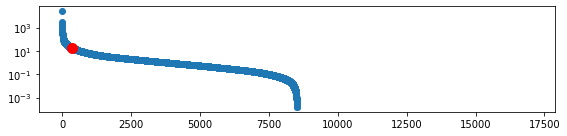

In [156]:
fig, ax = plt.subplots(figsize=(8,2))
values = dataset.data.x[:,features.index("Whole Blood")].sort(descending=True).values
good_value = dataset.data.x[6749,features.index("Whole Blood")]
point = (values == good_value).nonzero()[0]
x = len(values.numpy())
ax.scatter(y =values.numpy(), x=range(x))
ax.scatter(x=point, y=good_value, color="red", zorder = 20, s=100)
ax.set_yticks([])
plt.yscale("log")
fig.tight_layout()
plt.show()

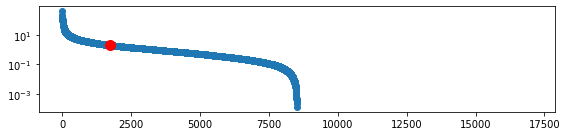

In [54]:

fig, ax = plt.subplots(figsize=(8,2))
values = dataset.data.x[:,features.index("Spleen")].sort(descending=True).values
good_value = dataset.data.x[6749,features.index("Spleen")]
point = (values == good_value).nonzero()[0]
x = len(values.numpy())
ax.scatter(y =values.numpy(), x=range(x))
ax.scatter(x=point, y=good_value, color="red", zorder = 20, s=100)
ax.set_yticks([])
plt.yscale("log")
fig.tight_layout()
plt.show()

In [56]:
good_value, features.index("Spleen")

(tensor(2.0670, dtype=torch.float64), 67)

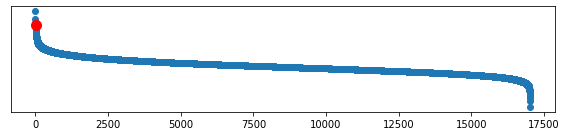

In [152]:
fig, ax = plt.subplots(figsize=(8,2))
values = dataset.data.x[:,features.index("ZSTAT CEL")].sort(descending=True).values
good_value = dataset.data.x[6749,features.index("ZSTAT CEL")]
point = (values == good_value).nonzero()[0]
x = len(values.numpy())
ax.scatter(y =values.numpy(), x=range(x))
ax.scatter(x=point, y=good_value, color="red", zorder = 20, s=100)
ax.set_yticks([])
fig.tight_layout()
plt.show()

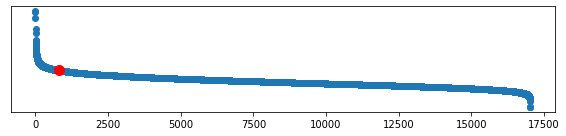

In [157]:
fig, ax = plt.subplots(figsize=(8,2))
values = dataset.data.x[:,features.index("ZSTAT SLE")].sort(descending=True).values
good_value = dataset.data.x[6749,features.index("ZSTAT SLE")]
point = (values == good_value).nonzero()[0]
x = len(values.numpy())
ax.scatter(y =values.numpy(), x=range(x))
ax.scatter(x=point, y=good_value, color="red", zorder = 20, s=100)
ax.set_yticks([])
fig.tight_layout()
plt.show()


# TNFSF15

In [158]:
input_attributions = [ 2.3595e-04,  2.2081e-01,  1.0809e-02,  3.5428e-03,  5.8589e-02,
        -2.2470e-03,  1.1522e-02,  8.8408e-01,  2.2690e-01,  6.4677e-03,
         8.4217e-01,  1.3804e-01,  9.9149e-04,  1.9190e-01,  1.3477e-01,
        -1.2342e-02,  3.6009e-02, -1.7483e-02, -1.5790e-02,  7.6274e-03,
         1.1646e-02, -6.2127e-02, -6.0817e-02,  7.9029e-03,  1.2730e-02,
         4.6990e-03,  3.7365e-02,  2.1007e-02,  2.9657e-02,  5.1056e-02,
         4.9612e-02, -2.3130e-02, -2.6029e-02,  5.4716e-02,  5.3025e-02,
         2.3937e-02,  9.8034e-04,  3.2543e-02,  2.4434e-02,  4.5017e-02,
         8.6351e-02, -3.1979e-02, -4.6847e-02,  2.2915e-03, -2.3557e-02,
         2.1438e-02,  2.4220e-02,  5.7059e-02,  3.4144e-02,  2.8384e-02,
         2.1353e-03, -1.7903e-02, -2.9233e-02,  9.8134e-03, -5.7230e-04,
        -1.1897e-02, -1.3461e-02,  8.0160e-04,  2.3829e-02,  1.2950e-02,
         4.8744e-02,  1.6055e-02,  3.1690e-02, -1.4306e-02, -3.2824e-02,
        -5.9924e-03, -2.7241e-02, -6.9698e-02,  2.7340e-02,  9.9719e-02,
        -3.0925e-02,  4.5805e-02,  1.3013e-02, -2.3272e-02, -3.7933e-02,
         1.6752e-03, -2.3936e-01, -2.4676e-02,  6.2654e-02,  1.8284e-01,
         9.8897e-02,  1.0400e-01, -1.9713e-02,  4.8213e-02, -6.2833e-02,
        -2.4412e-01,  3.0818e-02, -9.3616e-03, -8.6814e-02,  7.2334e-02,
        -6.2430e-02, -1.7569e-02, -1.4903e-01]

In [161]:
input_values = normalized_data[15145].tolist()

In [162]:
list1, list2, list3 = zip(*sorted(zip(input_attributions, features, input_values)))

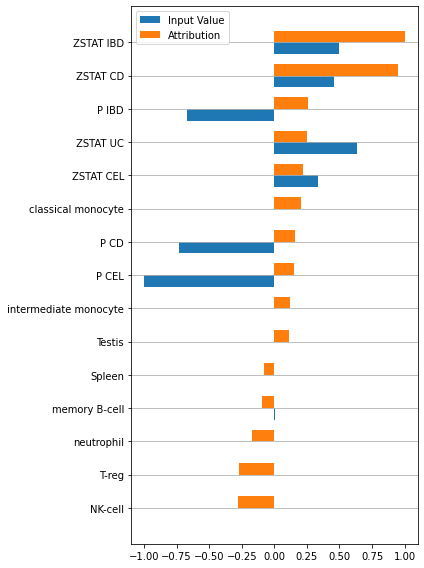

In [163]:
import matplotlib.pyplot as plt
import numpy as np


get_top_n = 10
get_last_n = 5

labels = list2[:get_last_n] + list2[-get_top_n:]
attributions = list1[:get_last_n] + list1[-get_top_n:]
values = list3[:get_last_n] + list3[-get_top_n:]

attributions /= np.max(np.abs(attributions))
values /= np.max(np.abs(values))
"""
attributions = np.asarray(list1)
attributions /= np.max(np.abs(attributions))
mask = np.abs(attributions) > 0.05

labels = np.asarray(list2)[mask]

attributions = np.asarray(list1)[mask]
values = np.asarray(list3)
values /= np.max(np.abs(values))
values = values[mask]
"""

x = np.arange(len(labels))  # the label locations

width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(6,8))
ax.grid(axis="y")
rects1 = ax.barh(x - width/2, values, width, label='Input Value')
rects2 = ax.barh(x + width/2, attributions, width, label='Attribution')

# Add some text for labels, title and custom x-axis tick labels, etc.
#ax.set_ylabel('Scores')
#ax.set_title('Scores by group and gender')
ax.set_yticks(x, labels)
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [46]:
import matplotlib.font_manager
import os
fm = matplotlib.font_manager.json_load(os.path.expanduser("~/.cache/matplotlib/fontlist-v330.json"))

fm.findfont("Helvetica", rebuild_if_missing=False)

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


'/home/icb/florin.ratajczak/anaconda3/envs/compat/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'

In [49]:
import matplotlib.font_manager as font_manager

font_dirs = ['/home/icb/florin.ratajczak/anaconda3/envs/compat/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# set font
plt.rcParams['font.family'] = 'Helvetica'

In [1]:
from statsmodels.stats.multitest import fdrcorrection
from speos.scripts.utils import fdr
from numpy.random import normal

dist = normal(0.5, 0.5, 6)
dist[dist < 0] =  - dist[dist < 0]

print(dist)
print(fdrcorrection(dist, method="n")[1])
print(fdr(dist))

ModuleNotFoundError: No module named 'speos.scripts'

In [10]:
result = fdrcorrection([0.009384417, 0.538812145, 0.606484092,0.16535688,1.0729e-06,
               0.085567091, 0.356643236, 3.87723e-05, 0.050995128, 0.000179278,
               0.004145262, 0.023121884, 0.8422981, 0.097733941, 1.49545e-29,
               0.146530707,	0.025804362, 0.332718847, 0.048806636, 0.003480535,
               0.027829743,	0.200558821, 0.875465128, 0.032261077, 0.039507554])

print(result[1].reshape((5,-1)))
print(result[0].reshape((5,-1)))

[[3.35157750e-02 6.12286528e-01 6.59221839e-01 2.29662333e-01
  1.34112500e-05]
 [1.42611818e-01 4.24575281e-01 3.23102500e-04 9.10627286e-02
  1.12048750e-03]
 [1.72719250e-02 6.95743575e-02 8.75465128e-01 1.52709283e-01
  3.73862500e-28]
 [2.15486334e-01 6.95743575e-02 4.15898559e-01 9.10627286e-02
  1.72719250e-02]
 [6.95743575e-02 2.63893186e-01 8.75465128e-01 7.33206295e-02
  8.23074042e-02]]
[[ True False False False  True]
 [False False  True False  True]
 [ True False False False  True]
 [False False False False  True]
 [False False False False False]]


In [1]:
import os
os.chdir("/home/icb/florin.ratajczak/ppi-core-genes/")
from speos.preprocessing.preprocessor import PreProcessor
from speos.preprocessing.mappers import *
from speos.utils.config import Config
from speos.datasets import DatasetBootstrapper

config = Config()

config.parse_yaml("configs/config_immune_dysregulation_film_forreal.yaml")

/home/icb/florin.ratajczak/anaconda3/envs/compat/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at  /opt/conda/conda-bld/pytorch_1614378098133/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
config.input.randomize_adjacency_percent = 100
config.name = "random"

pre_mappings = GWASMapper().get_mappings(config.input.tag, fields=config.input.field)

mappings = []

for mapping in pre_mappings:
    if not "AMD" in mapping["name"]:
        mappings.append(mapping)

adjacencies = AdjacencyMapper(config.input.adjacency_mappings, blacklist=config.input.adjacency_blacklist).get_mappings(config.input.adjacency, fields=config.input.adjacency_field)

prepro = PreProcessor(config, mappings, adjacencies)
G = prepro.get_graph(features=False)

In [5]:
import networkx as nx
print(nx.info(G))

Name: 
Type: MultiDiGraph
Number of nodes: 19220
Number of edges: 5061088
Average in degree: 263.3240
Average out degree: 263.3240


In [7]:
with open("data/random_graph_1.tsv", "w") as file:
    for edge in G.edges:
        file.writelines("{}\t{}\n".format(prepro.id2hgnc[edge[0]], prepro.id2hgnc[edge[1]]))


In [8]:
config = Config()

config.parse_yaml("configs/config_cardiovascular_film.yaml")
config.input.randomize_adjacency_percent = 100
config.name = "random_2"

pre_mappings = GWASMapper().get_mappings(config.input.tag, fields=config.input.field)

mappings = []

for mapping in pre_mappings:
    if not "AMD" in mapping["name"]:
        mappings.append(mapping)

adjacencies = AdjacencyMapper(config.input.adjacency_mappings, blacklist=config.input.adjacency_blacklist).get_mappings(config.input.adjacency, fields=config.input.adjacency_field)

prepro = PreProcessor(config, mappings, adjacencies)
G = prepro.get_graph(features=False)

with open("data/random_graph_2.tsv", "w") as file:
    for edge in G.edges:
        file.writelines("{}\t{}\n".format(prepro.id2hgnc[edge[0]], prepro.id2hgnc[edge[1]]))

random 2022-12-12 10:41:21,474 [INFO] speos.preprocessing.preprocessor: Using Adjacency matrices: ['BioPlex30HCT116', 'BioPlex30293T', 'HuRI', 'IntActPA', 'IntActDirect', 'hetionetregulates', 'hetionetcovaries', 'GRNDBadiposetissue', 'GRNDBadrenalgland', 'GRNDBbloodx', 'GRNDBbloodvessel', 'GRNDBbrain', 'GRNDBbreast', 'GRNDBcolon', 'GRNDBesophagus', 'GRNDBheart', 'GRNDBkidney', 'GRNDBliver', 'GRNDBlung', 'GRNDBmuscle', 'GRNDBnerve', 'GRNDBovary', 'GRNDBpancreas', 'GRNDBpituitary', 'GRNDBprostate', 'GRNDBsalivarygland', 'GRNDBskin', 'GRNDBsmallintestine', 'GRNDBspleen', 'GRNDBstomach', 'GRNDBtestis', 'GRNDBthyroid', 'GRNDButerus', 'GRNDBvagina']
random 2022-12-12 10:41:21,475 [INFO] speos.preprocessing.preprocessor: Using 7 mappings with ground truth data/mendelian_gene_sets/Immune_Dysregulation_genes.bed 
random 2022-12-12 10:45:17,121 [INFO] speos.preprocessing.preprocessor: Name: 
Type: MultiDiGraph
Number of nodes: 19220
Number of edges: 5061088
Average in degree: 263.3240
Average ou

In [9]:
with open("data/random_graph_cardio.tsv", "w") as file:
    for edge in dataset.preprocessor.G.edges:
        file.writelines("{}\t{}\n".format(dataset.preprocessor.id2hgnc[edge[0]], dataset.preprocessor.id2hgnc[edge[1]]))

# Plotting Network Characteristics

In [1]:
import os
os.chdir("/home/icb/florin.ratajczak/ppi-core-genes/")
from speos.utils.config import Config
from speos.visualization.diagnosticwrapper import GraphDiagnosticWrapper

import os
from speos.visualization.settings import *
import matplotlib.pyplot as plt

config = Config()
config.logging.dir = "speos/tests/logs/"

config.name = "DiagnosticTest"
config.model.save_dir = "speos/tests/models/"
config.inference.save_dir = "speos/tests/results"
config.model.plot_dir = "speos/tests/plots"

DiagnosticTest 2022-12-19 11:57:53,177 [INFO] speos.preprocessing.preprocessor: Using Adjacency matrices: ['IntActDirect']
DiagnosticTest 2022-12-19 11:57:53,178 [INFO] speos.preprocessing.preprocessor: Using 7 mappings with ground truth data/mendelian_gene_sets/Immune_Dysregulation_genes.bed 
DiagnosticTest 2022-12-19 11:58:13,572 [INFO] speos.preprocessing.preprocessor: Name: 
Type: MultiDiGraph
Number of nodes: 17024
Number of edges: 14411
Average in degree:   0.8465
Average out degree:   0.8465


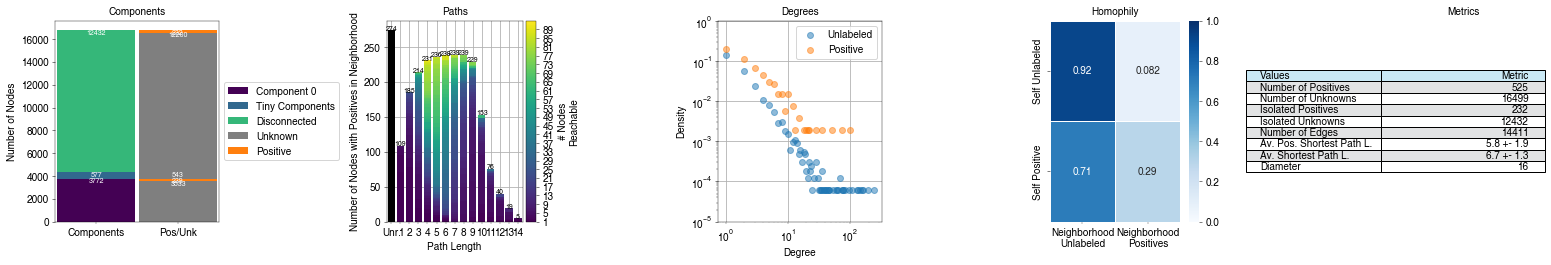

In [20]:

diagnostic = GraphDiagnosticWrapper(config=config, phenotype_tag=["immune_dysregulation"], adjacency_tag="IntAct_Direct", features=True)
params = {'legend.fontsize': large_font,
         'axes.labelsize': large_font,
         'figure.titlesize': large_font,
         'axes.titlesize':large_font,
         'xtick.labelsize':large_font,
         'ytick.labelsize':large_font}
plt.rcParams.update(params)
fig, ax = diagnostic.get_diagnostics(save=False, figsize=(55*cm, 10*cm))
fig.suptitle('')
fig.tight_layout()
#ax.tick_params(axis='both', labelsize=large_font)
plt.savefig("intact_direct_immune_dysregulation.svg", dpi=350)

DiagnosticTest 2022-12-19 12:00:51,980 [INFO] speos.preprocessing.preprocessor: Using Adjacency matrices: ['IntActDirect']
DiagnosticTest 2022-12-19 12:00:51,980 [INFO] speos.preprocessing.preprocessor: Using 7 mappings with ground truth data/mendelian_gene_sets/Immune_Dysregulation_genes.bed 
DiagnosticTest 2022-12-19 12:01:11,973 [INFO] speos.preprocessing.preprocessor: Name: 
Type: MultiDiGraph
Number of nodes: 17024
Number of edges: 14411
Average in degree:   0.8465
Average out degree:   0.8465


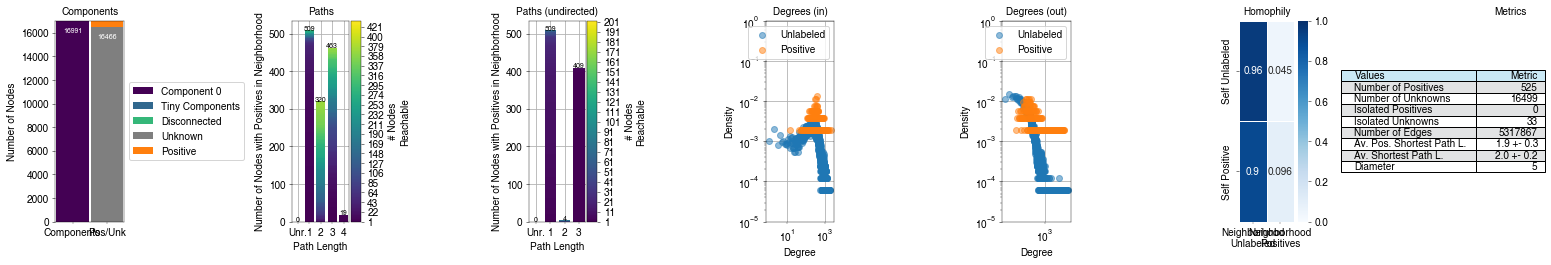

In [21]:
diagnostic = GraphDiagnosticWrapper(config=config, phenotype_tag=["immune_dysregulation"], adjacency_tag="", features=True, merge=True)
params = {'legend.fontsize': large_font,
         'axes.labelsize': large_font,
         'figure.titlesize': large_font,
         'axes.titlesize':large_font,
         'xtick.labelsize':large_font,
         'ytick.labelsize':large_font}
plt.rcParams.update(params)
fig, ax = diagnostic.get_diagnostics(save=False, figsize=(80*cm, 10*cm))
fig.suptitle('')
fig.tight_layout()
#ax.tick_params(axis='both', labelsize=large_font)
plt.savefig("intact_direct_immune_dysregulation.svg", dpi=350)

# Check GWAS Gene Hits

In [5]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import pandas as pd
from speos.visualization.settings import *
import matplotlib.pyplot as plt

def get_mighty_keys(n, results):
    mighty_keys = []
    for key, value in results[0].items():
        if key != "Total" and value > n:
            mighty_keys.append(key)
    return mighty_keys

def get_OR(n, superset, results, setB):
    from scipy.stats import fisher_exact
    try:
        results = set(get_mighty_keys(n,results))
    except TypeError:
        results = set(results)

    array = pp.make_contingency_table(superset,results,setB)

    odds_ratio, pval = fisher_exact(array)

    return odds_ratio, pval, array

import numpy as np
from statsmodels.stats.multitest import fdrcorrection as fdr       

diseases = ["immune_dysregulation", "cardiovascular_disease", "diabetes", "insulin_disorder", "bm_disorder"]

for disease in diseases:
    config = Config()
    config_disease = disease if not "cardiovascular" in disease else "cardiovascular"
    config.parse_yaml("configs/config_{}_tag.yaml".format(config_disease))

    pp = PostProcessor(config)

    import json

            
    outer_results_path = "/home/icb/florin.ratajczak/ppi-core-genes/data/mapped_genes/closest/causal/{}_outer_results.json".format(disease)
    try:
        with open(outer_results_path, "r") as file:
            results = json.load(file)
    except FileNotFoundError:
        continue

    unknown_genes, all_genes, positive_genes = pp.get_unknown_genes(pp.results_paths[0][0])
    background = set(pp.get_mouse_knockout_background("~/ppi-core-genes/data/mgi/background.txt"))
    valid_background = background.intersection(all_genes)
    print("Number of Background genes: {}".format(len(valid_background)))
    valid_unlabeled_background = valid_background.intersection(unknown_genes)
    print("Number of unlabeled Background genes: {}".format(len(valid_unlabeled_background)))

    mousegenes = set(pp.get_mouse_knockout_genes("~/ppi-core-genes/data/mgi/{}.txt".format(pp.get_doid())))
    valid_mousegenes = pp.return_only_valid(mousegenes, valid_background)
    valid_unlabeled_mousegenes = pp.return_only_valid(mousegenes, valid_unlabeled_background)
    print("Number of unlabeled Mouse Genes genes: {}".format(len(valid_unlabeled_mousegenes)))
            #print("{} {}: {} positives".format(phenotype, method, len(positive_genes)))
    groups = []
    ors = []
    pvals = []
    strengths = []
    n_candidates_and_mko = []
    n_candidates_not_mko = []
    n_not_candidates_and_mko = []
    n_not_candidates_not_mko = []

    for i in range(1):
        group = ">= {}".format(i + 1)
        groups.append(group)
        odds_ratio, pval, array = get_OR(i, valid_unlabeled_background, results, valid_unlabeled_mousegenes)
        ors.append(odds_ratio)
        pvals.append(pval)
        strength = len(get_mighty_keys(i, results))
        strengths.append(strength)

    print("{}: p={}, OR={}, n candidates ={}".format(disease, pvals[0], ors[0], strengths[0]))
    print(array)

Number of Background genes: 14443
Number of unlabeled Background genes: 13935
Number of unlabeled Mouse Genes genes: 1251
immune_dysregulation: p=7.237894784664737e-05, OR=2.0115332428765265, n candidates =333
[[   45  1206]
 [  231 12453]]


immune_dysregulation_tag 2023-01-24 14:20:43,210 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/background.txt
immune_dysregulation_tag 2023-01-24 14:20:44,038 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/immune_dysreg_query.txt
immune_dysregulation_tag 2023-01-24 14:20:44,416 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/background.txt
immune_dysregulation_tag 2023-01-24 14:20:44,860 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/cad_query.txt


Number of Background genes: 14680
Number of unlabeled Background genes: 14116
Number of unlabeled Mouse Genes genes: 517
cardiovascular_disease: p=0.8032039346180189, OR=1.0343034055727554, n candidates =1338
[[   42   475]
 [ 1071 12528]]


In [2]:
#handler_paths = {"Insulin Disorder": "/home/icb/florin.ratajczak/ppi-core-genes/results/insulin_disorder.h5",
#                 "Monogenic Diabetes": "/home/icb/florin.ratajczak/ppi-core-genes/results/diabetes.h5",
#                 "Bodymass Disorder": "/home/icb/florin.ratajczak/ppi-core-genes/results/bm_disorder3.h5",
#                 "Cardiovascular Disease": "/home/icb/florin.ratajczak/ppi-core-genes/results/cardiovascular5.h5",
#                 "Immune Dysregulation": "/home/icb/florin.ratajczak/ppi-core-genes/results/immune_dysregulation.h5"}

#handler = ResultsHandler(handler_paths[phenotype], read_only=True)
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import pandas as pd
from speos.visualization.settings import *
import matplotlib.pyplot as plt

def get_mighty_keys(n, results):
    mighty_keys = []
    for key, value in results[0].items():
        if key != "Total" and value > n:
            mighty_keys.append(key)
    return mighty_keys

def get_OR(n, superset, results, setB):
    from scipy.stats import fisher_exact
    try:
        results = set(get_mighty_keys(n,results))
    except TypeError:
        results = set(results)

    array = pp.make_contingency_table(superset,results,setB)

    odds_ratio, pval = fisher_exact(array)

    return odds_ratio, pval, array

import numpy as np
from statsmodels.stats.multitest import fdrcorrection as fdr

background = None

phenotypes = ["Cardiovascular Disease", "Immune Dysregulation", "Body Mass Disorders", "Diabetes", "Insulin Disorders"]
methods = ["film", "tag", "gcn", "n2vmlp", "mlp"]
pretty_methods = ["FiLM", "TAG", "GCN", "N2V+MLP", "MLP"]

tick_size = small_font
label_size = medium_font
title_size = medium_font

crimson = "#6f0000"
navy = "#02055a"
jungle = "#1e5631"
tan = "#c24e00"
petrol = "#005f6a"
grey = "#bbbbbb"
lightgrey = "#dddddd"
width_ratios = [10, 1]*2
marker_size = 4


colors_ = [crimson, jungle, tan, navy, petrol]
markers = ["^", "v", "o", "s", "p"]
min_strength = 1000

outer_dfs_list = []
for frame_idx, (phenotype, color) in enumerate(zip(phenotypes, colors_)):
    if frame_idx == 5:
        break
    dfs = []
    for pretty_method, method, marker in zip(pretty_methods, methods, markers):
        _columns= ["Method", "CS/Mendelian", "N Candidate/Mendelian and MKO", "N Candidate/Mendelian not MKO", "N Not Candidate/Mendelian and MKO", "N Not Candidate/Mendelian Not MKO", "OR", "pval unadjusted", "pval adjusted (FDR)"]
        df = pd.DataFrame(data=np.empty((12, len(_columns))), columns=_columns)
        if method in ["gcn", "mlp", "n2vmlp"] and phenotype == "Immune Dysregulation":
            method += "_new"
        
        if method == "film" and phenotype == "Immune Dysregulation":
            method += "_forreal"
    
        config_paths = {"Insulin Disorders": "configs/config_insulin_disorder_{}.yaml".format(method),
                        "Diabetes": "configs/config_diabetes_{}.yaml".format(method),
                        "Body Mass Disorders": "configs/config_bm_disorder_{}.yaml".format(method),
                        "Cardiovascular Disease": "configs/config_cardiovascular_{}.yaml".format(method),
                        "Immune Dysregulation": "configs/config_immune_dysregulation_{}.yaml".format(method)}
        
        #if method == "film" and phenotype == "Immune Dysregulation":
        #    config_paths[phenotype] = "configs/config_immune_dysregulation_{}_forreal.yaml".format(method)

        config = Config()
        config.parse_yaml(config_paths[phenotype])

        pp = PostProcessor(config)

        import json
        
        gwas_outer_results_paths = {"Insulin Disorders": "/home/icb/florin.ratajczak/ppi-core-genes/data/mapped_genes/closest/insulin_disorder_outer_results.json",
                        "Diabetes": "/home/icb/florin.ratajczak/ppi-core-genes/data/mapped_genes/closest/diabetes_outer_results.json",
                        "Body Mass Disorders": "/home/icb/florin.ratajczak/ppi-core-genes/data/mapped_genes/closest/bm_disorder_outer_results.json",
                        "Cardiovascular Disease": "/home/icb/florin.ratajczak/ppi-core-genes/data/mapped_genes/closest/cardiovascular_disease_outer_results.json",
                        "Immune Dysregulation": "/home/icb/florin.ratajczak/ppi-core-genes/data/mapped_genes/closest/immune_dysregulation_outer_results.json"}

        with open(gwas_outer_results_paths[phenotype], "r") as file:
            gwas_results = json.load(file)

        gwas_genes = set(gwas_results[0].keys())
        print("GWAS candidate Genes: {}".format(len(gwas_genes)))
        unknown_genes, all_genes, positive_genes = pp.get_unknown_genes(pp.results_paths[0][0])
        background = set(pp.get_mouse_knockout_background())
        valid_background = background.intersection(all_genes)
        print("Number of Background genes: {}".format(len(valid_background)))
        valid_unlabeled_background = valid_background.intersection(unknown_genes)
        print("Number of unlabeled Background genes: {}".format(len(valid_unlabeled_background)))
        valid_gwas_genes = gwas_genes.intersection(unknown_genes)
        #valid_gwas_genes = gwas_genes
        print("Number of unlabeled valid GWAS genes: {}".format(len(valid_gwas_genes)))
        mousegenes = set(pp.get_mouse_knockout_genes())
        valid_mousegenes = pp.return_only_valid(mousegenes, valid_background)
        valid_unlabeled_mousegenes = pp.return_only_valid(mousegenes, valid_unlabeled_background)
        print("Number of unlabeled Mouse Genes genes: {}".format(len(valid_unlabeled_mousegenes)))
        
        gwas_odds_ratio, gwas_pval, array = get_OR(1, valid_background, valid_gwas_genes, valid_mousegenes)

        df.loc[0, :] = ["-", "GWAS", array[0][0], array[1][0], array[0][1], array[1][1], gwas_odds_ratio, gwas_pval, None]

        outer_results_paths = {"Insulin Disorders": "/lustre/groups/epigenereg01/projects/ppi-florin/results/insulin_disorder_{}outer_results.json".format(method),
                        "Diabetes": "/lustre/groups/epigenereg01/projects/ppi-florin/results/diabetes_{}outer_results.json".format(method),
                        "Body Mass Disorders": "/lustre/groups/epigenereg01/projects/ppi-florin/results/bm_disorder_{}outer_results.json".format(method),
                        "Cardiovascular Disease": "/lustre/groups/epigenereg01/projects/ppi-florin/results/cardiovascular_{}outer_results.json".format(method),
                        "Immune Dysregulation": "/lustre/groups/epigenereg01/projects/ppi-florin/results/immune_dysregulation_{}outer_results.json".format(method)}

        
        #outer_results_paths[phenotype] = "/lustre/groups/epigenereg01/projects/ppi-florin/results/immune_dysregulation_{}_forrealouter_results.json".format(method)
        

        with open(outer_results_paths[phenotype], "r") as file:
            results = json.load(file)

        unknown_genes, all_genes, positive_genes = pp.get_unknown_genes(pp.results_paths[0][0])
        if background is None:
            background = set(pp.get_mouse_knockout_background())
        valid_background = background.intersection(all_genes)
        valid_unlabeled_background = valid_background.intersection(unknown_genes)
                
        mousegenes = set(pp.get_mouse_knockout_genes())
        valid_mousegenes = pp.return_only_valid(mousegenes, valid_background)
        valid_unlabeled_mousegenes = pp.return_only_valid(mousegenes, valid_unlabeled_background)
        
        #print("{} {}: {} positives".format(phenotype, method, len(positive_genes)))
        groups = []
        ors = []
        pvals = []
        strengths = []
        n_candidates_and_mko = []
        n_candidates_not_mko = []
        n_not_candidates_and_mko = []
        n_not_candidates_not_mko = []

        for i in range(11):
            group = ">= {}".format(i + 1)
            groups.append(group)
            odds_ratio, pval, array = get_OR(i, valid_unlabeled_background, results, valid_unlabeled_mousegenes)
            ors.append(odds_ratio)
            pvals.append(pval)
            strength = len(get_mighty_keys(i, results))
            strengths.append(strength)
            df.loc[i + 1, :] = [pretty_method, "CS "+ group, array[0][0], array[1][0], array[0][1], array[1][1], odds_ratio, pval, None]
            #print("{}: {}, p: {:.2e}, n: {}".format(group, odds_ratio, pval, strength))

        min_strength = np.min(strengths) if np.min(strengths) < min_strength else min_strength
        m_odds_ratio, m_pval, array = get_OR(i, valid_background, set(positive_genes), valid_mousegenes)
        m_strength = len(positive_genes)
        #print("{}: {}, p: {:.2e}, n: {}".format(group, odds_ratio, pval, strength))
        df.loc[12, :] = ["-", "Mendelian", array[0][0], array[1][0], array[0][1], array[1][1], m_odds_ratio, m_pval, None]

        if phenotype == "Cardiovascular Disease" and method == "tag":
            cvd_strengths = strengths
            cvd_ors = ors
            cvd_mendelian_strength = m_strength
            cvd_mendelian_ors = m_odds_ratio

        
        dfs.append(df)
    
    dfs = pd.concat(dfs)
    
    for column in dfs.columns:
        if "OR" in column:
            dfs[column] = dfs[column].round(3)
        if "N " in column:
            dfs[column] = dfs[column].astype(int)
    outer_dfs_list.append(dfs)

pvals = []
for df in outer_dfs_list:
    pvals.extend(df["pval unadjusted"].tolist())


adj_pvals = fdr(pvals)[1]

for df, adj_pval_one_df, phenotype in zip(outer_dfs_list, np.array_split(adj_pvals, len(outer_dfs_list)), phenotypes):
    print((adj_pval_one_df < 0.05).sum())
    df["pval adjusted (FDR)"] = adj_pval_one_df
    print((df["pval adjusted (FDR)"] < 0.05).sum())
    df.to_csv("statistical_dump/{}_ors_mko_gwas.tsv".format(phenotype), sep="\t", index=False)

fig, axes = plt.subplots(figsize=(full_width*cm,12*cm), nrows=2, ncols=12, sharey=False, gridspec_kw={'width_ratios': [1, 11, 1, 3, 1, 11, 1, 3, 1, 11, 1, 0.1]})
axes = axes.flatten()

for frame_idx, (phenotype, color, (ax0, ax1, ax3, invis_ax), df) in enumerate(zip(phenotypes + ["None"], colors_ + ["None"], np.array_split(axes, 6), outer_dfs_list + ["None"])):
    if frame_idx == 5:
        ax0.axis("off")
        ax1.axis("off")
        ax3.axis("off")
        invis_ax.axis("off")
        handles = [Line2D([0], [0], color="black", marker=marker, markersize=marker_size, label=label + " OR") for marker, label in zip(markers, pretty_methods)]
        handles.extend([Line2D([0], [0], color=grey, marker=marker, label=label + " n") for marker, label in zip(markers, pretty_methods)])
        #handles.extend([Patch(facecolor=color, edgecolor='black', label=label) for color, label in zip(colors_, phenotypes)])
        #handles.append([Line2D([0], [0], color=color, marker="s", label=label) for label in phenotypes])
        leg = ax1.legend(handles=handles, loc='center', fontsize=label_size, labelspacing=0.5, borderpad=1)
        bb = leg.get_bbox_to_anchor().transformed(ax1.transAxes.inverted())

        # Change to location of the legend. 
        yOffset = -0.06
        bb.y0 += yOffset
        bb.y1 += yOffset
        leg.set_bbox_to_anchor(bb, transform = ax1.transAxes)
        break

    axG = ax0.twinx()
    ax2 = ax1.twinx()
    ax4 = ax3.twinx()
    handles = []
    min_strength = 1000
    dfs = []
    
    start = 0
    stride = 13

    for method_idx, (pretty_method, method, marker) in enumerate(zip(pretty_methods, methods, markers)):
        
        method_df = df[start:start + stride]
        start += stride
        assert method_df["Method"][1] == pretty_method

        groups = method_df["CS/Mendelian"][1:-1]
        ors = method_df["OR"]
        adj_pvals = method_df["pval adjusted (FDR)"]
        strengths = np.asarray(method_df["N Candidate/Mendelian and MKO"]) + np.asarray(method_df["N Candidate/Mendelian not MKO"])
        n_candidates_and_mko = method_df["N Candidate/Mendelian and MKO"]
        n_candidates_not_mko = method_df["N Candidate/Mendelian not MKO"]
        n_not_candidates_and_mko = method_df["N Not Candidate/Mendelian and MKO"]
        n_not_candidates_not_mko = method_df["N Not Candidate/Mendelian Not MKO"]

        xind = np.asarray((range(stride)))
        width = 0.8

        # plot set strengths
        is_positive = np.asarray(strengths[-1]) > 0
        draw_xind = np.asarray(xind[1:-1])[is_positive]
        draw_strengths = np.asarray(strengths[1:-1])[is_positive]
        ax1.plot(draw_xind[0], draw_strengths[0], color=grey, zorder=1, marker=marker, ms=marker_size-1, linewidth=0.5)
        ax1.set_axisbelow(True)
        ax3.bar(1-(width/2), height=strengths[-1], width=width, color=grey, zorder=1)
        ax3.set_axisbelow(True)
        ax0.bar(1-(width/2), height=strengths[0], width=width, color=grey, zorder=1)
        ax0.set_axisbelow(True)
        
        is_significant = np.asarray(adj_pvals[1:-1]) < 0.05
        is_enough = np.asarray(strengths[1:-1]) > 0
        use_only = is_significant & is_enough
        draw_xind = np.asarray(xind[1:-1])[use_only]
        draw_ors = np.asarray(ors[1:-1])[use_only]
        handle, = ax2.plot(draw_xind, draw_ors, color=color, zorder=1, marker=marker, markeredgecolor="black",markeredgewidth=0.5, ms=marker_size, label=method)
        handles.append(handle)
        ax4.bar(1+(width/2), height=ors.tolist()[-1], width=width, color=color, zorder=1)
        ax4.set_axisbelow(True)
        axG.bar(1+(width/2), height=ors.tolist()[0], width=width, color=color, zorder=1)
        axG.set_axisbelow(True)
        ax2.set_axisbelow(True)
        ax2.set_xticks(xind)
        ax2.set_xticklabels(xind.astype(np.uint8) + 1, size=small_font)
        ax3.set_xticks([1])
        ax3.set_xticklabels(["M"], size=label_size)
        ax0.set_xticks([1])
        ax0.set_xticklabels(["G"], size=label_size)
        if frame_idx % 3 == 0:
            ax0.set_ylabel("Number of Candidate Genes", size=label_size)
        elif frame_idx % 3 == 2:
            ax4.set_ylabel("Odds Ratio", size=label_size)
        
        if frame_idx == 4:
            ax4.set_ylabel("Odds Ratio", size=label_size)
            
        if frame_idx >= 2:
            ax1.set_xlabel("Convergence Score (>=)", size=label_size)

        ax1.set_title(phenotype, y=1.05, x=0.5, pad=-14, size=title_size)
        
        
    

    _, candidate_max_strength = ax1.get_ylim()
    _, mendelian_max_strength = ax3.get_ylim()
    max_strength = np.max((candidate_max_strength, mendelian_max_strength))
    max_strenth = 1000 if max_strength < 1000 else max_strength

    min_strength = 1

    ax0.set_yscale('log')
    ax1.set_yscale('log')
    ax3.set_yscale('log')
    ax0.set_ylim((min_strength, max_strenth))
    ax1.set_ylim((min_strength, max_strenth))
    ax3.set_ylim((min_strength, max_strenth))
    
    candidate_max_or = ax2.get_ylim()[1]
    mendelian_max_or = ax4.get_ylim()[1]
    ax2.set_ylim((0, np.max((candidate_max_or, mendelian_max_or))))
    ax4.set_ylim((0, np.max((candidate_max_or, mendelian_max_or))))
    axG.set_ylim((0, np.max((candidate_max_or, mendelian_max_or))))

    ax1.grid(True, which="major", axis="y", color=lightgrey)
    ax1.grid(True,which="minor", axis="y", linestyle=":", color=lightgrey)
    ax0.grid(True,which="major", axis="y", color=lightgrey)
    ax0.grid(True,which="minor", axis="y", linestyle=":", color=lightgrey)
    ax3.grid(True,which="major", axis="y", color=lightgrey)
    ax3.grid(True,which="minor", axis="y", linestyle=":", color=lightgrey)

    #ax1.set_yticks([], which="both")
    ax1.set_yticklabels([])
    ax1.spines['left'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_yticks([], which="both")
    for tick in ax1.yaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
    for tick in ax1.yaxis.get_minor_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
    #ax1.set_yticks([], which="both")
    #ax1.set_yticks([], minor=True)
    #ax3.set_yticks([], which="both")
    ax0.spines['left'].set_visible(False)
    ax0.spines['right'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    #ax3.set_yticks([], minor=True)
    ax3.set_yticklabels([])
    for tick in ax3.yaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
    for tick in ax3.yaxis.get_minor_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
    ax4.spines['left'].set_visible(False)
    #ax4.set_yticks([], which="left")
    axG.set_yticks([])
    axG.spines['right'].set_visible(False)
    ax0.tick_params(axis="y", pad=0.5)
    ax4.tick_params(axis="y", pad=0.5)


    ax1.set_xticks(range(1,12))
    ax1.set_xticklabels([str(x) for x in range(1,12)])
    ax1.tick_params(axis="x", labelsize=label_size)
    invis_ax.set_visible(False)
    #or_lines_y = ax4.get_xticks()

    #for y in  or_lines_y:
    #    ax2.plot((-0.5, 13.5), (y, y), color="grey")

fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0.1)
#ax2.legend(handles, pretty_methods, loc='upper center',prop={'size': label_size})
#plt.xlabel("Predicted in n Outer CVs")
#plt.savefig("OR_all.png".format(config.name), dpi=400, transparent=False,facecolor="white", bbox_inches='tight')
plt.savefig("OR_all.svg", bbox_inches='tight', dpi=400)

GWAS candidate Genes: 2071
Number of Background genes: 14680
Number of unlabeled Background genes: 14116
Number of unlabeled valid GWAS genes: 1941
Number of unlabeled Mouse Genes genes: 517


cardiovascular_film 2023-01-27 11:52:59,535 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ./data/mgi/background.txt
cardiovascular_film 2023-01-27 11:53:00,601 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ./data/mgi/cad_query.txt
cardiovascular_film 2023-01-27 11:53:00,793 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ./data/mgi/cad_query.txt


GWAS candidate Genes: 2071
Number of Background genes: 14680
Number of unlabeled Background genes: 14116
Number of unlabeled valid GWAS genes: 1941
Number of unlabeled Mouse Genes genes: 517


cardiovascular_film 2023-01-27 11:53:01,112 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ./data/mgi/background.txt
cardiovascular_film 2023-01-27 11:53:01,627 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ./data/mgi/cad_query.txt
cardiovascular_film 2023-01-27 11:53:01,804 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ./data/mgi/cad_query.txt


GWAS candidate Genes: 2071
Number of Background genes: 14680
Number of unlabeled Background genes: 14116
Number of unlabeled valid GWAS genes: 1941
Number of unlabeled Mouse Genes genes: 517


cardiovascular_film 2023-01-27 11:53:02,068 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ./data/mgi/background.txt
cardiovascular_film 2023-01-27 11:53:02,563 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ./data/mgi/cad_query.txt
cardiovascular_film 2023-01-27 11:53:02,737 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ./data/mgi/cad_query.txt


GWAS candidate Genes: 2071


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [40]:
len(strengths[1:-1])

11

In [39]:
strengths

array([1684,  451,  339,  274,  213,  175,  142,  114,   86,   57,   36,
         18,  564])

ValueError: x and y must have same first dimension, but have shapes (10,) and (1, 11)

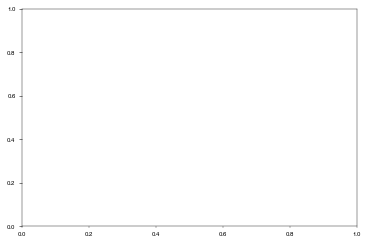

In [70]:
plt.plot(draw_xind, draw_strengths)

In [43]:
draw_xind

array([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11])

In [11]:
#results = set(get_mighty_keys(0,results))
pp.make_contingency_table(valid_unlabeled_background, results, valid_unlabeled_mousegenes)


array([[   67,  1745],
       [  479, 12295]])

In [12]:
len(valid_unlabeled_mousegenes)

1812

In [15]:
len(valid_unlabeled_background)

14586

In [17]:
len(results.intersection(valid_unlabeled_background))

546

In [33]:
method_df

,Method,CS/Mendelian,N Candidate/Mendelian and MKO,N Candidate/Mendelian not MKO,N Not Candidate/Mendelian and MKO,N Not Candidate/Mendelian Not MKO,OR,pval unadjusted,pval adjusted (FDR)
0,MLP,CS >= 1,190,3316,345,10272,1.706,2.226295e-08,5.474495e-08
1,MLP,CS >= 2,143,2412,392,11176,1.690,5.425802e-07,1.233137e-06
2,MLP,CS >= 3,109,1883,426,11705,1.591,4.804118e-05,8.282962e-05
3,MLP,CS >= 4,91,1535,444,12053,1.609,1.346750e-04,2.148826e-04
4,MLP,CS >= 5,74,1224,461,12364,1.621,3.199305e-04,4.847432e-04
5,MLP,CS >= 6,62,933,473,12655,1.778,9.495578e-05,1.556652e-04
6,MLP,CS >= 7,44,688,491,12900,1.680,2.649284e-03,3.485900e-03
7,MLP,CS >= 8,33,448,502,13140,1.928,9.273680e-04,1.300049e-03
8,MLP,CS >= 9,17,275,518,13313,1.589,8.514975e-02,9.357115e-02
9,MLP,CS >= 10,13,174,522,13414,1.920,3.170248e-02,3.616252e-02


cardiovascular_film 2023-01-25 10:51:59,927 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/background.txt
cardiovascular_film 2023-01-25 10:52:00,366 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/insulin_query.txt
cardiovascular_film 2023-01-25 10:52:00,493 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/insulin_query.txt


GWAS candidate Genes: 2071
Number of Background genes: 14680
Number of unlabeled Background genes: 14116
Number of unlabeled valid GWAS genes: 1941
Number of unlabeled Mouse Genes genes: 517


cardiovascular_film 2023-01-25 10:54:29,113 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/background.txt
cardiovascular_film 2023-01-25 10:54:29,737 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/cad_query.txt
cardiovascular_film 2023-01-25 10:54:30,018 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/cad_query.txt


GWAS candidate Genes: 2071


cardiovascular_film 2023-01-25 10:54:30,183 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/background.txt
cardiovascular_film 2023-01-25 10:54:30,621 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/cad_query.txt
cardiovascular_film 2023-01-25 10:54:30,746 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/cad_query.txt


Number of Background genes: 14680
Number of unlabeled Background genes: 14116
Number of unlabeled valid GWAS genes: 1941
Number of unlabeled Mouse Genes genes: 517
GWAS candidate Genes: 2071


cardiovascular_film 2023-01-25 10:54:30,921 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/background.txt
cardiovascular_film 2023-01-25 10:54:32,154 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/cad_query.txt
cardiovascular_film 2023-01-25 10:54:32,284 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/cad_query.txt


Number of Background genes: 14680
Number of unlabeled Background genes: 14116
Number of unlabeled valid GWAS genes: 1941
Number of unlabeled Mouse Genes genes: 517
GWAS candidate Genes: 2071
Number of Background genes: 14680
Number of unlabeled Background genes: 14116
Number of unlabeled valid GWAS genes: 1941
Number of unlabeled Mouse Genes genes: 517


cardiovascular_film 2023-01-25 10:54:32,453 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/background.txt
cardiovascular_film 2023-01-25 10:54:32,908 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/cad_query.txt
cardiovascular_film 2023-01-25 10:54:33,038 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/cad_query.txt


GWAS candidate Genes: 2071


cardiovascular_film 2023-01-25 10:54:33,219 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/background.txt
cardiovascular_film 2023-01-25 10:54:33,661 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/cad_query.txt
cardiovascular_film 2023-01-25 10:54:33,792 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/cad_query.txt


Number of Background genes: 14680
Number of unlabeled Background genes: 14116
Number of unlabeled valid GWAS genes: 1941
Number of unlabeled Mouse Genes genes: 517
GWAS candidate Genes: 2071
Number of Background genes: 14680
Number of unlabeled Background genes: 14116
Number of unlabeled valid GWAS genes: 1941
Number of unlabeled Mouse Genes genes: 517


cardiovascular_film 2023-01-25 10:54:33,965 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/background.txt
cardiovascular_film 2023-01-25 10:54:34,411 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/cad_query.txt
cardiovascular_film 2023-01-25 10:54:34,542 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/cad_query.txt


GWAS candidate Genes: 405
Number of Background genes: 14443
Number of unlabeled Background genes: 13935
Number of unlabeled valid GWAS genes: 353
Number of unlabeled Mouse Genes genes: 1251


cardiovascular_film 2023-01-25 10:54:34,738 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/background.txt
cardiovascular_film 2023-01-25 10:54:35,318 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/immune_dysreg_query.txt
cardiovascular_film 2023-01-25 10:54:35,454 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/immune_dysreg_query.txt


GWAS candidate Genes: 405


cardiovascular_film 2023-01-25 10:54:35,629 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/background.txt
cardiovascular_film 2023-01-25 10:54:36,089 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/immune_dysreg_query.txt
cardiovascular_film 2023-01-25 10:54:36,219 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/immune_dysreg_query.txt


Number of Background genes: 14443
Number of unlabeled Background genes: 13935
Number of unlabeled valid GWAS genes: 353
Number of unlabeled Mouse Genes genes: 1251
GWAS candidate Genes: 405
Number of Background genes: 14443
Number of unlabeled Background genes: 13935
Number of unlabeled valid GWAS genes: 353
Number of unlabeled Mouse Genes genes: 1251


cardiovascular_film 2023-01-25 10:54:36,388 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/background.txt
cardiovascular_film 2023-01-25 10:54:36,824 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/immune_dysreg_query.txt
cardiovascular_film 2023-01-25 10:54:36,953 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/immune_dysreg_query.txt


GWAS candidate Genes: 405
Number of Background genes: 14443
Number of unlabeled Background genes: 13935
Number of unlabeled valid GWAS genes: 353
Number of unlabeled Mouse Genes genes: 1251


cardiovascular_film 2023-01-25 10:54:37,132 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/background.txt
cardiovascular_film 2023-01-25 10:54:37,569 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/immune_dysreg_query.txt
cardiovascular_film 2023-01-25 10:54:37,699 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/immune_dysreg_query.txt


GWAS candidate Genes: 405


cardiovascular_film 2023-01-25 10:54:37,883 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/background.txt
cardiovascular_film 2023-01-25 10:54:38,320 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/immune_dysreg_query.txt
cardiovascular_film 2023-01-25 10:54:38,449 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/immune_dysreg_query.txt


Number of Background genes: 14443
Number of unlabeled Background genes: 13935
Number of unlabeled valid GWAS genes: 353
Number of unlabeled Mouse Genes genes: 1251
GWAS candidate Genes: 405
Number of Background genes: 14443
Number of unlabeled Background genes: 13935
Number of unlabeled valid GWAS genes: 353
Number of unlabeled Mouse Genes genes: 1251


cardiovascular_film 2023-01-25 10:54:38,623 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/background.txt
cardiovascular_film 2023-01-25 10:54:39,065 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/immune_dysreg_query.txt
cardiovascular_film 2023-01-25 10:54:39,194 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/immune_dysreg_query.txt


GWAS candidate Genes: 1415
Number of Background genes: 14709
Number of unlabeled Background genes: 14586
Number of unlabeled valid GWAS genes: 1388
Number of unlabeled Mouse Genes genes: 1812


cardiovascular_film 2023-01-25 10:54:39,449 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/background.txt
cardiovascular_film 2023-01-25 10:54:40,144 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/DOID9970.txt
cardiovascular_film 2023-01-25 10:54:40,278 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/DOID9970.txt


GWAS candidate Genes: 1415
Number of Background genes: 14709
Number of unlabeled Background genes: 14586
Number of unlabeled valid GWAS genes: 1388
Number of unlabeled Mouse Genes genes: 1812


cardiovascular_film 2023-01-25 10:54:40,480 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/background.txt
cardiovascular_film 2023-01-25 10:54:40,927 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/DOID9970.txt
cardiovascular_film 2023-01-25 10:54:41,062 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/DOID9970.txt


GWAS candidate Genes: 1415
Number of Background genes: 14709
Number of unlabeled Background genes: 14586
Number of unlabeled valid GWAS genes: 1388
Number of unlabeled Mouse Genes genes: 1812


cardiovascular_film 2023-01-25 10:54:41,288 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/background.txt
cardiovascular_film 2023-01-25 10:54:41,729 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/DOID9970.txt
cardiovascular_film 2023-01-25 10:54:41,861 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/DOID9970.txt


GWAS candidate Genes: 1415
Number of Background genes: 14709
Number of unlabeled Background genes: 14586
Number of unlabeled valid GWAS genes: 1388
Number of unlabeled Mouse Genes genes: 1812


cardiovascular_film 2023-01-25 10:54:42,068 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/background.txt
cardiovascular_film 2023-01-25 10:54:42,511 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/DOID9970.txt
cardiovascular_film 2023-01-25 10:54:42,647 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/DOID9970.txt


GWAS candidate Genes: 1415
Number of Background genes: 14709
Number of unlabeled Background genes: 14586
Number of unlabeled valid GWAS genes: 1388
Number of unlabeled Mouse Genes genes: 1812


cardiovascular_film 2023-01-25 10:54:42,843 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/background.txt
cardiovascular_film 2023-01-25 10:54:43,284 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/DOID9970.txt
cardiovascular_film 2023-01-25 10:54:43,420 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/DOID9970.txt


GWAS candidate Genes: 1415
Number of Background genes: 14709
Number of unlabeled Background genes: 14586
Number of unlabeled valid GWAS genes: 1388
Number of unlabeled Mouse Genes genes: 1812


cardiovascular_film 2023-01-25 10:54:43,627 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/background.txt
cardiovascular_film 2023-01-25 10:54:44,195 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/DOID9970.txt
cardiovascular_film 2023-01-25 10:54:44,330 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/DOID9970.txt


GWAS candidate Genes: 1399


cardiovascular_film 2023-01-25 10:54:44,577 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/background.txt
cardiovascular_film 2023-01-25 10:54:45,017 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/diabetes_query.txt
cardiovascular_film 2023-01-25 10:54:45,144 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/diabetes_query.txt


Number of Background genes: 14715
Number of unlabeled Background genes: 14541
Number of unlabeled valid GWAS genes: 1371
Number of unlabeled Mouse Genes genes: 719
GWAS candidate Genes: 1399
Number of Background genes: 14715
Number of unlabeled Background genes: 14541
Number of unlabeled valid GWAS genes: 1371
Number of unlabeled Mouse Genes genes: 719


cardiovascular_film 2023-01-25 10:54:45,318 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/background.txt
cardiovascular_film 2023-01-25 10:54:45,757 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/diabetes_query.txt
cardiovascular_film 2023-01-25 10:54:45,886 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/diabetes_query.txt


GWAS candidate Genes: 1399


cardiovascular_film 2023-01-25 10:54:46,063 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/background.txt
cardiovascular_film 2023-01-25 10:54:46,503 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/diabetes_query.txt
cardiovascular_film 2023-01-25 10:54:46,630 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/diabetes_query.txt


Number of Background genes: 14715
Number of unlabeled Background genes: 14541
Number of unlabeled valid GWAS genes: 1371
Number of unlabeled Mouse Genes genes: 719
GWAS candidate Genes: 1399


cardiovascular_film 2023-01-25 10:54:46,805 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/background.txt
cardiovascular_film 2023-01-25 10:54:47,242 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/diabetes_query.txt
cardiovascular_film 2023-01-25 10:54:47,370 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/diabetes_query.txt


Number of Background genes: 14715
Number of unlabeled Background genes: 14541
Number of unlabeled valid GWAS genes: 1371
Number of unlabeled Mouse Genes genes: 719
GWAS candidate Genes: 1399
Number of Background genes: 14715
Number of unlabeled Background genes: 14541
Number of unlabeled valid GWAS genes: 1371
Number of unlabeled Mouse Genes genes: 719


cardiovascular_film 2023-01-25 10:54:47,548 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/background.txt
cardiovascular_film 2023-01-25 10:54:47,986 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/diabetes_query.txt
cardiovascular_film 2023-01-25 10:54:48,238 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/diabetes_query.txt


GWAS candidate Genes: 1399
Number of Background genes: 14715
Number of unlabeled Background genes: 14541
Number of unlabeled valid GWAS genes: 1371
Number of unlabeled Mouse Genes genes: 719


cardiovascular_film 2023-01-25 10:54:48,412 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/background.txt
cardiovascular_film 2023-01-25 10:54:48,854 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/diabetes_query.txt
cardiovascular_film 2023-01-25 10:54:48,990 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/diabetes_query.txt


GWAS candidate Genes: 289


cardiovascular_film 2023-01-25 10:54:49,195 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/background.txt
cardiovascular_film 2023-01-25 10:54:49,641 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/insulin_query.txt
cardiovascular_film 2023-01-25 10:54:49,765 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/insulin_query.txt


Number of Background genes: 14712
Number of unlabeled Background genes: 14123
Number of unlabeled valid GWAS genes: 264
Number of unlabeled Mouse Genes genes: 535
GWAS candidate Genes: 289


cardiovascular_film 2023-01-25 10:54:49,940 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/background.txt
cardiovascular_film 2023-01-25 10:54:50,389 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/insulin_query.txt
cardiovascular_film 2023-01-25 10:54:50,514 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/insulin_query.txt


Number of Background genes: 14712
Number of unlabeled Background genes: 14123
Number of unlabeled valid GWAS genes: 264
Number of unlabeled Mouse Genes genes: 535
GWAS candidate Genes: 289
Number of Background genes: 14712
Number of unlabeled Background genes: 14123
Number of unlabeled valid GWAS genes: 264
Number of unlabeled Mouse Genes genes: 535


cardiovascular_film 2023-01-25 10:54:50,687 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/background.txt
cardiovascular_film 2023-01-25 10:54:51,134 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/insulin_query.txt
cardiovascular_film 2023-01-25 10:54:51,258 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/insulin_query.txt


GWAS candidate Genes: 289
Number of Background genes: 14712
Number of unlabeled Background genes: 14123
Number of unlabeled valid GWAS genes: 264
Number of unlabeled Mouse Genes genes: 535


cardiovascular_film 2023-01-25 10:54:51,454 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/background.txt
cardiovascular_film 2023-01-25 10:54:51,903 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/insulin_query.txt
cardiovascular_film 2023-01-25 10:54:52,028 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/insulin_query.txt


GWAS candidate Genes: 289
Number of Background genes: 14712
Number of unlabeled Background genes: 14123
Number of unlabeled valid GWAS genes: 264
Number of unlabeled Mouse Genes genes: 535


cardiovascular_film 2023-01-25 10:54:52,215 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/background.txt
cardiovascular_film 2023-01-25 10:54:52,782 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/insulin_query.txt
cardiovascular_film 2023-01-25 10:54:52,907 [INFO] speos.postprocessing.postprocessor: Reading mouse knockout genes from ~/ppi-core-genes/data/mgi/insulin_query.txt


GWAS candidate Genes: 289
Number of Background genes: 14712
Number of unlabeled Background genes: 14123
Number of unlabeled valid GWAS genes: 264
Number of unlabeled Mouse Genes genes: 535
66
66
78
78
73
73
53
53
71
71


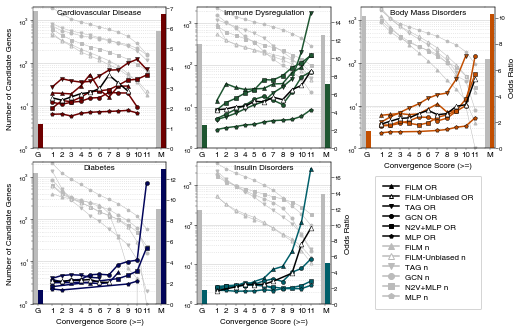

In [15]:
#handler_paths = {"Insulin Disorder": "/home/icb/florin.ratajczak/ppi-core-genes/results/insulin_disorder.h5",
#                 "Monogenic Diabetes": "/home/icb/florin.ratajczak/ppi-core-genes/results/diabetes.h5",
#                 "Bodymass Disorder": "/home/icb/florin.ratajczak/ppi-core-genes/results/bm_disorder3.h5",
#                 "Cardiovascular Disease": "/home/icb/florin.ratajczak/ppi-core-genes/results/cardiovascular5.h5",
#                 "Immune Dysregulation": "/home/icb/florin.ratajczak/ppi-core-genes/results/immune_dysregulation.h5"}

#handler = ResultsHandler(handler_paths[phenotype], read_only=True)
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import pandas as pd
from speos.visualization.settings import *
import matplotlib.pyplot as plt

def get_mighty_keys(n, results):
    mighty_keys = []
    for key, value in results[0].items():
        if key != "Total" and value > n:
            mighty_keys.append(key)
    return mighty_keys

def get_OR(n, superset, results, setB):
    from scipy.stats import fisher_exact
    try:
        results = set(get_mighty_keys(n,results))
    except TypeError:
        results = set(results)

    array = pp.make_contingency_table(superset,results,setB)

    odds_ratio, pval = fisher_exact(array)

    return odds_ratio, pval, array

import numpy as np
from statsmodels.stats.multitest import fdrcorrection as fdr

background = None

phenotypes = ["Cardiovascular Disease", "Immune Dysregulation", "Body Mass Disorders", "Diabetes", "Insulin Disorders"]
methods = ["film", "film_unbiased", "tag", "gcn", "n2vmlp", "mlp"]
pretty_methods = ["FiLM", "FiLM-Unbiased", "TAG", "GCN", "N2V+MLP", "MLP"]

tick_size = small_font
label_size = medium_font
title_size = medium_font

crimson = "#6f0000"
navy = "#02055a"
jungle = "#1e5631"
tan = "#c24e00"
petrol = "#005f6a"
grey = "#bbbbbb"
lightgrey = "#dddddd"
width_ratios = [10, 1]*2
marker_size = 4


colors_ = [crimson, jungle, tan, navy, petrol]
markers = ["^", "^", "v", "o", "s", "p"]
min_strength = 1000

outer_dfs_list = []
for frame_idx, (phenotype, color) in enumerate(zip(phenotypes, colors_)):
    if frame_idx == 5:
        break
    dfs = []
    for pretty_method, method, marker in zip(pretty_methods, methods, markers):
        _columns= ["Method", "CS/Mendelian", "N Candidate/Mendelian and MKO", "N Candidate/Mendelian not MKO", "N Not Candidate/Mendelian and MKO", "N Not Candidate/Mendelian Not MKO", "OR", "pval unadjusted", "pval adjusted (FDR)"]
        df = pd.DataFrame(data=np.empty((12, len(_columns))), columns=_columns)
        if method in ["gcn", "mlp", "n2vmlp"] and phenotype == "Immune Dysregulation":
            method += "_new"
        
        if method == "film" and phenotype == "Immune Dysregulation":
            method += "_forreal"
    
        config_paths = {"Insulin Disorders": "configs/config_insulin_disorder_{}.yaml".format(method),
                        "Diabetes": "configs/config_diabetes_{}.yaml".format(method),
                        "Body Mass Disorders": "configs/config_bm_disorder_{}.yaml".format(method),
                        "Cardiovascular Disease": "configs/config_cardiovascular_{}.yaml".format(method),
                        "Immune Dysregulation": "configs/config_immune_dysregulation_{}.yaml".format(method)}
        
        #if method == "film" and phenotype == "Immune Dysregulation":
        #    config_paths[phenotype] = "configs/config_immune_dysregulation_{}_forreal.yaml".format(method)

        config = Config()
        config.parse_yaml(config_paths[phenotype])

        pp = PostProcessor(config)

        import json
        
        gwas_outer_results_paths = {"Insulin Disorders": "/home/icb/florin.ratajczak/ppi-core-genes/data/mapped_genes/closest/insulin_disorder_outer_results.json",
                        "Diabetes": "/home/icb/florin.ratajczak/ppi-core-genes/data/mapped_genes/closest/diabetes_outer_results.json",
                        "Body Mass Disorders": "/home/icb/florin.ratajczak/ppi-core-genes/data/mapped_genes/closest/bm_disorder_outer_results.json",
                        "Cardiovascular Disease": "/home/icb/florin.ratajczak/ppi-core-genes/data/mapped_genes/closest/cardiovascular_disease_outer_results.json",
                        "Immune Dysregulation": "/home/icb/florin.ratajczak/ppi-core-genes/data/mapped_genes/closest/immune_dysregulation_outer_results.json"}

        with open(gwas_outer_results_paths[phenotype], "r") as file:
            gwas_results = json.load(file)

        gwas_genes = set(gwas_results[0].keys())
        print("GWAS candidate Genes: {}".format(len(gwas_genes)))
        unknown_genes, all_genes, positive_genes = pp.get_unknown_genes(pp.results_paths[0][0])
        background = set(pp.get_mouse_knockout_background("~/ppi-core-genes/data/mgi/background.txt"))
        valid_background = background.intersection(all_genes)
        print("Number of Background genes: {}".format(len(valid_background)))
        valid_unlabeled_background = valid_background.intersection(unknown_genes)
        print("Number of unlabeled Background genes: {}".format(len(valid_unlabeled_background)))
        valid_gwas_genes = gwas_genes.intersection(unknown_genes)
        #valid_gwas_genes = gwas_genes
        print("Number of unlabeled valid GWAS genes: {}".format(len(valid_gwas_genes)))
        mousegenes = set(pp.get_mouse_knockout_genes("~/ppi-core-genes/data/mgi/{}.txt".format(pp.get_doid())))
        valid_mousegenes = pp.return_only_valid(mousegenes, valid_background)
        valid_unlabeled_mousegenes = pp.return_only_valid(mousegenes, valid_unlabeled_background)
        print("Number of unlabeled Mouse Genes genes: {}".format(len(valid_unlabeled_mousegenes)))
        
        gwas_odds_ratio, gwas_pval, array = get_OR(1, valid_background, valid_gwas_genes, valid_mousegenes)

        df.loc[0, :] = ["-", "GWAS", array[0][0], array[1][0], array[0][1], array[1][1], gwas_odds_ratio, gwas_pval, None]

        outer_results_paths = {"Insulin Disorders": "/lustre/groups/epigenereg01/projects/ppi-florin/results/insulin_disorder_{}outer_results.json".format(method),
                        "Diabetes": "/lustre/groups/epigenereg01/projects/ppi-florin/results/diabetes_{}outer_results.json".format(method),
                        "Body Mass Disorders": "/lustre/groups/epigenereg01/projects/ppi-florin/results/bm_disorder_{}outer_results.json".format(method),
                        "Cardiovascular Disease": "/lustre/groups/epigenereg01/projects/ppi-florin/results/cardiovascular_{}outer_results.json".format(method),
                        "Immune Dysregulation": "/lustre/groups/epigenereg01/projects/ppi-florin/results/immune_dysregulation_{}outer_results.json".format(method)}

        
        #outer_results_paths[phenotype] = "/lustre/groups/epigenereg01/projects/ppi-florin/results/immune_dysregulation_{}_forrealouter_results.json".format(method)
        

        with open(outer_results_paths[phenotype], "r") as file:
            results = json.load(file)

        unknown_genes, all_genes, positive_genes = pp.get_unknown_genes(pp.results_paths[0][0])
        if background is None:
            background = set(pp.get_mouse_knockout_background("~/ppi-core-genes/data/mgi/background.txt"))
        valid_background = background.intersection(all_genes)
        valid_unlabeled_background = valid_background.intersection(unknown_genes)
                
        mousegenes = set(pp.get_mouse_knockout_genes("~/ppi-core-genes/data/mgi/{}.txt".format(pp.get_doid())))
        valid_mousegenes = pp.return_only_valid(mousegenes, valid_background)
        valid_unlabeled_mousegenes = pp.return_only_valid(mousegenes, valid_unlabeled_background)
        
        #print("{} {}: {} positives".format(phenotype, method, len(positive_genes)))
        groups = []
        ors = []
        pvals = []
        strengths = []
        n_candidates_and_mko = []
        n_candidates_not_mko = []
        n_not_candidates_and_mko = []
        n_not_candidates_not_mko = []

        for i in range(11):
            group = ">= {}".format(i + 1)
            groups.append(group)
            odds_ratio, pval, array = get_OR(i, valid_unlabeled_background, results, valid_unlabeled_mousegenes)
            ors.append(odds_ratio)
            pvals.append(pval)
            strength = len(get_mighty_keys(i, results))
            strengths.append(strength)
            df.loc[i + 1, :] = [pretty_method, "CS "+ group, array[0][0], array[1][0], array[0][1], array[1][1], odds_ratio, pval, None]
            #print("{}: {}, p: {:.2e}, n: {}".format(group, odds_ratio, pval, strength))

        min_strength = np.min(strengths) if np.min(strengths) < min_strength else min_strength
        m_odds_ratio, m_pval, array = get_OR(i, valid_background, set(positive_genes), valid_mousegenes)
        m_strength = len(positive_genes)
        #print("{}: {}, p: {:.2e}, n: {}".format(group, odds_ratio, pval, strength))
        df.loc[12, :] = ["-", "Mendelian", array[0][0], array[1][0], array[0][1], array[1][1], m_odds_ratio, m_pval, None]

        if phenotype == "Cardiovascular Disease" and method == "tag":
            cvd_strengths = strengths
            cvd_ors = ors
            cvd_mendelian_strength = m_strength
            cvd_mendelian_ors = m_odds_ratio

        
        dfs.append(df)
    
    dfs = pd.concat(dfs)
    
    for column in dfs.columns:
        if "OR" in column:
            dfs[column] = dfs[column].round(3)
        if "N " in column:
            dfs[column] = dfs[column].astype(int)
    outer_dfs_list.append(dfs)

pvals = []
for df in outer_dfs_list:
    pvals.extend(df["pval unadjusted"].tolist())


adj_pvals = fdr(pvals)[1]

for df, adj_pval_one_df, phenotype in zip(outer_dfs_list, np.array_split(adj_pvals, len(outer_dfs_list)), phenotypes):
    print((adj_pval_one_df < 0.05).sum())
    df["pval adjusted (FDR)"] = adj_pval_one_df
    print((df["pval adjusted (FDR)"] < 0.05).sum())
    df.to_csv("statistical_dump/{}_ors_mko_gwas_unbiased.tsv".format(phenotype), sep="\t", index=False)

fig, axes = plt.subplots(figsize=(full_width*cm,12*cm), nrows=2, ncols=12, sharey=False, gridspec_kw={'width_ratios': [1, 11, 1, 3, 1, 11, 1, 3, 1, 11, 1, 0.1]})
axes = axes.flatten()

for frame_idx, (phenotype, color, (ax0, ax1, ax3, invis_ax), df) in enumerate(zip(phenotypes + ["None"], colors_ + ["None"], np.array_split(axes, 6), outer_dfs_list + ["None"])):
    if frame_idx == 5:
        ax0.axis("off")
        ax1.axis("off")
        ax3.axis("off")
        invis_ax.axis("off")
        handles = [Line2D([0], [0], color="black", marker=marker, markeredgecolor="black", markerfacecolor="black" if label != "FiLM-Unbiased" else "white", markersize=marker_size, label=label + " OR") for marker, label in zip(markers, pretty_methods)]
        handles.extend([Line2D([0], [0], color=grey, marker=marker, markeredgecolor=grey, markerfacecolor=grey if label != "FiLM-Unbiased" else "white", label=label + " n") for marker, label in zip(markers, pretty_methods)])
        #handles.extend([Patch(facecolor=color, edgecolor='black', label=label) for color, label in zip(colors_, phenotypes)])
        #handles.append([Line2D([0], [0], color=color, marker="s", label=label) for label in phenotypes])
        leg = ax1.legend(handles=handles, loc='center', fontsize=label_size, labelspacing=0.3, borderpad=1)
        bb = leg.get_bbox_to_anchor().transformed(ax1.transAxes.inverted())

        # Change to location of the legend. 
        yOffset = -0.065
        bb.y0 += yOffset
        bb.y1 += yOffset
        leg.set_bbox_to_anchor(bb, transform = ax1.transAxes)
        break

    axG = ax0.twinx()
    ax2 = ax1.twinx()
    ax4 = ax3.twinx()
    handles = []
    min_strength = 1000
    dfs = []
    
    start = 0
    stride = 13

    for method_idx, (pretty_method, method, marker) in enumerate(zip(pretty_methods, methods, markers)):
        
        method_df = df[start:start + stride]
        start += stride
        assert method_df["Method"][1] == pretty_method

        groups = method_df["CS/Mendelian"][1:-1]
        ors = method_df["OR"]
        adj_pvals = method_df["pval adjusted (FDR)"]
        strengths = np.asarray(method_df["N Candidate/Mendelian and MKO"]) + np.asarray(method_df["N Candidate/Mendelian not MKO"])
        n_candidates_and_mko = method_df["N Candidate/Mendelian and MKO"]
        n_candidates_not_mko = method_df["N Candidate/Mendelian not MKO"]
        n_not_candidates_and_mko = method_df["N Not Candidate/Mendelian and MKO"]
        n_not_candidates_not_mko = method_df["N Not Candidate/Mendelian Not MKO"]

        xind = np.asarray((range(stride)))
        width = 0.8

        # plot set strengths
        is_positive = np.asarray(strengths[-1]) > 0
        draw_xind = np.asarray(xind[1:-1])[is_positive]
        draw_strengths = np.asarray(strengths[1:-1])[is_positive]
        ax1.plot(draw_xind[0], draw_strengths[0], 
                color=grey,
                zorder=1 if method != "film_unbiased" else 2,
                markeredgecolor=grey, 
                markerfacecolor=grey if method != "film_unbiased" else "white",
                marker=marker,
                linewidth=0.5,
                ms = marker_size-1)
        ax1.set_axisbelow(True)
        ax3.bar(1-(width/2), height=strengths[-1], width=width, color=grey, zorder=1)
        ax3.set_axisbelow(True)
        ax0.bar(1-(width/2), height=strengths[0], width=width, color=grey, zorder=1)
        ax0.set_axisbelow(True)
        
        is_significant = np.asarray(adj_pvals[1:-1]) < 0.05
        is_enough = np.asarray(strengths[1:-1]) > 0
        use_only = is_significant & is_enough
        draw_xind = np.asarray(xind[1:-1])[use_only]
        draw_ors = np.asarray(ors[1:-1])[use_only]
        handle, = ax2.plot(draw_xind, draw_ors, 
                           color=color if method != "film_unbiased" else "black", 
                           zorder=4 if method != "film_unbiased" else 5, 
                           marker=marker, 
                           markeredgecolor="black", 
                           markeredgewidth=0.5,
                           markerfacecolor=color if method != "film_unbiased" else "white",
                           ms=marker_size  if method != "film_unbiased" else 1.2*marker_size, 
                           label=method)
        handles.append(handle)
        ax4.bar(1+(width/2), height=ors.tolist()[-1], width=width, color=color, zorder=1)
        ax4.set_axisbelow(True)
        axG.bar(1+(width/2), height=ors.tolist()[0], width=width, color=color, zorder=1)
        axG.set_axisbelow(True)
        ax2.set_axisbelow(True)
        ax2.set_xticks(xind)
        ax2.set_xticklabels(xind.astype(np.uint8) + 1, size=small_font)
        ax3.set_xticks([1])
        ax3.set_xticklabels(["M"], size=label_size)
        ax0.set_xticks([1])
        ax0.set_xticklabels(["G"], size=label_size)
        ax0.tick_params(axis="x", pad=1)
        ax2.tick_params(axis="x", pad=1)
        ax3.tick_params(axis="x", pad=1)
        if frame_idx % 3 == 0:
            ax0.set_ylabel("Number of Candidate Genes", size=label_size)
        elif frame_idx % 3 == 2:
            ax4.set_ylabel("Odds Ratio", size=label_size)
        
        if frame_idx == 4:
            ax4.set_ylabel("Odds Ratio", size=label_size)
            
        if frame_idx >= 2:
            ax1.set_xlabel("Convergence Score (>=)", size=label_size)

        ax1.set_title(phenotype, y=1.05, x=0.5, pad=-14, size=title_size)    

    _, candidate_max_strength = ax1.get_ylim()
    _, mendelian_max_strength = ax3.get_ylim()
    max_strength = np.max((candidate_max_strength, mendelian_max_strength))
    max_strenth = 1000 if max_strength < 1000 else max_strength

    min_strength = 1

    ax0.set_yscale('log')
    ax1.set_yscale('log')
    ax3.set_yscale('log')
    ax0.set_ylim((min_strength, max_strenth))
    ax1.set_ylim((min_strength, max_strenth))
    ax3.set_ylim((min_strength, max_strenth))
    
    candidate_max_or = ax2.get_ylim()[1]
    mendelian_max_or = ax4.get_ylim()[1]
    ax2.set_ylim((0, np.max((candidate_max_or, mendelian_max_or))))
    ax4.set_ylim((0, np.max((candidate_max_or, mendelian_max_or))))
    axG.set_ylim((0, np.max((candidate_max_or, mendelian_max_or))))

    ax1.grid(True, which="major", axis="y", color=lightgrey)
    ax1.grid(True,which="minor", axis="y", linestyle=":", color=lightgrey)
    ax0.grid(True,which="major", axis="y", color=lightgrey)
    ax0.grid(True,which="minor", axis="y", linestyle=":", color=lightgrey)
    ax3.grid(True,which="major", axis="y", color=lightgrey)
    ax3.grid(True,which="minor", axis="y", linestyle=":", color=lightgrey)

    #ax1.set_yticks([], which="both")
    ax1.set_yticklabels([])
    ax1.spines['left'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_yticks([], which="both")
    for tick in ax1.yaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
    for tick in ax1.yaxis.get_minor_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
    #ax1.set_yticks([], which="both")
    #ax1.set_yticks([], minor=True)
    #ax3.set_yticks([], which="both")
    ax0.spines['left'].set_visible(False)
    ax0.spines['right'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    #ax3.set_yticks([], minor=True)
    ax3.set_yticklabels([])
    for tick in ax3.yaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
    for tick in ax3.yaxis.get_minor_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
    ax4.spines['left'].set_visible(False)
    #ax4.set_yticks([], which="left")
    axG.set_yticks([])
    axG.spines['right'].set_visible(False)
    ax0.tick_params(axis="y", pad=0.5)
    ax4.tick_params(axis="y", pad=0.5)


    ax1.set_xticks(range(1,12))
    ax1.set_xticklabels([str(x) for x in range(1,12)])
    ax1.tick_params(axis="x", labelsize=label_size)
    ax1.tick_params(axis="x", pad=1)
    invis_ax.set_visible(False)
    #or_lines_y = ax4.get_xticks()

    #for y in  or_lines_y:
    #    ax2.plot((-0.5, 13.5), (y, y), color="grey")

fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0.1)
#ax2.legend(handles, pretty_methods, loc='upper center',prop={'size': label_size})
#plt.xlabel("Predicted in n Outer CVs")
#plt.savefig("OR_all.png".format(config.name), dpi=400, transparent=False,facecolor="white", bbox_inches='tight')
plt.savefig("OR_all_unbiased.svg", bbox_inches='tight', dpi=400)

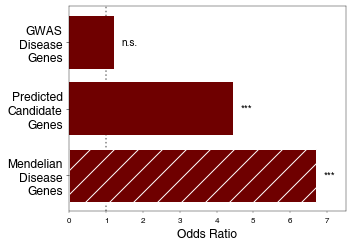

In [59]:

gwas = 1.21
candidates = 4.459
mendelians = 6.7

fig, ax = plt.subplots(figsize=(5,full_width*cm/2))
ax.barh([3,2], [gwas, candidates], color=crimson)
ax.barh([1], [mendelians], color=crimson, edgecolor= 'white', hatch= "/")

ax.axline((1, 1), (1, 2), color="gray",ls=":", zorder=-1)
ax.set_yticks([1,2,3])
ax.set_yticklabels(["Mendelian\nDisease\nGenes","Predicted\nCandidate\nGenes","GWAS\nDisease\nGenes"], fontsize=12)
ax.set_xlim(0, 7.5)
ax.set_xticks(range(0, 8))
ax.set_xticklabels(range(0, 8), fontsize=8)
ax.set_xlabel("Odds Ratio", fontsize=12)
ax.text(x=gwas+0.2, y=3, s="n.s.", verticalalignment="center")
ax.text(x=candidates+0.2, y=2, s="***", verticalalignment="center")
ax.text(x=mendelians+0.2, y=1, s="***", verticalalignment="center")
fig.tight_layout()
plt.savefig("cardiovascular.png", bbox_inches="tight", dpi=400)


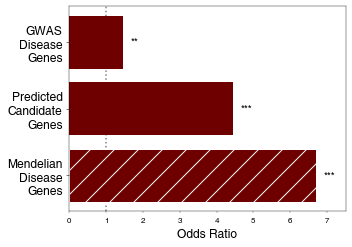

In [58]:

gwas = 1.47
candidates = 4.459
mendelians = 6.7

fig, ax = plt.subplots(figsize=(5,full_width*cm/2))
ax.barh([3,2], [gwas, candidates], color=crimson)
ax.barh([1], [mendelians], color=crimson, edgecolor= 'white', hatch= "/")

ax.axline((1, 1), (1, 2), color="gray",ls=":", zorder=-1)
ax.set_yticks([1,2,3])
ax.set_yticklabels(["Mendelian\nDisease\nGenes","Predicted\nCandidate\nGenes","GWAS\nDisease\nGenes"], fontsize=12)
ax.set_xlim(0, 7.5)
ax.set_xticks(range(0, 8))
ax.set_xticklabels(range(0, 8), fontsize=8)
ax.set_xlabel("Odds Ratio", fontsize=12)
ax.text(x=gwas+0.2, y=3, s="**", verticalalignment="center")
ax.text(x=candidates+0.2, y=2, s="***", verticalalignment="center")
ax.text(x=mendelians+0.2, y=1, s="***", verticalalignment="center")
fig.tight_layout()
plt.savefig("cardiovascular_with_mendelians.png", bbox_inches="tight", dpi=400)
